## Source script

In [1]:
import numpy as np
import numpy.linalg as la
import pandas as pd
import ipywidgets
import paramiko
import pysftp
import shutil
import getpass
import math
import sys
import copy
import os
import time
from smt.sampling_methods import LHS
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
plt.rcParams.update({'font.size': 30})

In [2]:
def sshCommand(hostname, port, username, password, command):
    sshClient = paramiko.SSHClient()                                   # create SSHClient instance
    sshClient.set_missing_host_key_policy(paramiko.AutoAddPolicy())    # AutoAddPolicy automatically adding the hostname and new host key
    sshClient.load_system_host_keys()
    sshClient.connect(hostname, port, username, password)
    stdin, stdout, stderr = sshClient.exec_command(command)
    for line in stdout:
        print(line.strip('\n'))

def put_r_windows(sftp, localdir, remotedir, preserve_mtime = False):
    for entry in os.listdir(localdir):
        remotepath = remotedir + "/" + entry
        localpath = os.path.join(localdir, entry)
        if not os.path.isfile(localpath):
            try:
                sftp.mkdir(remotepath)
            except OSError:     
                pass
            put_r_windows(sftp, localpath, remotepath, preserve_mtime)
        else:
            sftp.put(localpath, remotepath, preserve_mtime=preserve_mtime) 

def query_yes_no(question, default = None):
    """Ask a yes/no question via input() and return their answer.

    "question" is a string that is presented to the user.
    "default" is the presumed answer if the user just hits <Enter>.
        It must be "yes" (the default), "no" or None (meaning
        an answer is required of the user).

    The "answer" return value is True for "yes" or False for "no".
    """
    valid = {"yes": True, "y": True, "ye": True,
             "no": False, "n": False}
    if default is None:
        prompt = " [y/n] "
    elif default == "yes":
        prompt = " [Y/n] "
    elif default == "no":
        prompt = " [y/N] "
    else:
        raise ValueError("invalid default answer: '%s'" % default)

    while True:
        sys.stdout.write(question + prompt)
        choice = input().lower()
        if default is not None and choice == '':
            return valid[default]
        elif choice in valid:
            return valid[choice]
        else:
            sys.stdout.write("Please respond with 'yes' or 'no' "
                             "(or 'y' or 'n').\n")

def dos2unix(file_path):
    # replacement strings
    WINDOWS_LINE_ENDING = b'\r\n'
    UNIX_LINE_ENDING = b'\n'

    with open(file_path, 'rb') as open_file:
        content = open_file.read()
    content = content.replace(WINDOWS_LINE_ENDING, UNIX_LINE_ENDING)
    with open(file_path, 'wb') as open_file:
        open_file.write(content)

def variable_options(display = False):
    options = [
        "Average_CellVoltage",
        "Average_CurrentDensity",
        "BackEnvironmentT",
        "BottomEnvironmentT",
        "CellFuelFlowRate",
        "CellOxidantFlowRate",
        "FrontEnvironmentT",
        "Fuel_Utilization",
        "FuelH2",
        "FuelH2O",
        "FuelCO",
        "FuelCO2",
        "FuelCH4",
        "FuelN2",
        "FuelTemperature",
        "FuelTOnTop",
        "FuelRecyclePercent",
        "FuelHTXEffectiveness",
        "FuelNGTemperature",
        "FuelNGHTXDeltaT",
        "Internal_Reforming",
        "nCells",
        "Oxidant_Recirculation",
        "OxidantRecyclePercent",
        "OxygenToCarbon_Ratio",
        "OxidantO2",
        "OxidantN2",
        "OxidantH2O",
        "OxidantCO2",
        "OxidantAr",
        "OxidantTemperature",
        "OxidantTOnTop",
        "PreReform",
        "SideEnvironmentT",
        "Simulation_Option",
        "Stack_Fuel_Utilization",
        "Stack_Oxidant_Utilization",
        "StackFuelFlowRate",
        "StackFuelFlowRateH2O",
        "StackFuelFlowRateCO",
        "StackFuelFlowRateCO2",
        "StackFuelFlowRateCH4",
        "StackFuelFlowRateH2",
        "StackFuelFlowRateN2",
        "StackOxidantFlowRate",
        "StackOxidantFlowRateO2",
        "StackOxidantFlowRateN2",
        "StackOxidantFlowRateH2O",
        "StackOxidantFlowRateCO2",
        "StackOxidantFlowRateAr",
        "StackVoltage",
        "SystemPressure",
        "TopEnvironmentT",
        "VGRRate",
        "VGRTemperature",
        "VGRH2OPassRate",
        "VGRH2PassRate",
        "VGRCO2CaptureRate",
        "VGRCOConvertRate"
    ]
    
    if display == True:
        print('Options of input variable:')
        for i in range(len(options)):
            print(i+1, ':', options[i], end = '\t\n')
    else:
        return options
        
class wrapper_all():  
    def wrapper(self, J,FU,AU,OCR,IR,Arec,PreReform,cellsize):
        Nspecies = 11

        MW_fuel = np.arange(Nspecies,dtype=np.float64) ##molucular weight
        NG_fin = np.arange(Nspecies,dtype=np.float64)  ##hardcode, fuel species, in 
        NG_mfin = np.arange(Nspecies,dtype=np.float64) ##fuel species from NG_fin[] turned to fractions
        std_ain = np.arange(Nspecies,dtype=np.float64) ##standard air in
        splt_ain = np.arange(Nspecies,dtype=np.float64) ##air separation split? why not sum==1?
        ref_ain = np.arange(Nspecies,dtype=np.float64)  ##recirculation fuel species? what unit?
        mix_refin = np.arange(Nspecies,dtype=np.float64) ##goes to Reformer, see the graph. Comes from three sources: part of NG, Steam, and air after split.
        mix_cpox=np.arange(Nspecies,dtype=np.float64)  ##intermediate fuel species assuming all complete oxidized?
        mix_refout=np.arange(Nspecies,dtype=np.float64) ##fuel output after hydrocarbon reforming? ExtReform part of NG
        stack_recirc = np.arange(Nspecies,dtype=np.float64) ##contains onl H2O, Ar, CO2, N2, CO, and H2. NO CH4. In iteration loop
        stack_mix = np.arange(Nspecies,dtype=np.float64) ##= stack_fin[] + stack_recirc[]
        pref_HH = np.arange(Nspecies,dtype=np.float64)  ##After PreReformer step 1: taking care of high hydrocarbon: all high hydrocarbon hone
        pref_CH4 = np.arange(Nspecies,dtype=np.float64) ##After PreReformer step 2: taking care of PreReforming: only CH4, by PreReform
                                                              ##this leads to output SOFC_Fin[]
        cell_ref = np.arange(Nspecies,dtype=np.float64) ##an assumed fuel composition at the stack inlet in the iteration loop. No more CH4. 
        cell_use = np.arange(Nspecies,dtype=np.float64) ##
        cell_exit = np.arange(Nspecies,dtype=np.float64)
        NG_in = np.arange(Nspecies,dtype=np.float64)
        vartemp = np.arange(Nspecies,dtype=np.float64)
        tester = np.arange(Nspecies,dtype=np.float64)
        pref_CH4OLD = np.arange(Nspecies,dtype=np.float64)
        stack_recircOLD = np.arange(Nspecies,dtype=np.float64)
        stack_recircOLD[:]=0.0
        ##air part
        stack_ain = np.arange(Nspecies,dtype=np.float64)
        stack_amix = np.arange(Nspecies,dtype=np.float64)
        stack_arecirc = np.arange(Nspecies,dtype=np.float64)
        stack_arecircOLD = np.arange(Nspecies,dtype=np.float64)
        cell_aexit = np.arange(Nspecies,dtype=np.float64)
        cell_aexhaust = np.arange(Nspecies,dtype=np.float64)

        SOFC_Ain = np.arange(5,dtype=np.float64)
        Fresh_Ain = np.arange(5,dtype=np.float64)
        stack_fin = np.arange(Nspecies,dtype=np.float64) ##The NG part before PreReformer: sum of two parts, pure NG (IR part) and mix_refout (ExtReform part)
        #% Read Independent Variables
    #    J=400
    #    FU=0.9
    #    AU=0.378
    #    OCR=2.6
    #    IR=0.6
    #    Arec=0.5
    #    PreReform=0.2

    #    cellsize = 550 # cell area (cm2)
        #% Assign General Fixed Values 
        R=8.3145
        F=96485
        Pi=3.14159265359

        #% index
        Index_H2O = 0
        Index_Ar = 1
        Index_CO2 = 2
        Index_O2 = 3
        Index_N2 = 4
        Index_CH4 = 5
        Index_CO = 6
        Index_H2 = 7
        Index_C2H6 = 8
        Index_C3H8 = 9
        Index_C4H10 = 10

        #%
        # Molecular Weights
        MW_fuel[Index_H2O] = 18.01488 # H2O
        MW_fuel[Index_Ar] = 39.948 # Ar
        MW_fuel[Index_CO2] = 44.009 # CO2
        MW_fuel[Index_O2] = 31.998 # O2
        MW_fuel[Index_N2] = 28.0134 # N2
        MW_fuel[Index_CH4] = 16.04276 # CH4
        MW_fuel[Index_CO] = 28.01 # CO
        MW_fuel[Index_H2] = 2.01588 # H2
        MW_fuel[Index_C2H6] = 30.07 # C2H6
        MW_fuel[Index_C3H8] = 44.1 # C3H8
        MW_fuel[Index_C4H10] = 58.12 # C4H10
        #%
        #-- Define Fixed Assumptions for Operation
        max_steam = 0.99 #-- Maximum fuel recirculation fraction

        #%
        #-- Define the inlet fuel feed composition (NG)
        NG_fin[Index_H2O] = 0
        NG_fin[Index_Ar] = 0
        NG_fin[Index_CO2] = 74.0729157
        NG_fin[Index_O2] = 0
        NG_fin[Index_N2] = 118.516665
        NG_fin[Index_CH4] = 6896.18846
        NG_fin[Index_CO] = 0
        NG_fin[Index_H2] = 0
        NG_fin[Index_C2H6] = 237.03333
        NG_fin[Index_C3H8] = 51.851041
        NG_fin[Index_C4H10] = 29.6291663
        #%
        #-- Define the standard air composition
        std_ain[Index_H2O] = 0.0104
        std_ain[Index_Ar] = 0.0094
        std_ain[Index_CO2] = 0.0003
        std_ain[Index_O2] = 0.2077
        std_ain[Index_N2] = 0.7722
        std_ain[Index_CH4] = 0
        std_ain[Index_CO] = 0
        std_ain[Index_H2] = 0
        std_ain[Index_C2H6] = 0
        std_ain[Index_C3H8] = 0
        std_ain[Index_C4H10] = 0
        #%
        #-- Define the air separation splits
        splt_ain[Index_H2O] = 0
        splt_ain[Index_Ar] = 0.0673
        splt_ain[Index_CO2] = 0
        splt_ain[Index_O2] = 0.9691
        splt_ain[Index_N2] = 0.0005
        splt_ain[Index_CH4] = 0
        splt_ain[Index_CO] = 0
        splt_ain[Index_H2] = 0
        splt_ain[Index_C2H6] = 0
        splt_ain[Index_C3H8] = 0
        splt_ain[Index_C4H10] = 0
        #%
        zb = -1 #make Brian's 1-based code to 0-based

        #%
        #  (0) Initial Calculations                                                               |
        #-- Define useful paramters
        ExtReform = 1.0 - IR #-- External reformation fraction
        Stoichs = 1.0 / AU #-- Stoichs air
        current = J * cellsize / 1000 # '-- Current (A)

        #-- Calculate the air and fuel needs
        fuelneed = current / 2 / F #-- H2 equiv (mol/s)
        airneed = current / 4 / F #     '-- O2 (mol/s)

        #-- Define iteration parameters
        itermax = 5000 # Total allowed iterations
        ERRTOTAL = 100 #     ' Error value
        ERRTOLER = 1e-8 #    ' Error convergence target

        #-- Define calculation flags
        Flag1 = 1 #  ' 0=no output, 1=write output to spreadsheet

        #%
        #  (1F) External Reformer Calculations                                                    |
        #-- Fuel composition
        NG_fin_sum = 0
        for i in range(Nspecies):
            NG_fin_sum += NG_fin[i]

        #%
        for i in range(Nspecies):
           # print(i,NG_fin[i],NG_fin_sum,NG_fin[i]/NG_fin_sum)
            #a=NG_fin[i]/NG_fin_sum
            NG_mfin[i]=NG_fin[i]/NG_fin_sum
            #print(NG_mfin[i],i)

        #NG_mfin=NG_fin/NG_fin_sum
        fueleqv = NG_mfin[Index_H2] + NG_mfin[Index_CO] + 4 * NG_mfin[Index_CH4] + 7 * NG_mfin[Index_C2H6] + 10 * NG_mfin[Index_C3H8] + 13 * NG_mfin[Index_C4H10]
        NG_flowrate = fuelneed / fueleqv #//fuelneed=mol/s, so NG_flowrate = mol/s

        #//why Const_Convert=3600 * 2.20462 / 1000, making it SLPM (should only *60), 3600=hour in seconds, NOT mole volume=22.4 (litter/mole).  
        #//  2.20462=1/0.454, from kilogram to lbs. /1000 is to make it kilogram because NW_fuel[] are in gram?
        #//  
        #//  but FU_REF1 and FU_REF2 are both very local, only to calculate FU_REF
        #//  FU_ stands for fuel utlization?
        Const_Convert = 3600 * 2.20462 / 1000
        FU_REF1 = NG_flowrate * Const_Convert * fueleqv # //equivalent fuel in lbs/h

        #//FU_REF2: sum (molecular weight * composition) * flowrate 
        FU_REF2 = 0.0;
        for i in range(Nspecies):
            FU_REF2 = FU_REF2 + NG_mfin[i] * MW_fuel[i]


        #//what is 2.0? 0.44? and 0.4?
        #//      0.44 related to CO2 molucular weight 44?
        #//      0.4 ??
        FU_REF2 = 2.0 * NG_flowrate * Const_Convert * FU_REF2 * 0.44 * ExtReform / 0.4 / MW_fuel[Index_O2]
        FU_REF3 = fuelneed / FU * Const_Convert

        #//FU_REF = no unit
        #// the effective FU?
        #//                                  0.44 * ExtReform * Sum(NG_mfin[]*NW_fuel[])
        #//                        fueleqv - -------------------------------------------
        #//                                                0.4 NW_fuel[O2]
        #//  = FU * NG*Flowrate * (--------------------------------------------------------)
        #//                                            fuelneed
        FU_REF = (FU_REF1 - FU_REF2) / FU_REF3
    #     print(FU_REF1,FU_REF2,FU_REF3,FU_REF,FU)
        #            SOFCMP2D4ROM.debugwrite.WriteLine("FU_REF = (FU_REF1 - FU_REF2) / FU_REF3: " + FU_REF.ToString() + "=" + FU_REF1.ToString() + "-" + FU_REF2.ToString() + "/" + FU_REF3.ToString());

        #//NG_in[] = NG_mfin[] mass composition * flowrate * C / FU_REF?
        for i in range(Nspecies):
            NG_in[i] = NG_mfin[i] * (NG_flowrate * Const_Convert) / FU_REF  # //in lbs/h unit?


        #//NG_massflow: sum(inlet  * molecular weight)
        NG_massflow = 0
        for i in range(Nspecies):
            NG_massflow += NG_in[i] * MW_fuel[i];
        #//'-- Reformer air composition
        O2_flowrate = (NG_massflow * 0.44 * ExtReform * 1 / 0.4) / MW_fuel[Index_O2]
        ref_ain[Index_O2] = O2_flowrate

        #//what does it do?
        for i in range(1,Nspecies+1):
            if i != 4: #//zb+4=3=Index_O2
                ref_ain[zb + i] = splt_ain[zb + i] * (ref_ain[Index_O2] / splt_ain[Index_O2]) / std_ain[Index_O2] * std_ain[zb + i]
        #//basically ref_air[]= splt_ain[]  * (std_ain[]/std_ain[O2])   * (ref_ain[O2]/splt_ain[O2]) or
        #ref_air[]= ref_ain[O2] * (splt_ain[]/splt_ain[O2]) * (std_ain[]/std_ain[O2])


        #           //'-- Reformer Mix

        #//debugging8
        c1 = NG_mfin[Index_H2O] * (NG_flowrate * Const_Convert) / FU_REF * ExtReform
        c2 = ref_ain[Index_H2O]
        c3 = (NG_flowrate * Const_Convert) / FU_REF * ExtReform
        #            SOFCMP2D4ROM.debugwrite.WriteLine("For water: original " + c1.ToString() + " air separator " + c2.ToString() + " added " + c3.ToString());
        #//end of debugging8

        mix_refin[Index_H2O] = NG_mfin[Index_H2O] * (NG_flowrate * Const_Convert) / FU_REF * ExtReform + ref_ain[Index_H2O] + (NG_flowrate * Const_Convert) / FU_REF * ExtReform
        #            //VB code: mix_refin(zb + 1) = NG_mfin(zb + 1) * (NG_flowrate * 3600# * 2.20462 / 1000#) / FU_REF * ExtReform + ref_ain(zb + 1) + (NG_flowrate * 3600# * 2.20462 / 1000#) / FU_REF * ExtReform

        #            //i=1 is for H2O, already done
        #            //the below makes more sense than the one with H2O. See the question to Brian
        #            //
        for i in range(2,Nspecies+1):
            mix_refin[zb + i] = NG_mfin[zb + i] * (NG_flowrate * Const_Convert) / FU_REF * ExtReform + ref_ain[zb + i] # //unit=lbs/h?


        #            //'-- After CPOX
        #            //what is fueloxid? fuel oxidide fraction?
        #            //CPOX: partial oxidization?
        fueloxid = 0;
        if ExtReform == 0:
            fueloxid = 0
        else:
        #                //NG_in[] already with proper flow rate unit, so we can simply +
        #                //  CratCH4:  C=1, H=1/4, so CH4=1+4/4=2
        #                //  CratC2H6: 2*1 + 6/4 = 3.5
        #                //  C3H8:     =3*1+8/4=5
        #                //  C4H10:    4*1+10/4=6.5
        #                /*old code, using Ctot, not necessary at all
        #    Ctot = NG_in[Index_CH4] + NG_in[Index_C2H6] + NG_in[Index_C3H8] + NG_in[Index_C4H10]
        #    CratCH4 = NG_in[Index_CH4] / Ctot
        #    CratC2H6 = NG_in[Index_C2H6] / Ctot
        #    CratC2H8 = NG_in[Index_C3H8] / Ctot
         #               double CratC4H10 = NG_in[Index_C4H10] / Ctot;
        #                fueloxid = O2_flowrate / (2 * CratCH4 + 3.5 * CratC2H6 + 5 * CratC2H8 + 6.5 * CratC4H10) / (Ctot * ExtReform)
        #                */
            fueloxid = O2_flowrate / (2 * NG_in[Index_CH4] + 3.5 * NG_in[Index_C2H6] + 5 * NG_in[Index_C3H8] + 6.5 * NG_in[Index_C4H10]) / ExtReform

        #% GetMix_CPoxFromMix_Refin(mix_refin, out mix_cpox, out mix_refout, fueloxid)

        mix_cpox = np.arange(Nspecies,dtype=np.float64)
        mix_cpox[Index_H2O] = mix_refin[Index_H2O] + (2 * mix_refin[Index_CH4] + 3 * mix_refin[Index_C2H6] + 4 * mix_refin[Index_C3H8] + 5 * mix_refin[Index_C4H10]) * fueloxid;
        mix_cpox[Index_CO2] = mix_refin[Index_CO2] + (mix_refin[Index_CH4] + 2 * mix_refin[Index_C2H6] + 3 * mix_refin[Index_C3H8] + 4 * mix_refin[Index_C4H10]) * fueloxid

        mix_cpox[Index_Ar] = mix_refin[Index_Ar]
        mix_cpox[Index_N2] = mix_refin[Index_N2]
        mix_cpox[Index_CO] = mix_refin[Index_CO]
        mix_cpox[Index_H2] = mix_refin[Index_H2]

        mix_cpox[Index_CH4] = mix_refin[Index_CH4] * (1 - fueloxid)
        mix_cpox[Index_C2H6] = mix_refin[Index_C2H6] * (1 - fueloxid)
        mix_cpox[Index_C3H8] = mix_refin[Index_C3H8] * (1 - fueloxid)
        mix_cpox[Index_C4H10] = mix_refin[Index_C4H10] * (1 - fueloxid)

        mix_cpox[Index_O2] = (2 * (mix_refin[Index_CH4] - mix_cpox[Index_CH4]) + 3.5 * (mix_refin[Index_C2H6] - mix_cpox[Index_C2H6]) + 5 * (mix_refin[Index_C3H8] - mix_cpox[Index_C3H8]) + 6.5 * (mix_refin[Index_C4H10] - mix_cpox[Index_C4H10])) - mix_refin[Index_O2]

        mix_cpox[Index_O2] = max(mix_cpox[Index_O2], 0)

        #            //'-- Reformer Exit (get rid of higher hydrocarbons)
        #            //'-------------------------------------------------
        #            //Kevin, why CH4 = 0? All go to CO and H2 and H2O
        mix_refout = np.arange(Nspecies,dtype=np.float64)
        #            //No change species
        mix_refout[Index_Ar] = mix_cpox[Index_Ar]
        mix_refout[Index_CO2] = mix_cpox[Index_CO2]
        mix_refout[Index_O2] = mix_cpox[Index_O2]
        mix_refout[Index_N2] = mix_cpox[Index_N2]

        #            //the actual reformer, see the equations below
        #            //  CH4 +    H2O ->  CO + 3H2
        #            //  C2H6 +  2H2O -> 2CO + 5H2
        #            //  C3H8 +  3H2O -> 3CO + 7H2
        #            //  C4H10 + 4H2O -> 4CO + 9H2
        mix_refout[Index_H2O] = mix_cpox[Index_H2O] - (mix_cpox[Index_CH4] + 2 * mix_cpox[Index_C2H6] + 3 * mix_cpox[Index_C3H8] + 4 * mix_cpox[Index_C4H10])
        mix_refout[Index_CO] = mix_cpox[Index_CO] + mix_cpox[Index_CH4] + 2 * mix_cpox[Index_C2H6] + 3 * mix_cpox[Index_C3H8] + 4 * mix_cpox[Index_C4H10] # //added mix_cpox[Index_CO]=0
        mix_refout[Index_H2] = mix_cpox[Index_H2] + 3 * mix_cpox[Index_CH4] + 5 * mix_cpox[Index_C2H6] + 7 * mix_cpox[Index_C3H8] + 9 * mix_cpox[Index_C4H10] #//added mix_cpox[Index_H2]=0

        #            //SOFCMP2D4ROM.debugwrite.WriteLine("mix_refout[Index_H2]=" + mix_refout[Index_H2].ToString()); proven work!

        #            //0-out all species with C
        mix_refout[Index_CH4] = 0;
        mix_refout[Index_C2H6] = 0;
        mix_refout[Index_C3H8] = 0;
        mix_refout[Index_C4H10] = 0;

        #%
        #            SOFCMP2D4ROM.debugwrite.WriteLine("IR=" + IR.ToString() + " ExtReform=" + ExtReform.ToString() + " PreReform=" + PreReform.ToString());
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t mix_refout[]:");
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t H2O:\t" + mix_refout[Index_H2O].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t Ar:\t" + mix_refout[Index_Ar].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CO2:\t" + mix_refout[Index_CO2].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t O2:\t" + mix_refout[Index_O2].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t N2:\t" + mix_refout[Index_N2].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CH4:\t" + mix_refout[Index_CH4].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CO:\t" + mix_refout[Index_CO].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t H2:\t" + mix_refout[Index_H2].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C2H6:\t" + mix_refout[Index_C2H6].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C3H8:\t" + mix_refout[Index_C3H8].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C4H10:\t" + mix_refout[Index_C4H10].ToString("E4"));

        #            //'-- Mix to SOFC
        #            //'--------------
        #            //Kevin: or going to Pre-Reformer?
        for i in range(Nspecies):
            stack_fin[i] = mix_refout[i] + NG_mfin[i] * (NG_flowrate * Const_Convert / FU_REF) * (1.0 - ExtReform)

        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t stack_fin[]:");
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t H2O:\t" + stack_fin[Index_H2O].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t Ar:\t" + stack_fin[Index_Ar].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CO2:\t" + stack_fin[Index_CO2].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t O2:\t" + stack_fin[Index_O2].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t N2:\t" + stack_fin[Index_N2].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CH4:\t" + stack_fin[Index_CH4].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CO:\t" + stack_fin[Index_CO].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t H2:\t" + stack_fin[Index_H2].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C2H6:\t" + stack_fin[Index_C2H6].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C3H8:\t" + stack_fin[Index_C3H8].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C4H10:\t" + stack_fin[Index_C4H10].ToString("E4"));

        #%//'-------------------------------------------------------------------------------------------
        #            //'|  (1A) Air Inlet                                                                         |
        #            //'-------------------------------------------------------------------------------------------
        air_flowrate = airneed / std_ain[Index_O2]
        for i in range(Nspecies):
            stack_ain[i] = Stoichs * air_flowrate * 3600 * std_ain[i] * 2.20462 / 1000


        #            // *** START ITERATIVE LOOP ***
        #            double Steam1, Steam2;
        Steam1=0.0
        Steam2=0.0
        #           //double Frec; //fuel recirculation ratio
        AddedSteam = 0;
        Frec = 0.05;
        OCRValue=0.0
        #%
        itermax=5000
        for iter in range(1,itermax):

        #                //'-------------------------------------------------------------------------------------------
        #                //'|  [2] Calculate the fuel inlet composition to get OCR ratio                              |
        #                //'-------------------------------------------------------------------------------------------
    #         print(Frec,OCRValue)
            if iter == 1:  #          // This is the first iteration needing initialization
                for i in range(Nspecies):
                    stack_recirc[i] = stack_fin[i] * 0.05  #; //                  ' Initial condition set to 5% of fuel inlet
                    stack_mix[i] = stack_fin[i] + stack_recirc[i] #;


                AddedSteam = 0   #;  //                                        ' Initial condition set to zero
                Frec = 0.05 #;                    //                          ' Initial condition set to 5%
                cell_exit[Index_H2O] = stack_fin[Index_H2O] #; //                    ' Initial condition set to fuel inlet
                Steam1 = OCR * (stack_mix[Index_CO2] + stack_mix[Index_CH4] + stack_mix[Index_CO] + 2 * stack_mix[Index_C2H6] + 3 * stack_mix[Index_C3H8] + 4 * stack_mix[Index_C4H10])- (2 * stack_mix[Index_CO2] + stack_mix[Index_CO] + stack_recirc[Index_H2O]) #;

                Steam2 = 0;
                if cell_exit[Index_H2O] == 0:
                    Steam2 = max_steam;
                else:
                    Steam2 = (OCR * (stack_mix[Index_CO2] + stack_mix[Index_CH4] + stack_mix[Index_CO] + 2 * stack_mix[Index_C2H6] + 3 * stack_mix[Index_C3H8] + 4 * stack_mix[Index_C4H10]) - (2 * stack_mix[Index_CO2] + stack_mix[Index_CO] + stack_fin[Index_H2O])) / cell_exit[Index_H2O];

                if Steam2 > max_steam:
                    Frec = max_steam
                else:
                    Frec = Steam2

                if Steam2 < max_steam:
                    AddedSteam = 0
                else:
                    AddedSteam = Steam1;


                stack_mix[Index_H2O] = stack_mix[Index_H2O] + AddedSteam;

            else: # //Else                                                       ' This is the second + iteration
                Steam1 = OCR * (stack_mix[Index_CO2] + stack_mix[Index_CH4] + stack_mix[Index_CO] + 2 * stack_mix[Index_C2H6] + 3 * stack_mix[Index_C3H8] + 4 * stack_mix[Index_C4H10])- (2 * stack_mix[Index_CO2] + stack_mix[Index_CO] + stack_recirc[Index_H2O])

                if cell_exit[Index_H2O] == 0:
                    Steam2 = max_steam
                else:
                    Steam2 = (OCR * (stack_mix[Index_CO2] + stack_mix[Index_CH4] + stack_mix[Index_CO] + 2 * stack_mix[Index_C2H6] + 3 * stack_mix[Index_C3H8] + 4 * stack_mix[Index_C4H10]) - (2 * stack_mix[Index_CO2] + stack_mix[Index_CO] + stack_fin[Index_H2O])) / cell_exit[Index_H2O]


                if Steam2 > max_steam:
                    Frec = max_steam
                else:
                    Frec = Steam2

                if Steam2 < max_steam:
                    AddedSteam = 0
                else:
                    AddedSteam = Steam1
            for i in range(Nspecies):
                stack_mix[i] = stack_fin[i] + stack_recirc[i]

            stack_mix[Index_H2O] = stack_mix[Index_H2O] + AddedSteam # //need to ask Brian

        #                //'MsgBox "Steam1: " & Steam1 & "Steam2: " & Steam2 & "AddedSteam: " & AddedSteam
        #                //'
        #                //'-------------------------------------------------------------------------------------------
        #                //'|  [3] Calculate the fuel inlet composition after prereforming higher hydrocarbons        |
        #                //'-------------------------------------------------------------------------------------------
        #                //  CH4 +    H2O ->  CO + 3H2 - NOT THIS ONE
        #               //  C2H6 +  2H2O -> 2CO + 5H2
        #                //  C3H8 +  3H2O -> 3CO + 7H2
        #               //  C4H10 + 4H2O -> 4CO + 9H2
            pref_HH[Index_H2O] = stack_mix[Index_H2O] - (2 * stack_mix[Index_C2H6] + 3 * stack_mix[Index_C3H8] + 4 * stack_mix[Index_C4H10])
            pref_HH[Index_Ar] = stack_mix[Index_Ar]
            pref_HH[Index_CO2] = stack_mix[Index_CO2]
            pref_HH[Index_O2] = stack_mix[Index_O2]
            pref_HH[Index_N2] = stack_mix[Index_N2]
            pref_HH[Index_CH4] = stack_mix[Index_CH4]
            pref_HH[Index_CO] = stack_mix[Index_CO] + (2 * stack_mix[Index_C2H6] + 3 * stack_mix[Index_C3H8] + 4 * stack_mix[Index_C4H10])
            pref_HH[Index_H2] = stack_mix[Index_H2] + (5 * stack_mix[Index_C2H6] + 7 * stack_mix[Index_C3H8] + 9 * stack_mix[Index_C4H10])
            pref_HH[Index_C2H6] = 0
            pref_HH[Index_C3H8] = 0
            pref_HH[Index_C4H10] = 0

        #                //'-------------------------------------------------------------------------------------------
        #                //'|  (4) Calculate the fuel inlet composition after prereforming CH4                        |
        #                //'-------------------------------------------------------------------------------------------
        #                //  CH4 +    H2O ->  CO + 3H2 - only by ratio=PreReform 
            pref_CH4[Index_H2O] = pref_HH[Index_H2O] - PreReform * pref_HH[Index_CH4]
            pref_CH4[Index_Ar] = pref_HH[Index_Ar]
            pref_CH4[Index_CO2] = pref_HH[Index_CO2]
            pref_CH4[Index_O2] = pref_HH[Index_O2]
            pref_CH4[Index_N2] = pref_HH[Index_N2]
            pref_CH4[Index_CH4] = pref_HH[Index_CH4] * (1 - PreReform)
            pref_CH4[Index_CO] = pref_HH[Index_CO] + PreReform * pref_HH[Index_CH4]
            pref_CH4[Index_H2] = pref_HH[Index_H2] + 3 * PreReform * pref_HH[Index_CH4]
            pref_CH4[Index_C2H6] = pref_HH[Index_C2H6]
            pref_CH4[Index_C3H8] = pref_HH[Index_C3H8]
            pref_CH4[Index_C4H10] = pref_HH[Index_C4H10]

        #                //'-------------------------------------------------------------------------------------------
        #                //'|  (5) Reform the CH4 in stack                                                            |
        #                //'-------------------------------------------------------------------------------------------
        #                //Question: why cell_ref[H2O]!=pref_CH4[H2O]?
        #                //  pref_HH[Index_H2O] = stack_mix[Index_H2O] - (2 * stack_mix[Index_C2H6] + 3 * stack_mix[Index_C3H8] + 4 * stack_mix[Index_C4H10]);
        #                //  pref_CH4[Index_H2O] = pref_HH[Index_H2O] - PreReform * pref_HH[Index_CH4];
        #                //  =stack_mix[Index_H2O] - (2 * stack_mix[Index_C2H6] + 3 * stack_mix[Index_C3H8] + 4 * stack_mix[Index_C4H10]) - PreReform * pref_HH[Index_CH4];
        #                //  =stack_mix[Index_H2O] - (2 * stack_mix[Index_C2H6] + 3 * stack_mix[Index_C3H8] + 4 * stack_mix[Index_C4H10]) - PreReform * stack_mix[Index_CH4];
        #                //  There is a difference between - PreReform * stack_mix[Index_CH4] and - stack_mix[Index_CH4]
        #                //Explanation: whether CH4 is reformed in PreReformer or in the stack, it consumes the same amount of water
        #                //  cell_use[Index_H2O]=pref_CH4[Index_H2O]-((1-PreReform) * pref_HH[Index_CH4])
        #                //                     =pref_HH[Index_H2O] - PreReform * pref_HH[Index_CH4] - ((1-PreReform) * pref_HH[Index_CH4])
        #                //                     =pref_HH[Index_H2O] - pref_HH[Index_CH4]
            cell_ref[Index_H2O] = stack_mix[Index_H2O] - stack_mix[Index_CH4] - 2 * stack_mix[Index_C2H6] - 3 * stack_mix[Index_C3H8] - 4 * stack_mix[Index_C4H10]
            cell_ref[Index_Ar] = pref_CH4[Index_Ar]
            cell_ref[Index_CO2] = pref_CH4[Index_CO2]
            cell_ref[Index_O2] = pref_CH4[Index_O2]
            cell_ref[Index_N2] = pref_CH4[Index_N2]
            cell_ref[Index_CH4] = 0
            cell_ref[Index_CO] = pref_CH4[Index_CO] + pref_CH4[Index_CH4] + 2 * pref_CH4[Index_C2H6] + 3 * pref_CH4[Index_C3H8] + 4 * pref_CH4[Index_C4H10]
            cell_ref[Index_H2] = pref_CH4[Index_H2] + 3 * pref_CH4[Index_CH4] + 5 * pref_CH4[Index_C2H6] + 7 * pref_CH4[Index_C3H8] + 9 * pref_CH4[Index_C4H10]
            cell_ref[Index_C2H6] = 0
            cell_ref[Index_C3H8] = 0
            cell_ref[Index_C4H10] = 0

        #                //'-------------------------------------------------------------------------------------------
        #                //'|  (6) Calculate the fuel outlet composition                                              |
        #                //'-------------------------------------------------------------------------------------------
        #                //FU: per-pass value, because applying on stack_fin[] which are fresh
            cell_use[Index_H2O] = -(stack_fin[Index_H2] + 3 * stack_fin[Index_CH4] + 5 * stack_fin[Index_C2H6] + 7 * stack_fin[Index_C3H8] + 9 * stack_fin[Index_C4H10]) * FU
            cell_use[Index_Ar] = 0
            cell_use[Index_CO2] = -(stack_fin[Index_CO] + stack_fin[Index_CH4] + 2 * stack_fin[Index_C2H6] + 3 * stack_fin[Index_C3H8] + 4 * stack_fin[Index_C4H10]) * FU
            cell_use[Index_O2] = 0
            cell_use[Index_N2] = 0
            cell_use[Index_CH4] = 0
            cell_use[Index_CO] = (stack_fin[Index_CO] + stack_fin[Index_CH4] + 2 * stack_fin[Index_C2H6] + 3 * stack_fin[Index_C3H8] + 4 * stack_fin[Index_C4H10]) * FU
            cell_use[Index_H2] = (stack_fin[Index_H2] + 3 * stack_fin[Index_CH4] + 5 * stack_fin[Index_C2H6] + 7 * stack_fin[Index_C3H8] + 9 * stack_fin[Index_C4H10]) * FU
            cell_use[Index_C2H6] = 0
            cell_use[Index_C3H8] = 0
            cell_use[Index_C4H10] = 0

        #                //'-------------------------------------------------------------------------------------------
        #                //'|  (7) Calculate the new recirc composition                                               |
        #                //'-------------------------------------------------------------------------------------------
            for i in range(Nspecies):
                cell_exit[i] = cell_ref[i] - cell_use[i]
                stack_recirc[i] = cell_exit[i] * Frec
            #print(cell_ref,"cell_ref")
            #print(cell_use,"cell_use")

        #                //'-------------------------------------------------------------------------------------------
        #                //'|  (9) Calculate the new air composition with recirculation                               |
        #                //'-------------------------------------------------------------------------------------------
            for i in range(Nspecies):
                stack_amix[i] = stack_ain[i] + stack_arecirc[i]
                cell_aexit[i] = stack_amix[i]

            cell_aexit[Index_O2] = stack_amix[Index_O2] - stack_ain[Index_O2] * AU
            for i in range(Nspecies):
                stack_arecirc[i] = cell_aexit[i] * Arec
                cell_aexhaust[i] = cell_aexit[i] - stack_arecirc[i]

        #                //NOT YET write the following: Frec, stack_mix[i] = stack_fin[i] + stack_recirc[i];
        #                SOFCMP2D4ROM.debugwrite.WriteLine("Iteration " + iter.ToString() + " of " + itermax.ToString());
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t Frec=" + Frec.ToString());

        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t cell_ref[]:");
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t H2O:\t" + cell_ref[Index_H2O].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t Ar:\t" + cell_ref[Index_Ar].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CO2:\t" + cell_ref[Index_CO2].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t O2:\t" + cell_ref[Index_O2].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t N2:\t" + cell_ref[Index_N2].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CH4:\t" + cell_ref[Index_CH4].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CO:\t" + cell_ref[Index_CO].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t H2:\t" + cell_ref[Index_H2].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C2H6:\t" + cell_ref[Index_C2H6].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C3H8:\t" + cell_ref[Index_C3H8].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C4H10:\t" + cell_ref[Index_C4H10].ToString("E4"));

        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t stack_recirc[]:");
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t H2O:\t" + stack_recirc[Index_H2O].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t Ar:\t" + stack_recirc[Index_Ar].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CO2:\t" + stack_recirc[Index_CO2].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t O2:\t" + stack_recirc[Index_O2].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t N2:\t" + stack_recirc[Index_N2].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CH4:\t" + stack_recirc[Index_CH4].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CO:\t" + stack_recirc[Index_CO].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t H2:\t" + stack_recirc[Index_H2].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C2H6:\t" + stack_recirc[Index_C2H6].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C3H8:\t" + stack_recirc[Index_C3H8].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C4H10:\t" + stack_recirc[Index_C4H10].ToString("E4"));

            oo = pref_CH4[Index_H2O] + pref_CH4[Index_CO] + pref_CH4[Index_CO2] * 2.0
            cc = pref_CH4[Index_CO] + pref_CH4[Index_CO2] + pref_CH4[Index_CH4]
            OCRValue = oo / cc
        #                SOFCMP2D4ROM.debugwrite.WriteLine("OCR value " + OCR.ToString() + " vs. calculated " + OCRValue.ToString());
        #                //'-------------------------------------------------------------------------------------------
        #                //'|  Check for convergence                                                                  |
        #                //'-------------------------------------------------------------------------------------------
            if iter == 1:
                ERRTOTAL = 100
                for i in range(Nspecies):
                    stack_recirc[i] = stack_recircOLD[i];
            else:
                ERRSUM = 0;
                for i in range(Nspecies):
                    ERRSUM = ERRSUM + pow(stack_recirc[i] - stack_recircOLD[i], 2)
                    ERRSUM = ERRSUM + pow(stack_arecirc[i] - stack_arecircOLD[i], 2)
                    stack_recircOLD[i] = stack_recirc[i]
                    stack_arecircOLD[i] = stack_arecirc[i]

                ERRTOTAL = math.sqrt(ERRSUM)

            #print("Iteration=",iter,": Frec=",Frec,"; OCR=",OCRValue,"; Error=",ERRTOTAL,"; Target error=",ERRTOLER)           
            if ERRTOTAL < ERRTOLER:
                break

        #                //'                                        *** END ITERATIVE LOOP ***
        #            } //iter
        #%        
        #            SOFCMP2D4ROM.debugwrite.WriteLine("DONE Iterations");
        #            //'                                        *** END ITERATIVE LOOP ***
        #            //MsgBox "Iterations Required: " & iter

        #            //convert to mole/s
        for i in range(Nspecies):
            stack_fin[i] /= Const_Convert


        #%
        #            //'-------------------------------------------------------------------------------------------
        #            //'|  Final Results for SOFC-MP: 1-cell gas flow rates in mol/s                              |
        #            //'-------------------------------------------------------------------------------------------
        #            //'-- Air
        SOFC_Ain[0] = stack_amix[Index_O2] / Const_Convert #;  //' O2
        SOFC_Ain[1] = stack_amix[Index_N2] / Const_Convert #;  //' N2
        SOFC_Ain[2] = stack_amix[Index_H2O] / Const_Convert #;  //' H2O
        SOFC_Ain[3] = stack_amix[Index_CO2] / Const_Convert #; //' CO2
        SOFC_Ain[4] = stack_amix[Index_Ar] / Const_Convert #; //' Ar'

        #            //Calculting Frec directly
        FaradayEC = 96487.0
        ooFromCurrent = (cellsize * J * 0.001) / (2.0 * FaradayEC) #; //this is for O atom
        ooNG = stack_fin[Index_H2O] + stack_fin[Index_CO2] * 2.0 + stack_fin[Index_O2] * 2.0 + stack_fin[Index_CO]
        ccNG = stack_fin[Index_CO2] + stack_fin[Index_CH4] + stack_fin[Index_CO] + 2.0 * stack_fin[Index_C2H6] + 3.0 * stack_fin[Index_C3H8] + 4.0 * stack_fin[Index_C4H10]

        CalcR = (ccNG * OCR - ooNG) / ooFromCurrent
        Frec = CalcR #; //they do equal
        #            SOFCMP2D4ROM.debugwrite.WriteLine("calcR=" + CalcR.ToString());

        #            //calculating air side
        o2Consumed4Current = (cellsize * J * 0.001) / (4.0 * FaradayEC) #; //this is for O2
        o2_fresh = o2Consumed4Current / AU
        o2_stack = (o2_fresh - Arec * o2Consumed4Current) / (1.0 - Arec)

        fresh_factor = o2_fresh / std_ain[Index_O2]

        ar_fresh = fresh_factor * std_ain[Index_Ar]
        h2o_fresh = fresh_factor * std_ain[Index_H2O]
        co2_fresh = fresh_factor * std_ain[Index_CO2]
        n2_fresh = fresh_factor * std_ain[Index_N2]

        ar_stack = ar_fresh / (1.0 - Arec)
        h2o_stack = h2o_fresh / (1.0 - Arec)
        co2_stack = co2_fresh / (1.0 - Arec)
        n2_stack = n2_fresh / (1.0 - Arec)

        Fresh_Ain[0] = o2_fresh
        Fresh_Ain[1] = n2_fresh
        Fresh_Ain[2] = h2o_fresh
        Fresh_Ain[3] = co2_fresh
        Fresh_Ain[4] = ar_fresh
        #            SOFCMP2D4ROM.debugwrite.WriteLine("Air side, ROMdemo() result (O2, N2, H2O, CO2, Ar)="
        #                   + SOFC_Ain[0].ToString() + ","
         #                  + SOFC_Ain[1].ToString() + ","
          #                 + SOFC_Ain[2].ToString() + ","
           #                + SOFC_Ain[3].ToString() + ","
            #               + SOFC_Ain[4].ToString());

        #            SOFCMP2D4ROM.debugwrite.WriteLine("Air side, calculated result stack (O2, N2, H2O, CO2, Ar)="
         #                  + o2_stack.ToString() + ","
          #                 + n2_stack.ToString() + ","
           #                + h2o_stack.ToString() + ","
            #               + co2_stack.ToString() + ","
             #              + ar_stack.ToString());

        #            SOFCMP2D4ROM.debugwrite.WriteLine("Air side, calculated result fresh (O2, N2, H2O, CO2, Ar)="
         #                  + o2_fresh.ToString() + ","
          #                 + n2_fresh.ToString() + ","
           #                + h2o_fresh.ToString() + ","
            #               + co2_fresh.ToString() + ","
             #              + ar_fresh.ToString());
        #        }

        #% Print outputs
    #    print("Fresh air in (J)",Fresh_Ain)
    #    print("Stack air in (T)",SOFC_Ain)
    #         
    #    print("Fuel in (F)",stack_fin)



    #    print("Fuel recy (R) (lb-mol/hr)",stack_recirc)
    #    print("Air recy (V) (lb-mol/hr)",stack_arecirc)

        #The outputs used for SOFC-MP ROM
    #    print("Fuel cell inlet (P) (lb-mol/hr)",pref_CH4)
    #    print("Air cell outlet (U) (lb-mol/hr)",cell_aexit)
    #    print("Fuel cell outlet (Q) (lb-mol/hr)",cell_exit)
        #The outputs used for SOFC-MP ROM
        if Frec>0.9 or Frec<=0:
            succs=0
        else:
            succs=1
    #     print(Frec)
    #
        #return(SOFC_Ain,stack_ain,stack_fin*Const_Convert,stack_recirc,stack_mix,pref_CH4,cell_exit,Frec,succs)
        #return(stack_fin,stack_ain/Const_Convert,Frec,succs)
        return(stack_fin,SOFC_Ain,Fresh_Ain,Frec,succs)

    def wrapper_nocc(self, J,FU,AU,OCR,IR,Arec,PreReform,cellsize):
        Nspecies = 11

        MW_fuel = np.arange(Nspecies,dtype=np.float64) ##molucular weight
        NG_fin = np.arange(Nspecies,dtype=np.float64)  ##hardcode, fuel species, in 
        NG_mfin = np.arange(Nspecies,dtype=np.float64) ##fuel species from NG_fin[] turned to fractions
        std_ain = np.arange(Nspecies,dtype=np.float64) ##standard air in
        splt_ain = np.arange(Nspecies,dtype=np.float64) ##air separation split? why not sum==1?
        ref_ain = np.arange(Nspecies,dtype=np.float64)  ##recirculation fuel species? what unit?
        mix_refin = np.arange(Nspecies,dtype=np.float64) ##goes to Reformer, see the graph. Comes from three sources: part of NG, Steam, and air after split.
        mix_cpox=np.arange(Nspecies,dtype=np.float64)  ##intermediate fuel species assuming all complete oxidized?
        mix_refout=np.arange(Nspecies,dtype=np.float64) ##fuel output after hydrocarbon reforming? ExtReform part of NG
        stack_recirc = np.arange(Nspecies,dtype=np.float64) ##contains onl H2O, Ar, CO2, N2, CO, and H2. NO CH4. In iteration loop
        stack_mix = np.arange(Nspecies,dtype=np.float64) ##= stack_fin[] + stack_recirc[]
        pref_HH = np.arange(Nspecies,dtype=np.float64)  ##After PreReformer step 1: taking care of high hydrocarbon: all high hydrocarbon hone
        pref_CH4 = np.arange(Nspecies,dtype=np.float64) ##After PreReformer step 2: taking care of PreReforming: only CH4, by PreReform
                                                              ##this leads to output SOFC_Fin[]
        cell_ref = np.arange(Nspecies,dtype=np.float64) ##an assumed fuel composition at the stack inlet in the iteration loop. No more CH4. 
        cell_use = np.arange(Nspecies,dtype=np.float64) ##
        cell_exit = np.arange(Nspecies,dtype=np.float64)
        NG_in = np.arange(Nspecies,dtype=np.float64)
        vartemp = np.arange(Nspecies,dtype=np.float64)
        tester = np.arange(Nspecies,dtype=np.float64)
        pref_CH4OLD = np.arange(Nspecies,dtype=np.float64)
        stack_recircOLD = np.arange(Nspecies,dtype=np.float64)
        stack_recircOLD[:]=0.0
        ##air part
        stack_ain = np.arange(Nspecies,dtype=np.float64)
        stack_amix = np.arange(Nspecies,dtype=np.float64)
        stack_arecirc = np.arange(Nspecies,dtype=np.float64)
        stack_arecircOLD = np.arange(Nspecies,dtype=np.float64)
        cell_aexit = np.arange(Nspecies,dtype=np.float64)
        cell_aexhaust = np.arange(Nspecies,dtype=np.float64)

        SOFC_Ain = np.arange(5,dtype=np.float64)
        Fresh_Ain = np.arange(5,dtype=np.float64)
        stack_fin = np.arange(Nspecies,dtype=np.float64) ##The NG part before PreReformer: sum of two parts, pure NG (IR part) and mix_refout (ExtReform part)
        #% Read Independent Variables
    #    J=400
    #    FU=0.9
    #    AU=0.378
    #    OCR=2.6
    #    IR=0.6
    #    Arec=0.5
    #    PreReform=0.2

    #    cellsize = 550 # cell area (cm2)
        #% Assign General Fixed Values 
        R=8.3145
        F=96485
        Pi=3.14159265359

        #% index
        Index_H2O = 0
        Index_Ar = 1
        Index_CO2 = 2
        Index_O2 = 3
        Index_N2 = 4
        Index_CH4 = 5
        Index_CO = 6
        Index_H2 = 7
        Index_C2H6 = 8
        Index_C3H8 = 9
        Index_C4H10 = 10

        #%
        # Molecular Weights
        MW_fuel[Index_H2O] = 18.01488 # H2O
        MW_fuel[Index_Ar] = 39.948 # Ar
        MW_fuel[Index_CO2] = 44.009 # CO2
        MW_fuel[Index_O2] = 31.998 # O2
        MW_fuel[Index_N2] = 28.0134 # N2
        MW_fuel[Index_CH4] = 16.04276 # CH4
        MW_fuel[Index_CO] = 28.01 # CO
        MW_fuel[Index_H2] = 2.01588 # H2
        MW_fuel[Index_C2H6] = 30.07 # C2H6
        MW_fuel[Index_C3H8] = 44.1 # C3H8
        MW_fuel[Index_C4H10] = 58.12 # C4H10
        #%
        #-- Define Fixed Assumptions for Operation
        max_steam = 0.99 #-- Maximum fuel recirculation fraction

        #%
        #-- Define the inlet fuel feed composition (NG)
        NG_fin[Index_H2O] = 0
        NG_fin[Index_Ar] = 0
        NG_fin[Index_CO2] = 74.0729157
        NG_fin[Index_O2] = 0
        NG_fin[Index_N2] = 118.516665
        NG_fin[Index_CH4] = 6896.18846
        NG_fin[Index_CO] = 0
        NG_fin[Index_H2] = 0
        NG_fin[Index_C2H6] = 237.03333
        NG_fin[Index_C3H8] = 51.851041
        NG_fin[Index_C4H10] = 29.6291663
        #%
        #-- Define the standard air composition
        std_ain[Index_H2O] = 0.0104
        std_ain[Index_Ar] = 0.0094
        std_ain[Index_CO2] = 0.0003
        std_ain[Index_O2] = 0.2077
        std_ain[Index_N2] = 0.7722
        std_ain[Index_CH4] = 0
        std_ain[Index_CO] = 0
        std_ain[Index_H2] = 0
        std_ain[Index_C2H6] = 0
        std_ain[Index_C3H8] = 0
        std_ain[Index_C4H10] = 0
        #%
        #-- Define the air separation splits
        splt_ain[Index_H2O] = 1
        splt_ain[Index_Ar] = 1
        splt_ain[Index_CO2] = 1
        splt_ain[Index_O2] = 1
        splt_ain[Index_N2] = 1
        splt_ain[Index_CH4] = 0
        splt_ain[Index_CO] = 0
        splt_ain[Index_H2] = 0
        splt_ain[Index_C2H6] = 0
        splt_ain[Index_C3H8] = 0
        splt_ain[Index_C4H10] = 0
        #%
        zb = -1 #make Brian's 1-based code to 0-based

        #%
        #  (0) Initial Calculations                                                               |
        #-- Define useful paramters
        ExtReform = 1.0 - IR #-- External reformation fraction
        Stoichs = 1.0 / AU #-- Stoichs air
        current = J * cellsize / 1000 # '-- Current (A)

        #-- Calculate the air and fuel needs
        fuelneed = current / 2 / F #-- H2 equiv (mol/s)
        airneed = current / 4 / F #     '-- O2 (mol/s)

        #-- Define iteration parameters
        itermax = 5000 # Total allowed iterations
        ERRTOTAL = 100 #     ' Error value
        ERRTOLER = 1e-8 #    ' Error convergence target

        #-- Define calculation flags
        Flag1 = 1 #  ' 0=no output, 1=write output to spreadsheet

        #%
        #  (1F) External Reformer Calculations                                                    |
        #-- Fuel composition
        NG_fin_sum = 0
        for i in range(Nspecies):
            NG_fin_sum += NG_fin[i]

        #%
        for i in range(Nspecies):
           # print(i,NG_fin[i],NG_fin_sum,NG_fin[i]/NG_fin_sum)
            #a=NG_fin[i]/NG_fin_sum
            NG_mfin[i]=NG_fin[i]/NG_fin_sum
            #print(NG_mfin[i],i)

        #NG_mfin=NG_fin/NG_fin_sum
        fueleqv = NG_mfin[Index_H2] + NG_mfin[Index_CO] + 4 * NG_mfin[Index_CH4] + 7 * NG_mfin[Index_C2H6] + 10 * NG_mfin[Index_C3H8] + 13 * NG_mfin[Index_C4H10]
        NG_flowrate = fuelneed / fueleqv #//fuelneed=mol/s, so NG_flowrate = mol/s

        #//why Const_Convert=3600 * 2.20462 / 1000, making it SLPM (should only *60), 3600=hour in seconds, NOT mole volume=22.4 (litter/mole).  
        #//  2.20462=1/0.454, from kilogram to lbs. /1000 is to make it kilogram because NW_fuel[] are in gram?
        #//  
        #//  but FU_REF1 and FU_REF2 are both very local, only to calculate FU_REF
        #//  FU_ stands for fuel utlization?
        Const_Convert = 3600 * 2.20462 / 1000
        FU_REF1 = NG_flowrate * Const_Convert * fueleqv # //equivalent fuel in lbs/h

        #//FU_REF2: sum (molecular weight * composition) * flowrate 
        FU_REF2 = 0.0;
        for i in range(Nspecies):
            FU_REF2 = FU_REF2 + NG_mfin[i] * MW_fuel[i]


        #//what is 2.0? 0.44? and 0.4?
        #//      0.44 related to CO2 molucular weight 44?
        #//      0.4 ??
        FU_REF2 = 2.0 * NG_flowrate * Const_Convert * FU_REF2 * 0.44 * ExtReform / 0.4 / MW_fuel[Index_O2]
        FU_REF3 = fuelneed / FU * Const_Convert

        #//FU_REF = no unit
        #// the effective FU?
        #//                                  0.44 * ExtReform * Sum(NG_mfin[]*NW_fuel[])
        #//                        fueleqv - -------------------------------------------
        #//                                                0.4 NW_fuel[O2]
        #//  = FU * NG*Flowrate * (--------------------------------------------------------)
        #//                                            fuelneed
        FU_REF = (FU_REF1 - FU_REF2) / FU_REF3
    #     print(FU_REF1,FU_REF2,FU_REF3,FU_REF,FU)
        #            SOFCMP2D4ROM.debugwrite.WriteLine("FU_REF = (FU_REF1 - FU_REF2) / FU_REF3: " + FU_REF.ToString() + "=" + FU_REF1.ToString() + "-" + FU_REF2.ToString() + "/" + FU_REF3.ToString());

        #//NG_in[] = NG_mfin[] mass composition * flowrate * C / FU_REF?
        for i in range(Nspecies):
            NG_in[i] = NG_mfin[i] * (NG_flowrate * Const_Convert) / FU_REF  # //in lbs/h unit?


        #//NG_massflow: sum(inlet  * molecular weight)
        NG_massflow = 0
        for i in range(Nspecies):
            NG_massflow += NG_in[i] * MW_fuel[i];
        #//'-- Reformer air composition
        O2_flowrate = (NG_massflow * 0.44 * ExtReform * 1 / 0.4) / MW_fuel[Index_O2]
        ref_ain[Index_O2] = O2_flowrate

        #//what does it do?
        for i in range(1,Nspecies+1):
            if i != 4: #//zb+4=3=Index_O2
                ref_ain[zb + i] = splt_ain[zb + i] * (ref_ain[Index_O2] / splt_ain[Index_O2]) / std_ain[Index_O2] * std_ain[zb + i]
        #//basically ref_air[]= splt_ain[]  * (std_ain[]/std_ain[O2])   * (ref_ain[O2]/splt_ain[O2]) or
        #ref_air[]= ref_ain[O2] * (splt_ain[]/splt_ain[O2]) * (std_ain[]/std_ain[O2])


        #           //'-- Reformer Mix

        #//debugging8
        c1 = NG_mfin[Index_H2O] * (NG_flowrate * Const_Convert) / FU_REF * ExtReform
        c2 = ref_ain[Index_H2O]
        c3 = (NG_flowrate * Const_Convert) / FU_REF * ExtReform
        #            SOFCMP2D4ROM.debugwrite.WriteLine("For water: original " + c1.ToString() + " air separator " + c2.ToString() + " added " + c3.ToString());
        #//end of debugging8

        mix_refin[Index_H2O] = NG_mfin[Index_H2O] * (NG_flowrate * Const_Convert) / FU_REF * ExtReform + ref_ain[Index_H2O] + (NG_flowrate * Const_Convert) / FU_REF * ExtReform
        #            //VB code: mix_refin(zb + 1) = NG_mfin(zb + 1) * (NG_flowrate * 3600# * 2.20462 / 1000#) / FU_REF * ExtReform + ref_ain(zb + 1) + (NG_flowrate * 3600# * 2.20462 / 1000#) / FU_REF * ExtReform

        #            //i=1 is for H2O, already done
        #            //the below makes more sense than the one with H2O. See the question to Brian
        #            //
        for i in range(2,Nspecies+1):
            mix_refin[zb + i] = NG_mfin[zb + i] * (NG_flowrate * Const_Convert) / FU_REF * ExtReform + ref_ain[zb + i] # //unit=lbs/h?


        #            //'-- After CPOX
        #            //what is fueloxid? fuel oxidide fraction?
        #            //CPOX: partial oxidization?
        fueloxid = 0;
        if ExtReform == 0:
            fueloxid = 0
        else:
        #                //NG_in[] already with proper flow rate unit, so we can simply +
        #                //  CratCH4:  C=1, H=1/4, so CH4=1+4/4=2
        #                //  CratC2H6: 2*1 + 6/4 = 3.5
        #                //  C3H8:     =3*1+8/4=5
        #                //  C4H10:    4*1+10/4=6.5
        #                /*old code, using Ctot, not necessary at all
        #    Ctot = NG_in[Index_CH4] + NG_in[Index_C2H6] + NG_in[Index_C3H8] + NG_in[Index_C4H10]
        #    CratCH4 = NG_in[Index_CH4] / Ctot
        #    CratC2H6 = NG_in[Index_C2H6] / Ctot
        #    CratC2H8 = NG_in[Index_C3H8] / Ctot
         #               double CratC4H10 = NG_in[Index_C4H10] / Ctot;
        #                fueloxid = O2_flowrate / (2 * CratCH4 + 3.5 * CratC2H6 + 5 * CratC2H8 + 6.5 * CratC4H10) / (Ctot * ExtReform)
        #                */
            fueloxid = O2_flowrate / (2 * NG_in[Index_CH4] + 3.5 * NG_in[Index_C2H6] + 5 * NG_in[Index_C3H8] + 6.5 * NG_in[Index_C4H10]) / ExtReform

        #% GetMix_CPoxFromMix_Refin(mix_refin, out mix_cpox, out mix_refout, fueloxid)

        mix_cpox = np.arange(Nspecies,dtype=np.float64)
        mix_cpox[Index_H2O] = mix_refin[Index_H2O] + (2 * mix_refin[Index_CH4] + 3 * mix_refin[Index_C2H6] + 4 * mix_refin[Index_C3H8] + 5 * mix_refin[Index_C4H10]) * fueloxid;
        mix_cpox[Index_CO2] = mix_refin[Index_CO2] + (mix_refin[Index_CH4] + 2 * mix_refin[Index_C2H6] + 3 * mix_refin[Index_C3H8] + 4 * mix_refin[Index_C4H10]) * fueloxid

        mix_cpox[Index_Ar] = mix_refin[Index_Ar]
        mix_cpox[Index_N2] = mix_refin[Index_N2]
        mix_cpox[Index_CO] = mix_refin[Index_CO]
        mix_cpox[Index_H2] = mix_refin[Index_H2]

        mix_cpox[Index_CH4] = mix_refin[Index_CH4] * (1 - fueloxid)
        mix_cpox[Index_C2H6] = mix_refin[Index_C2H6] * (1 - fueloxid)
        mix_cpox[Index_C3H8] = mix_refin[Index_C3H8] * (1 - fueloxid)
        mix_cpox[Index_C4H10] = mix_refin[Index_C4H10] * (1 - fueloxid)

        mix_cpox[Index_O2] = (2 * (mix_refin[Index_CH4] - mix_cpox[Index_CH4]) + 3.5 * (mix_refin[Index_C2H6] - mix_cpox[Index_C2H6]) + 5 * (mix_refin[Index_C3H8] - mix_cpox[Index_C3H8]) + 6.5 * (mix_refin[Index_C4H10] - mix_cpox[Index_C4H10])) - mix_refin[Index_O2]

        mix_cpox[Index_O2] = max(mix_cpox[Index_O2], 0)

        #            //'-- Reformer Exit (get rid of higher hydrocarbons)
        #            //'-------------------------------------------------
        #            //Kevin, why CH4 = 0? All go to CO and H2 and H2O
        mix_refout = np.arange(Nspecies,dtype=np.float64)
        #            //No change species
        mix_refout[Index_Ar] = mix_cpox[Index_Ar]
        mix_refout[Index_CO2] = mix_cpox[Index_CO2]
        mix_refout[Index_O2] = mix_cpox[Index_O2]
        mix_refout[Index_N2] = mix_cpox[Index_N2]

        #            //the actual reformer, see the equations below
        #            //  CH4 +    H2O ->  CO + 3H2
        #            //  C2H6 +  2H2O -> 2CO + 5H2
        #            //  C3H8 +  3H2O -> 3CO + 7H2
        #            //  C4H10 + 4H2O -> 4CO + 9H2
        mix_refout[Index_H2O] = mix_cpox[Index_H2O] - (mix_cpox[Index_CH4] + 2 * mix_cpox[Index_C2H6] + 3 * mix_cpox[Index_C3H8] + 4 * mix_cpox[Index_C4H10])
        mix_refout[Index_CO] = mix_cpox[Index_CO] + mix_cpox[Index_CH4] + 2 * mix_cpox[Index_C2H6] + 3 * mix_cpox[Index_C3H8] + 4 * mix_cpox[Index_C4H10] # //added mix_cpox[Index_CO]=0
        mix_refout[Index_H2] = mix_cpox[Index_H2] + 3 * mix_cpox[Index_CH4] + 5 * mix_cpox[Index_C2H6] + 7 * mix_cpox[Index_C3H8] + 9 * mix_cpox[Index_C4H10] #//added mix_cpox[Index_H2]=0

        #            //SOFCMP2D4ROM.debugwrite.WriteLine("mix_refout[Index_H2]=" + mix_refout[Index_H2].ToString()); proven work!

        #            //0-out all species with C
        mix_refout[Index_CH4] = 0;
        mix_refout[Index_C2H6] = 0;
        mix_refout[Index_C3H8] = 0;
        mix_refout[Index_C4H10] = 0;

        #%
        #            SOFCMP2D4ROM.debugwrite.WriteLine("IR=" + IR.ToString() + " ExtReform=" + ExtReform.ToString() + " PreReform=" + PreReform.ToString());
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t mix_refout[]:");
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t H2O:\t" + mix_refout[Index_H2O].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t Ar:\t" + mix_refout[Index_Ar].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CO2:\t" + mix_refout[Index_CO2].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t O2:\t" + mix_refout[Index_O2].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t N2:\t" + mix_refout[Index_N2].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CH4:\t" + mix_refout[Index_CH4].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CO:\t" + mix_refout[Index_CO].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t H2:\t" + mix_refout[Index_H2].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C2H6:\t" + mix_refout[Index_C2H6].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C3H8:\t" + mix_refout[Index_C3H8].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C4H10:\t" + mix_refout[Index_C4H10].ToString("E4"));

        #            //'-- Mix to SOFC
        #            //'--------------
        #            //Kevin: or going to Pre-Reformer?
        for i in range(Nspecies):
            stack_fin[i] = mix_refout[i] + NG_mfin[i] * (NG_flowrate * Const_Convert / FU_REF) * (1.0 - ExtReform)

        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t stack_fin[]:");
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t H2O:\t" + stack_fin[Index_H2O].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t Ar:\t" + stack_fin[Index_Ar].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CO2:\t" + stack_fin[Index_CO2].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t O2:\t" + stack_fin[Index_O2].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t N2:\t" + stack_fin[Index_N2].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CH4:\t" + stack_fin[Index_CH4].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CO:\t" + stack_fin[Index_CO].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t H2:\t" + stack_fin[Index_H2].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C2H6:\t" + stack_fin[Index_C2H6].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C3H8:\t" + stack_fin[Index_C3H8].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C4H10:\t" + stack_fin[Index_C4H10].ToString("E4"));

        #%//'-------------------------------------------------------------------------------------------
        #            //'|  (1A) Air Inlet                                                                         |
        #            //'-------------------------------------------------------------------------------------------
        air_flowrate = airneed / std_ain[Index_O2]
        for i in range(Nspecies):
            stack_ain[i] = Stoichs * air_flowrate * 3600 * std_ain[i] * 2.20462 / 1000


        #            // *** START ITERATIVE LOOP ***
        #            double Steam1, Steam2;
        Steam1=0.0
        Steam2=0.0
        #           //double Frec; //fuel recirculation ratio
        AddedSteam = 0;
        Frec = 0.05;
        OCRValue=0.0
        #%
        itermax=5000
        for iter in range(1,itermax):

        #                //'-------------------------------------------------------------------------------------------
        #                //'|  [2] Calculate the fuel inlet composition to get OCR ratio                              |
        #                //'-------------------------------------------------------------------------------------------
    #         print(Frec,OCRValue)
            if iter == 1:  #          // This is the first iteration needing initialization
                for i in range(Nspecies):
                    stack_recirc[i] = stack_fin[i] * 0.05  #; //                  ' Initial condition set to 5% of fuel inlet
                    stack_mix[i] = stack_fin[i] + stack_recirc[i] #;


                AddedSteam = 0   #;  //                                        ' Initial condition set to zero
                Frec = 0.05 #;                    //                          ' Initial condition set to 5%
                cell_exit[Index_H2O] = stack_fin[Index_H2O] #; //                    ' Initial condition set to fuel inlet
                Steam1 = OCR * (stack_mix[Index_CO2] + stack_mix[Index_CH4] + stack_mix[Index_CO] + 2 * stack_mix[Index_C2H6] + 3 * stack_mix[Index_C3H8] + 4 * stack_mix[Index_C4H10])- (2 * stack_mix[Index_CO2] + stack_mix[Index_CO] + stack_recirc[Index_H2O]) #;

                Steam2 = 0;
                if cell_exit[Index_H2O] == 0:
                    Steam2 = max_steam;
                else:
                    Steam2 = (OCR * (stack_mix[Index_CO2] + stack_mix[Index_CH4] + stack_mix[Index_CO] + 2 * stack_mix[Index_C2H6] + 3 * stack_mix[Index_C3H8] + 4 * stack_mix[Index_C4H10]) - (2 * stack_mix[Index_CO2] + stack_mix[Index_CO] + stack_fin[Index_H2O])) / cell_exit[Index_H2O];

                if Steam2 > max_steam:
                    Frec = max_steam
                else:
                    Frec = Steam2

                if Steam2 < max_steam:
                    AddedSteam = 0
                else:
                    AddedSteam = Steam1;


                stack_mix[Index_H2O] = stack_mix[Index_H2O] + AddedSteam;

            else: # //Else                                                       ' This is the second + iteration
                Steam1 = OCR * (stack_mix[Index_CO2] + stack_mix[Index_CH4] + stack_mix[Index_CO] + 2 * stack_mix[Index_C2H6] + 3 * stack_mix[Index_C3H8] + 4 * stack_mix[Index_C4H10])- (2 * stack_mix[Index_CO2] + stack_mix[Index_CO] + stack_recirc[Index_H2O])

                if cell_exit[Index_H2O] == 0:
                    Steam2 = max_steam
                else:
                    Steam2 = (OCR * (stack_mix[Index_CO2] + stack_mix[Index_CH4] + stack_mix[Index_CO] + 2 * stack_mix[Index_C2H6] + 3 * stack_mix[Index_C3H8] + 4 * stack_mix[Index_C4H10]) - (2 * stack_mix[Index_CO2] + stack_mix[Index_CO] + stack_fin[Index_H2O])) / cell_exit[Index_H2O]


                if Steam2 > max_steam:
                    Frec = max_steam
                else:
                    Frec = Steam2

                if Steam2 < max_steam:
                    AddedSteam = 0
                else:
                    AddedSteam = Steam1
            for i in range(Nspecies):
                stack_mix[i] = stack_fin[i] + stack_recirc[i]

            stack_mix[Index_H2O] = stack_mix[Index_H2O] + AddedSteam # //need to ask Brian

        #                //'MsgBox "Steam1: " & Steam1 & "Steam2: " & Steam2 & "AddedSteam: " & AddedSteam
        #                //'
        #                //'-------------------------------------------------------------------------------------------
        #                //'|  [3] Calculate the fuel inlet composition after prereforming higher hydrocarbons        |
        #                //'-------------------------------------------------------------------------------------------
        #                //  CH4 +    H2O ->  CO + 3H2 - NOT THIS ONE
        #               //  C2H6 +  2H2O -> 2CO + 5H2
        #                //  C3H8 +  3H2O -> 3CO + 7H2
        #               //  C4H10 + 4H2O -> 4CO + 9H2
            pref_HH[Index_H2O] = stack_mix[Index_H2O] - (2 * stack_mix[Index_C2H6] + 3 * stack_mix[Index_C3H8] + 4 * stack_mix[Index_C4H10])
            pref_HH[Index_Ar] = stack_mix[Index_Ar]
            pref_HH[Index_CO2] = stack_mix[Index_CO2]
            pref_HH[Index_O2] = stack_mix[Index_O2]
            pref_HH[Index_N2] = stack_mix[Index_N2]
            pref_HH[Index_CH4] = stack_mix[Index_CH4]
            pref_HH[Index_CO] = stack_mix[Index_CO] + (2 * stack_mix[Index_C2H6] + 3 * stack_mix[Index_C3H8] + 4 * stack_mix[Index_C4H10])
            pref_HH[Index_H2] = stack_mix[Index_H2] + (5 * stack_mix[Index_C2H6] + 7 * stack_mix[Index_C3H8] + 9 * stack_mix[Index_C4H10])
            pref_HH[Index_C2H6] = 0
            pref_HH[Index_C3H8] = 0
            pref_HH[Index_C4H10] = 0

        #                //'-------------------------------------------------------------------------------------------
        #                //'|  (4) Calculate the fuel inlet composition after prereforming CH4                        |
        #                //'-------------------------------------------------------------------------------------------
        #                //  CH4 +    H2O ->  CO + 3H2 - only by ratio=PreReform 
            pref_CH4[Index_H2O] = pref_HH[Index_H2O] - PreReform * pref_HH[Index_CH4]
            pref_CH4[Index_Ar] = pref_HH[Index_Ar]
            pref_CH4[Index_CO2] = pref_HH[Index_CO2]
            pref_CH4[Index_O2] = pref_HH[Index_O2]
            pref_CH4[Index_N2] = pref_HH[Index_N2]
            pref_CH4[Index_CH4] = pref_HH[Index_CH4] * (1 - PreReform)
            pref_CH4[Index_CO] = pref_HH[Index_CO] + PreReform * pref_HH[Index_CH4]
            pref_CH4[Index_H2] = pref_HH[Index_H2] + 3 * PreReform * pref_HH[Index_CH4]
            pref_CH4[Index_C2H6] = pref_HH[Index_C2H6]
            pref_CH4[Index_C3H8] = pref_HH[Index_C3H8]
            pref_CH4[Index_C4H10] = pref_HH[Index_C4H10]

        #                //'-------------------------------------------------------------------------------------------
        #                //'|  (5) Reform the CH4 in stack                                                            |
        #                //'-------------------------------------------------------------------------------------------
        #                //Question: why cell_ref[H2O]!=pref_CH4[H2O]?
        #                //  pref_HH[Index_H2O] = stack_mix[Index_H2O] - (2 * stack_mix[Index_C2H6] + 3 * stack_mix[Index_C3H8] + 4 * stack_mix[Index_C4H10]);
        #                //  pref_CH4[Index_H2O] = pref_HH[Index_H2O] - PreReform * pref_HH[Index_CH4];
        #                //  =stack_mix[Index_H2O] - (2 * stack_mix[Index_C2H6] + 3 * stack_mix[Index_C3H8] + 4 * stack_mix[Index_C4H10]) - PreReform * pref_HH[Index_CH4];
        #                //  =stack_mix[Index_H2O] - (2 * stack_mix[Index_C2H6] + 3 * stack_mix[Index_C3H8] + 4 * stack_mix[Index_C4H10]) - PreReform * stack_mix[Index_CH4];
        #                //  There is a difference between - PreReform * stack_mix[Index_CH4] and - stack_mix[Index_CH4]
        #                //Explanation: whether CH4 is reformed in PreReformer or in the stack, it consumes the same amount of water
        #                //  cell_use[Index_H2O]=pref_CH4[Index_H2O]-((1-PreReform) * pref_HH[Index_CH4])
        #                //                     =pref_HH[Index_H2O] - PreReform * pref_HH[Index_CH4] - ((1-PreReform) * pref_HH[Index_CH4])
        #                //                     =pref_HH[Index_H2O] - pref_HH[Index_CH4]
            cell_ref[Index_H2O] = stack_mix[Index_H2O] - stack_mix[Index_CH4] - 2 * stack_mix[Index_C2H6] - 3 * stack_mix[Index_C3H8] - 4 * stack_mix[Index_C4H10]
            cell_ref[Index_Ar] = pref_CH4[Index_Ar]
            cell_ref[Index_CO2] = pref_CH4[Index_CO2]
            cell_ref[Index_O2] = pref_CH4[Index_O2]
            cell_ref[Index_N2] = pref_CH4[Index_N2]
            cell_ref[Index_CH4] = 0
            cell_ref[Index_CO] = pref_CH4[Index_CO] + pref_CH4[Index_CH4] + 2 * pref_CH4[Index_C2H6] + 3 * pref_CH4[Index_C3H8] + 4 * pref_CH4[Index_C4H10]
            cell_ref[Index_H2] = pref_CH4[Index_H2] + 3 * pref_CH4[Index_CH4] + 5 * pref_CH4[Index_C2H6] + 7 * pref_CH4[Index_C3H8] + 9 * pref_CH4[Index_C4H10]
            cell_ref[Index_C2H6] = 0
            cell_ref[Index_C3H8] = 0
            cell_ref[Index_C4H10] = 0

        #                //'-------------------------------------------------------------------------------------------
        #                //'|  (6) Calculate the fuel outlet composition                                              |
        #                //'-------------------------------------------------------------------------------------------
        #                //FU: per-pass value, because applying on stack_fin[] which are fresh
            cell_use[Index_H2O] = -(stack_fin[Index_H2] + 3 * stack_fin[Index_CH4] + 5 * stack_fin[Index_C2H6] + 7 * stack_fin[Index_C3H8] + 9 * stack_fin[Index_C4H10]) * FU
            cell_use[Index_Ar] = 0
            cell_use[Index_CO2] = -(stack_fin[Index_CO] + stack_fin[Index_CH4] + 2 * stack_fin[Index_C2H6] + 3 * stack_fin[Index_C3H8] + 4 * stack_fin[Index_C4H10]) * FU
            cell_use[Index_O2] = 0
            cell_use[Index_N2] = 0
            cell_use[Index_CH4] = 0
            cell_use[Index_CO] = (stack_fin[Index_CO] + stack_fin[Index_CH4] + 2 * stack_fin[Index_C2H6] + 3 * stack_fin[Index_C3H8] + 4 * stack_fin[Index_C4H10]) * FU
            cell_use[Index_H2] = (stack_fin[Index_H2] + 3 * stack_fin[Index_CH4] + 5 * stack_fin[Index_C2H6] + 7 * stack_fin[Index_C3H8] + 9 * stack_fin[Index_C4H10]) * FU
            cell_use[Index_C2H6] = 0
            cell_use[Index_C3H8] = 0
            cell_use[Index_C4H10] = 0

        #                //'-------------------------------------------------------------------------------------------
        #                //'|  (7) Calculate the new recirc composition                                               |
        #                //'-------------------------------------------------------------------------------------------
            for i in range(Nspecies):
                cell_exit[i] = cell_ref[i] - cell_use[i]
                stack_recirc[i] = cell_exit[i] * Frec
            #print(cell_ref,"cell_ref")
            #print(cell_use,"cell_use")

        #                //'-------------------------------------------------------------------------------------------
        #                //'|  (9) Calculate the new air composition with recirculation                               |
        #                //'-------------------------------------------------------------------------------------------
            for i in range(Nspecies):
                stack_amix[i] = stack_ain[i] + stack_arecirc[i]
                cell_aexit[i] = stack_amix[i]

            cell_aexit[Index_O2] = stack_amix[Index_O2] - stack_ain[Index_O2] * AU
            for i in range(Nspecies):
                stack_arecirc[i] = cell_aexit[i] * Arec
                cell_aexhaust[i] = cell_aexit[i] - stack_arecirc[i]

        #                //NOT YET write the following: Frec, stack_mix[i] = stack_fin[i] + stack_recirc[i];
        #                SOFCMP2D4ROM.debugwrite.WriteLine("Iteration " + iter.ToString() + " of " + itermax.ToString());
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t Frec=" + Frec.ToString());

        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t cell_ref[]:");
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t H2O:\t" + cell_ref[Index_H2O].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t Ar:\t" + cell_ref[Index_Ar].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CO2:\t" + cell_ref[Index_CO2].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t O2:\t" + cell_ref[Index_O2].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t N2:\t" + cell_ref[Index_N2].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CH4:\t" + cell_ref[Index_CH4].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CO:\t" + cell_ref[Index_CO].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t H2:\t" + cell_ref[Index_H2].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C2H6:\t" + cell_ref[Index_C2H6].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C3H8:\t" + cell_ref[Index_C3H8].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C4H10:\t" + cell_ref[Index_C4H10].ToString("E4"));

        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t stack_recirc[]:");
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t H2O:\t" + stack_recirc[Index_H2O].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t Ar:\t" + stack_recirc[Index_Ar].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CO2:\t" + stack_recirc[Index_CO2].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t O2:\t" + stack_recirc[Index_O2].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t N2:\t" + stack_recirc[Index_N2].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CH4:\t" + stack_recirc[Index_CH4].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CO:\t" + stack_recirc[Index_CO].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t H2:\t" + stack_recirc[Index_H2].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C2H6:\t" + stack_recirc[Index_C2H6].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C3H8:\t" + stack_recirc[Index_C3H8].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C4H10:\t" + stack_recirc[Index_C4H10].ToString("E4"));

            oo = pref_CH4[Index_H2O] + pref_CH4[Index_CO] + pref_CH4[Index_CO2] * 2.0
            cc = pref_CH4[Index_CO] + pref_CH4[Index_CO2] + pref_CH4[Index_CH4]
            OCRValue = oo / cc
        #                SOFCMP2D4ROM.debugwrite.WriteLine("OCR value " + OCR.ToString() + " vs. calculated " + OCRValue.ToString());
        #                //'-------------------------------------------------------------------------------------------
        #                //'|  Check for convergence                                                                  |
        #                //'-------------------------------------------------------------------------------------------
            if iter == 1:
                ERRTOTAL = 100
                for i in range(Nspecies):
                    stack_recirc[i] = stack_recircOLD[i];
            else:
                ERRSUM = 0;
                for i in range(Nspecies):
                    ERRSUM = ERRSUM + pow(stack_recirc[i] - stack_recircOLD[i], 2)
                    ERRSUM = ERRSUM + pow(stack_arecirc[i] - stack_arecircOLD[i], 2)
                    stack_recircOLD[i] = stack_recirc[i]
                    stack_arecircOLD[i] = stack_arecirc[i]

                ERRTOTAL = math.sqrt(ERRSUM)

            #print("Iteration=",iter,": Frec=",Frec,"; OCR=",OCRValue,"; Error=",ERRTOTAL,"; Target error=",ERRTOLER)           
            if ERRTOTAL < ERRTOLER:
                break

        #                //'                                        *** END ITERATIVE LOOP ***
        #            } //iter
        #%        
        #            SOFCMP2D4ROM.debugwrite.WriteLine("DONE Iterations");
        #            //'                                        *** END ITERATIVE LOOP ***
        #            //MsgBox "Iterations Required: " & iter

        #            //convert to mole/s
        for i in range(Nspecies):
            stack_fin[i] /= Const_Convert


        #%
        #            //'-------------------------------------------------------------------------------------------
        #            //'|  Final Results for SOFC-MP: 1-cell gas flow rates in mol/s                              |
        #            //'-------------------------------------------------------------------------------------------
        #            //'-- Air
        SOFC_Ain[0] = stack_amix[Index_O2] / Const_Convert #;  //' O2
        SOFC_Ain[1] = stack_amix[Index_N2] / Const_Convert #;  //' N2
        SOFC_Ain[2] = stack_amix[Index_H2O] / Const_Convert #;  //' H2O
        SOFC_Ain[3] = stack_amix[Index_CO2] / Const_Convert #; //' CO2
        SOFC_Ain[4] = stack_amix[Index_Ar] / Const_Convert #; //' Ar'

        #            //Calculting Frec directly
        FaradayEC = 96487.0
        ooFromCurrent = (cellsize * J * 0.001) / (2.0 * FaradayEC) #; //this is for O atom
        ooNG = stack_fin[Index_H2O] + stack_fin[Index_CO2] * 2.0 + stack_fin[Index_O2] * 2.0 + stack_fin[Index_CO]
        ccNG = stack_fin[Index_CO2] + stack_fin[Index_CH4] + stack_fin[Index_CO] + 2.0 * stack_fin[Index_C2H6] + 3.0 * stack_fin[Index_C3H8] + 4.0 * stack_fin[Index_C4H10]

        CalcR = (ccNG * OCR - ooNG) / ooFromCurrent
        Frec = CalcR #; //they do equal
        #            SOFCMP2D4ROM.debugwrite.WriteLine("calcR=" + CalcR.ToString());

        #            //calculating air side
        o2Consumed4Current = (cellsize * J * 0.001) / (4.0 * FaradayEC) #; //this is for O2
        o2_fresh = o2Consumed4Current / AU
        o2_stack = (o2_fresh - Arec * o2Consumed4Current) / (1.0 - Arec)

        fresh_factor = o2_fresh / std_ain[Index_O2]

        ar_fresh = fresh_factor * std_ain[Index_Ar]
        h2o_fresh = fresh_factor * std_ain[Index_H2O]
        co2_fresh = fresh_factor * std_ain[Index_CO2]
        n2_fresh = fresh_factor * std_ain[Index_N2]

        ar_stack = ar_fresh / (1.0 - Arec)
        h2o_stack = h2o_fresh / (1.0 - Arec)
        co2_stack = co2_fresh / (1.0 - Arec)
        n2_stack = n2_fresh / (1.0 - Arec)

        Fresh_Ain[0] = o2_fresh
        Fresh_Ain[1] = n2_fresh
        Fresh_Ain[2] = h2o_fresh
        Fresh_Ain[3] = co2_fresh
        Fresh_Ain[4] = ar_fresh
        #            SOFCMP2D4ROM.debugwrite.WriteLine("Air side, ROMdemo() result (O2, N2, H2O, CO2, Ar)="
        #                   + SOFC_Ain[0].ToString() + ","
         #                  + SOFC_Ain[1].ToString() + ","
          #                 + SOFC_Ain[2].ToString() + ","
           #                + SOFC_Ain[3].ToString() + ","
            #               + SOFC_Ain[4].ToString());

        #            SOFCMP2D4ROM.debugwrite.WriteLine("Air side, calculated result stack (O2, N2, H2O, CO2, Ar)="
         #                  + o2_stack.ToString() + ","
          #                 + n2_stack.ToString() + ","
           #                + h2o_stack.ToString() + ","
            #               + co2_stack.ToString() + ","
             #              + ar_stack.ToString());

        #            SOFCMP2D4ROM.debugwrite.WriteLine("Air side, calculated result fresh (O2, N2, H2O, CO2, Ar)="
         #                  + o2_fresh.ToString() + ","
          #                 + n2_fresh.ToString() + ","
           #                + h2o_fresh.ToString() + ","
            #               + co2_fresh.ToString() + ","
             #              + ar_fresh.ToString());
        #        }

        #% Print outputs
    #    print("Fresh air in (J)",Fresh_Ain)
    #    print("Stack air in (T)",SOFC_Ain)
    #         
    #    print("Fuel in (F)",stack_fin)



    #    print("Fuel recy (R) (lb-mol/hr)",stack_recirc)
    #    print("Air recy (V) (lb-mol/hr)",stack_arecirc)

        #The outputs used for SOFC-MP ROM
    #    print("Fuel cell inlet (P) (lb-mol/hr)",pref_CH4)
    #    print("Air cell outlet (U) (lb-mol/hr)",cell_aexit)
    #    print("Fuel cell outlet (Q) (lb-mol/hr)",cell_exit)
        #The outputs used for SOFC-MP ROM
        if Frec>0.9 or Frec<=0:
            succs=0
        else:
            succs=1
    #     print(Frec)
    #
#         return(stack_ain/Const_Convert,stack_fin,Frec,succs)
        return(stack_fin, SOFC_Ain, Fresh_Ain, Frec, succs)

    def wrapper_igfc(self, J,FU,AU,OCR,IR,Arec,PreReform,cellsize,igfc):
        Nspecies = 11

        MW_fuel = np.arange(Nspecies,dtype=np.float64) ##molucular weight
        NG_fin = np.arange(Nspecies,dtype=np.float64)  ##hardcode, fuel species, in 
        NG_mfin = np.arange(Nspecies,dtype=np.float64) ##fuel species from NG_fin[] turned to fractions
        std_ain = np.arange(Nspecies,dtype=np.float64) ##standard air in
        splt_ain = np.arange(Nspecies,dtype=np.float64) ##air separation split? why not sum==1?
        ref_ain = np.arange(Nspecies,dtype=np.float64)  ##recirculation fuel species? what unit?
        mix_refin = np.arange(Nspecies,dtype=np.float64) ##goes to Reformer, see the graph. Comes from three sources: part of NG, Steam, and air after split.
        mix_cpox=np.arange(Nspecies,dtype=np.float64)  ##intermediate fuel species assuming all complete oxidized?
        mix_refout=np.arange(Nspecies,dtype=np.float64) ##fuel output after hydrocarbon reforming? ExtReform part of NG
        stack_recirc = np.arange(Nspecies,dtype=np.float64) ##contains onl H2O, Ar, CO2, N2, CO, and H2. NO CH4. In iteration loop
        stack_mix = np.arange(Nspecies,dtype=np.float64) ##= stack_fin[] + stack_recirc[]
        pref_HH = np.arange(Nspecies,dtype=np.float64)  ##After PreReformer step 1: taking care of high hydrocarbon: all high hydrocarbon hone
        pref_CH4 = np.arange(Nspecies,dtype=np.float64) ##After PreReformer step 2: taking care of PreReforming: only CH4, by PreReform
                                                              ##this leads to output SOFC_Fin[]
        cell_ref = np.arange(Nspecies,dtype=np.float64) ##an assumed fuel composition at the stack inlet in the iteration loop. No more CH4. 
        cell_use = np.arange(Nspecies,dtype=np.float64) ##
        cell_exit = np.arange(Nspecies,dtype=np.float64)
        NG_in = np.arange(Nspecies,dtype=np.float64)
        vartemp = np.arange(Nspecies,dtype=np.float64)
        tester = np.arange(Nspecies,dtype=np.float64)
        pref_CH4OLD = np.arange(Nspecies,dtype=np.float64)
        stack_recircOLD = np.arange(Nspecies,dtype=np.float64)
        stack_recircOLD[:]=0.0
        ##air part
        stack_ain = np.arange(Nspecies,dtype=np.float64)
        stack_amix = np.arange(Nspecies,dtype=np.float64)
        stack_arecirc = np.arange(Nspecies,dtype=np.float64)
        stack_arecircOLD = np.arange(Nspecies,dtype=np.float64)
        cell_aexit = np.arange(Nspecies,dtype=np.float64)
        cell_aexhaust = np.arange(Nspecies,dtype=np.float64)

        SOFC_Ain = np.arange(5,dtype=np.float64)
        Fresh_Ain = np.arange(5,dtype=np.float64)
        stack_fin = np.arange(Nspecies,dtype=np.float64) ##The NG part before PreReformer: sum of two parts, pure NG (IR part) and mix_refout (ExtReform part)
        #% Read Independent Variables
    #    J=400
    #    FU=0.9
    #    AU=0.378
    #    OCR=2.6
    #    IR=0.6
    #    Arec=0.5
    #    PreReform=0.2

    #    cellsize = 550 # cell area (cm2)
        #% Assign General Fixed Values 
        R=8.3145
        F=96485
        Pi=3.14159265359

        #% index
        Index_H2O = 0
        Index_Ar = 1
        Index_CO2 = 2
        Index_O2 = 3
        Index_N2 = 4
        Index_CH4 = 5
        Index_CO = 6
        Index_H2 = 7
        Index_C2H6 = 8
        Index_C3H8 = 9
        Index_C4H10 = 10

        #%
        # Molecular Weights
        MW_fuel[Index_H2O] = 18.01488 # H2O
        MW_fuel[Index_Ar] = 39.948 # Ar
        MW_fuel[Index_CO2] = 44.009 # CO2
        MW_fuel[Index_O2] = 31.998 # O2
        MW_fuel[Index_N2] = 28.0134 # N2
        MW_fuel[Index_CH4] = 16.04276 # CH4
        MW_fuel[Index_CO] = 28.01 # CO
        MW_fuel[Index_H2] = 2.01588 # H2
        MW_fuel[Index_C2H6] = 30.07 # C2H6
        MW_fuel[Index_C3H8] = 44.1 # C3H8
        MW_fuel[Index_C4H10] = 58.12 # C4H10
        #%
        #-- Define Fixed Assumptions for Operation
        max_steam = 0.99 #-- Maximum fuel recirculation fraction

        #%
        #-- Define the inlet fuel feed composition (igfc) default conventional
        NG_fin[Index_H2O] = 0.0013
        NG_fin[Index_Ar] = 0.0008
        NG_fin[Index_CO2] = 0.2043
        NG_fin[Index_O2] = 0
        NG_fin[Index_N2] = 0.006
        NG_fin[Index_CH4] = 0.0583
        NG_fin[Index_CO] = 0.3774
        NG_fin[Index_H2] = 0.3519
        NG_fin[Index_C2H6] = 0.0
        NG_fin[Index_C3H8] = 0.0
        NG_fin[Index_C4H10] = 0.0
        if igfc=='conventional':
            NG_fin[Index_H2O] = 0.0013
            NG_fin[Index_Ar] = 0.0008
            NG_fin[Index_CO2] = 0.2043
            NG_fin[Index_O2] = 0
            NG_fin[Index_N2] = 0.006
            NG_fin[Index_CH4] = 0.0583
            NG_fin[Index_CO] = 0.3774
            NG_fin[Index_H2] = 0.3519
            NG_fin[Index_C2H6] = 0.0
            NG_fin[Index_C3H8] = 0.0
            NG_fin[Index_C4H10] = 0.0
        if igfc=='enhanced':
            NG_fin[Index_H2O] = 0.0006
            NG_fin[Index_Ar] = 0.0009
            NG_fin[Index_CO2] = 0.2423
            NG_fin[Index_O2] = 0
            NG_fin[Index_N2] = 0.0064
            NG_fin[Index_CH4] = 0.1022
            NG_fin[Index_CO] = 0.3415
            NG_fin[Index_H2] = 0.3062
            NG_fin[Index_C2H6] = 0.0
            NG_fin[Index_C3H8] = 0.0
            NG_fin[Index_C4H10] = 0.0
        if igfc=='catalytic':
            NG_fin[Index_H2O] = 0.0004
            NG_fin[Index_Ar] = 0.0003
            NG_fin[Index_CO2] = 0.3465
            NG_fin[Index_O2] = 0
            NG_fin[Index_N2] = 0.0069
            NG_fin[Index_CH4] = 0.3159
            NG_fin[Index_CO] = 0.0914
            NG_fin[Index_H2] = 0.2386
            NG_fin[Index_C2H6] = 0.0
            NG_fin[Index_C3H8] = 0.0
            NG_fin[Index_C4H10] = 0.0
        #%
        #-- Define the standard air composition
        std_ain[Index_H2O] = 0.0104
        std_ain[Index_Ar] = 0.0094
        std_ain[Index_CO2] = 0.0003
        std_ain[Index_O2] = 0.2077
        std_ain[Index_N2] = 0.7722
        std_ain[Index_CH4] = 0
        std_ain[Index_CO] = 0
        std_ain[Index_H2] = 0
        std_ain[Index_C2H6] = 0
        std_ain[Index_C3H8] = 0
        std_ain[Index_C4H10] = 0
        #%
        #-- Define the air separation splits
        splt_ain[Index_H2O] = 0
        splt_ain[Index_Ar] = 0.0673
        splt_ain[Index_CO2] = 0
        splt_ain[Index_O2] = 0.9691
        splt_ain[Index_N2] = 0.0005
        splt_ain[Index_CH4] = 0
        splt_ain[Index_CO] = 0
        splt_ain[Index_H2] = 0
        splt_ain[Index_C2H6] = 0
        splt_ain[Index_C3H8] = 0
        splt_ain[Index_C4H10] = 0
        #%
        zb = -1 #make Brian's 1-based code to 0-based

        #%
        #  (0) Initial Calculations                                                               |
        #-- Define useful paramters
        IR = 1.0
        ExtReform = 1.0 - IR #-- External reformation fraction
        Stoichs = 1.0 / AU #-- Stoichs air
        current = J * cellsize / 1000 # '-- Current (A)

        #-- Calculate the air and fuel needs
        fuelneed = current / 2 / F #-- H2 equiv (mol/s)
        airneed = current / 4 / F #     '-- O2 (mol/s)

        #-- Define iteration parameters
        itermax = 5000 # Total allowed iterations
        ERRTOTAL = 100 #     ' Error value
        ERRTOLER = 1e-8 #    ' Error convergence target

        #-- Define calculation flags
        Flag1 = 1 #  ' 0=no output, 1=write output to spreadsheet

        #%
        #  (1F) External Reformer Calculations                                                    |
        #-- Fuel composition
        NG_fin_sum = 0
        for i in range(Nspecies):
            NG_fin_sum += NG_fin[i]

        #%
        for i in range(Nspecies):
           # print(i,NG_fin[i],NG_fin_sum,NG_fin[i]/NG_fin_sum)
            #a=NG_fin[i]/NG_fin_sum
            NG_mfin[i]=NG_fin[i]/NG_fin_sum
            #print(NG_mfin[i],i)

        #NG_mfin=NG_fin/NG_fin_sum
        fueleqv = NG_mfin[Index_H2] + NG_mfin[Index_CO] + 4 * NG_mfin[Index_CH4] + 7 * NG_mfin[Index_C2H6] + 10 * NG_mfin[Index_C3H8] + 13 * NG_mfin[Index_C4H10]
        NG_flowrate = fuelneed / fueleqv #//fuelneed=mol/s, so NG_flowrate = mol/s

        #//why Const_Convert=3600 * 2.20462 / 1000, making it SLPM (should only *60), 3600=hour in seconds, NOT mole volume=22.4 (litter/mole).  
        #//  2.20462=1/0.454, from kilogram to lbs. /1000 is to make it kilogram because NW_fuel[] are in gram?
        #//  
        #//  but FU_REF1 and FU_REF2 are both very local, only to calculate FU_REF
        #//  FU_ stands for fuel utlization?
        Const_Convert = 3600 * 2.20462 / 1000
        FU_REF1 = NG_flowrate * Const_Convert * fueleqv # //equivalent fuel in lbs/h

        #//FU_REF2: sum (molecular weight * composition) * flowrate 
        FU_REF2 = 0.0;
        for i in range(Nspecies):
            FU_REF2 = FU_REF2 + NG_mfin[i] * MW_fuel[i]


        #//what is 2.0? 0.44? and 0.4?
        #//      0.44 related to CO2 molucular weight 44?
        #//      0.4 ??
        FU_REF2 = 2.0 * NG_flowrate * Const_Convert * FU_REF2 * 0.44 * ExtReform / 0.4 / MW_fuel[Index_O2]
        FU_REF3 = fuelneed / FU * Const_Convert

        #//FU_REF = no unit
        #// the effective FU?
        #//                                  0.44 * ExtReform * Sum(NG_mfin[]*NW_fuel[])
        #//                        fueleqv - -------------------------------------------
        #//                                                0.4 NW_fuel[O2]
        #//  = FU * NG*Flowrate * (--------------------------------------------------------)
        #//                                            fuelneed
        FU_REF = (FU_REF1 - FU_REF2) / FU_REF3
    #     print(FU_REF1,FU_REF2,FU_REF3,FU_REF,FU)
        #            SOFCMP2D4ROM.debugwrite.WriteLine("FU_REF = (FU_REF1 - FU_REF2) / FU_REF3: " + FU_REF.ToString() + "=" + FU_REF1.ToString() + "-" + FU_REF2.ToString() + "/" + FU_REF3.ToString());

        #//NG_in[] = NG_mfin[] mass composition * flowrate * C / FU_REF?
        for i in range(Nspecies):
            NG_in[i] = NG_mfin[i] * (NG_flowrate * Const_Convert) / FU_REF  # //in lbs/h unit?


        #//NG_massflow: sum(inlet  * molecular weight)
        NG_massflow = 0
        for i in range(Nspecies):
            NG_massflow += NG_in[i] * MW_fuel[i];
        #//'-- Reformer air composition
        O2_flowrate = (NG_massflow * 0.44 * ExtReform * 1 / 0.4) / MW_fuel[Index_O2]
        ref_ain[Index_O2] = O2_flowrate

        #//what does it do?
        for i in range(1,Nspecies+1):
            if i != 4: #//zb+4=3=Index_O2
                ref_ain[zb + i] = splt_ain[zb + i] * (ref_ain[Index_O2] / splt_ain[Index_O2]) / std_ain[Index_O2] * std_ain[zb + i]
        #//basically ref_air[]= splt_ain[]  * (std_ain[]/std_ain[O2])   * (ref_ain[O2]/splt_ain[O2]) or
        #ref_air[]= ref_ain[O2] * (splt_ain[]/splt_ain[O2]) * (std_ain[]/std_ain[O2])


        #           //'-- Reformer Mix

        #//debugging8
        c1 = NG_mfin[Index_H2O] * (NG_flowrate * Const_Convert) / FU_REF * ExtReform
        c2 = ref_ain[Index_H2O]
        c3 = (NG_flowrate * Const_Convert) / FU_REF * ExtReform
        #            SOFCMP2D4ROM.debugwrite.WriteLine("For water: original " + c1.ToString() + " air separator " + c2.ToString() + " added " + c3.ToString());
        #//end of debugging8

        mix_refin[Index_H2O] = NG_mfin[Index_H2O] * (NG_flowrate * Const_Convert) / FU_REF * ExtReform + ref_ain[Index_H2O] + (NG_flowrate * Const_Convert) / FU_REF * ExtReform
        #            //VB code: mix_refin(zb + 1) = NG_mfin(zb + 1) * (NG_flowrate * 3600# * 2.20462 / 1000#) / FU_REF * ExtReform + ref_ain(zb + 1) + (NG_flowrate * 3600# * 2.20462 / 1000#) / FU_REF * ExtReform

        #            //i=1 is for H2O, already done
        #            //the below makes more sense than the one with H2O. See the question to Brian
        #            //
        for i in range(2,Nspecies+1):
            mix_refin[zb + i] = NG_mfin[zb + i] * (NG_flowrate * Const_Convert) / FU_REF * ExtReform + ref_ain[zb + i] # //unit=lbs/h?


        #            //'-- After CPOX
        #            //what is fueloxid? fuel oxidide fraction?
        #            //CPOX: partial oxidization?
        fueloxid = 0;
        if ExtReform == 0:
            fueloxid = 0
        else:
        #                //NG_in[] already with proper flow rate unit, so we can simply +
        #                //  CratCH4:  C=1, H=1/4, so CH4=1+4/4=2
        #                //  CratC2H6: 2*1 + 6/4 = 3.5
        #                //  C3H8:     =3*1+8/4=5
        #                //  C4H10:    4*1+10/4=6.5
        #                /*old code, using Ctot, not necessary at all
        #    Ctot = NG_in[Index_CH4] + NG_in[Index_C2H6] + NG_in[Index_C3H8] + NG_in[Index_C4H10]
        #    CratCH4 = NG_in[Index_CH4] / Ctot
        #    CratC2H6 = NG_in[Index_C2H6] / Ctot
        #    CratC2H8 = NG_in[Index_C3H8] / Ctot
         #               double CratC4H10 = NG_in[Index_C4H10] / Ctot;
        #                fueloxid = O2_flowrate / (2 * CratCH4 + 3.5 * CratC2H6 + 5 * CratC2H8 + 6.5 * CratC4H10) / (Ctot * ExtReform)
        #                */
            fueloxid = O2_flowrate / (2 * NG_in[Index_CH4] + 3.5 * NG_in[Index_C2H6] + 5 * NG_in[Index_C3H8] + 6.5 * NG_in[Index_C4H10]) / ExtReform

        #% GetMix_CPoxFromMix_Refin(mix_refin, out mix_cpox, out mix_refout, fueloxid)

        mix_cpox = np.arange(Nspecies,dtype=np.float64)
        mix_cpox[Index_H2O] = mix_refin[Index_H2O] + (2 * mix_refin[Index_CH4] + 3 * mix_refin[Index_C2H6] + 4 * mix_refin[Index_C3H8] + 5 * mix_refin[Index_C4H10]) * fueloxid;
        mix_cpox[Index_CO2] = mix_refin[Index_CO2] + (mix_refin[Index_CH4] + 2 * mix_refin[Index_C2H6] + 3 * mix_refin[Index_C3H8] + 4 * mix_refin[Index_C4H10]) * fueloxid

        mix_cpox[Index_Ar] = mix_refin[Index_Ar]
        mix_cpox[Index_N2] = mix_refin[Index_N2]
        mix_cpox[Index_CO] = mix_refin[Index_CO]
        mix_cpox[Index_H2] = mix_refin[Index_H2]

        mix_cpox[Index_CH4] = mix_refin[Index_CH4] * (1 - fueloxid)
        mix_cpox[Index_C2H6] = mix_refin[Index_C2H6] * (1 - fueloxid)
        mix_cpox[Index_C3H8] = mix_refin[Index_C3H8] * (1 - fueloxid)
        mix_cpox[Index_C4H10] = mix_refin[Index_C4H10] * (1 - fueloxid)

        mix_cpox[Index_O2] = (2 * (mix_refin[Index_CH4] - mix_cpox[Index_CH4]) + 3.5 * (mix_refin[Index_C2H6] - mix_cpox[Index_C2H6]) + 5 * (mix_refin[Index_C3H8] - mix_cpox[Index_C3H8]) + 6.5 * (mix_refin[Index_C4H10] - mix_cpox[Index_C4H10])) - mix_refin[Index_O2]

        mix_cpox[Index_O2] = max(mix_cpox[Index_O2], 0)

        #            //'-- Reformer Exit (get rid of higher hydrocarbons)
        #            //'-------------------------------------------------
        #            //Kevin, why CH4 = 0? All go to CO and H2 and H2O
        mix_refout = np.arange(Nspecies,dtype=np.float64)
        #            //No change species
        mix_refout[Index_Ar] = mix_cpox[Index_Ar]
        mix_refout[Index_CO2] = mix_cpox[Index_CO2]
        mix_refout[Index_O2] = mix_cpox[Index_O2]
        mix_refout[Index_N2] = mix_cpox[Index_N2]

        #            //the actual reformer, see the equations below
        #            //  CH4 +    H2O ->  CO + 3H2
        #            //  C2H6 +  2H2O -> 2CO + 5H2
        #            //  C3H8 +  3H2O -> 3CO + 7H2
        #            //  C4H10 + 4H2O -> 4CO + 9H2
        mix_refout[Index_H2O] = mix_cpox[Index_H2O] - (mix_cpox[Index_CH4] + 2 * mix_cpox[Index_C2H6] + 3 * mix_cpox[Index_C3H8] + 4 * mix_cpox[Index_C4H10])
        mix_refout[Index_CO] = mix_cpox[Index_CO] + mix_cpox[Index_CH4] + 2 * mix_cpox[Index_C2H6] + 3 * mix_cpox[Index_C3H8] + 4 * mix_cpox[Index_C4H10] # //added mix_cpox[Index_CO]=0
        mix_refout[Index_H2] = mix_cpox[Index_H2] + 3 * mix_cpox[Index_CH4] + 5 * mix_cpox[Index_C2H6] + 7 * mix_cpox[Index_C3H8] + 9 * mix_cpox[Index_C4H10] #//added mix_cpox[Index_H2]=0

        #            //SOFCMP2D4ROM.debugwrite.WriteLine("mix_refout[Index_H2]=" + mix_refout[Index_H2].ToString()); proven work!

        #            //0-out all species with C
        mix_refout[Index_CH4] = 0;
        mix_refout[Index_C2H6] = 0;
        mix_refout[Index_C3H8] = 0;
        mix_refout[Index_C4H10] = 0;

        #%
        #            SOFCMP2D4ROM.debugwrite.WriteLine("IR=" + IR.ToString() + " ExtReform=" + ExtReform.ToString() + " PreReform=" + PreReform.ToString());
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t mix_refout[]:");
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t H2O:\t" + mix_refout[Index_H2O].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t Ar:\t" + mix_refout[Index_Ar].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CO2:\t" + mix_refout[Index_CO2].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t O2:\t" + mix_refout[Index_O2].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t N2:\t" + mix_refout[Index_N2].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CH4:\t" + mix_refout[Index_CH4].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CO:\t" + mix_refout[Index_CO].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t H2:\t" + mix_refout[Index_H2].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C2H6:\t" + mix_refout[Index_C2H6].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C3H8:\t" + mix_refout[Index_C3H8].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C4H10:\t" + mix_refout[Index_C4H10].ToString("E4"));

        #            //'-- Mix to SOFC
        #            //'--------------
        #            //Kevin: or going to Pre-Reformer?
        for i in range(Nspecies):
            stack_fin[i] = mix_refout[i] + NG_mfin[i] * (NG_flowrate * Const_Convert / FU_REF) * (1.0 - ExtReform)

        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t stack_fin[]:");
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t H2O:\t" + stack_fin[Index_H2O].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t Ar:\t" + stack_fin[Index_Ar].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CO2:\t" + stack_fin[Index_CO2].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t O2:\t" + stack_fin[Index_O2].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t N2:\t" + stack_fin[Index_N2].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CH4:\t" + stack_fin[Index_CH4].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CO:\t" + stack_fin[Index_CO].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t H2:\t" + stack_fin[Index_H2].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C2H6:\t" + stack_fin[Index_C2H6].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C3H8:\t" + stack_fin[Index_C3H8].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C4H10:\t" + stack_fin[Index_C4H10].ToString("E4"));

        #%//'-------------------------------------------------------------------------------------------
        #            //'|  (1A) Air Inlet                                                                         |
        #            //'-------------------------------------------------------------------------------------------
        air_flowrate = airneed / std_ain[Index_O2]
        for i in range(Nspecies):
            stack_ain[i] = Stoichs * air_flowrate * 3600 * std_ain[i] * 2.20462 / 1000


        #            // *** START ITERATIVE LOOP ***
        #            double Steam1, Steam2;
        Steam1=0.0
        Steam2=0.0
        #           //double Frec; //fuel recirculation ratio
        AddedSteam = 0;
        Frec = 0.05;
        OCRValue=0.0
        #%
        itermax=5000
        for iter in range(1,itermax):

        #                //'-------------------------------------------------------------------------------------------
        #                //'|  [2] Calculate the fuel inlet composition to get OCR ratio                              |
        #                //'-------------------------------------------------------------------------------------------
    #         print(Frec,OCRValue)
            if iter == 1:  #          // This is the first iteration needing initialization
                for i in range(Nspecies):
                    stack_recirc[i] = stack_fin[i] * 0.05  #; //                  ' Initial condition set to 5% of fuel inlet
                    stack_mix[i] = stack_fin[i] + stack_recirc[i] #;


                AddedSteam = 0   #;  //                                        ' Initial condition set to zero
                Frec = 0.05 #;                    //                          ' Initial condition set to 5%
                cell_exit[Index_H2O] = stack_fin[Index_H2O] #; //                    ' Initial condition set to fuel inlet
                Steam1 = OCR * (stack_mix[Index_CO2] + stack_mix[Index_CH4] + stack_mix[Index_CO] + 2 * stack_mix[Index_C2H6] + 3 * stack_mix[Index_C3H8] + 4 * stack_mix[Index_C4H10])- (2 * stack_mix[Index_CO2] + stack_mix[Index_CO] + stack_recirc[Index_H2O]) #;

                Steam2 = 0;
                if cell_exit[Index_H2O] == 0:
                    Steam2 = max_steam;
                else:
                    Steam2 = (OCR * (stack_mix[Index_CO2] + stack_mix[Index_CH4] + stack_mix[Index_CO] + 2 * stack_mix[Index_C2H6] + 3 * stack_mix[Index_C3H8] + 4 * stack_mix[Index_C4H10]) - (2 * stack_mix[Index_CO2] + stack_mix[Index_CO] + stack_fin[Index_H2O])) / cell_exit[Index_H2O];

                if Steam2 > max_steam:
                    Frec = max_steam
                else:
                    Frec = Steam2

                if Steam2 < max_steam:
                    AddedSteam = 0
                else:
                    AddedSteam = Steam1;


                stack_mix[Index_H2O] = stack_mix[Index_H2O] + AddedSteam;

            else: # //Else                                                       ' This is the second + iteration
                Steam1 = OCR * (stack_mix[Index_CO2] + stack_mix[Index_CH4] + stack_mix[Index_CO] + 2 * stack_mix[Index_C2H6] + 3 * stack_mix[Index_C3H8] + 4 * stack_mix[Index_C4H10])- (2 * stack_mix[Index_CO2] + stack_mix[Index_CO] + stack_recirc[Index_H2O])

                if cell_exit[Index_H2O] == 0:
                    Steam2 = max_steam
                else:
                    Steam2 = (OCR * (stack_mix[Index_CO2] + stack_mix[Index_CH4] + stack_mix[Index_CO] + 2 * stack_mix[Index_C2H6] + 3 * stack_mix[Index_C3H8] + 4 * stack_mix[Index_C4H10]) - (2 * stack_mix[Index_CO2] + stack_mix[Index_CO] + stack_fin[Index_H2O])) / cell_exit[Index_H2O]


                if Steam2 > max_steam:
                    Frec = max_steam
                else:
                    Frec = Steam2

                if Steam2 < max_steam:
                    AddedSteam = 0
                else:
                    AddedSteam = Steam1
            for i in range(Nspecies):
                stack_mix[i] = stack_fin[i] + stack_recirc[i]

            stack_mix[Index_H2O] = stack_mix[Index_H2O] + AddedSteam # //need to ask Brian

        #                //'MsgBox "Steam1: " & Steam1 & "Steam2: " & Steam2 & "AddedSteam: " & AddedSteam
        #                //'
        #                //'-------------------------------------------------------------------------------------------
        #                //'|  [3] Calculate the fuel inlet composition after prereforming higher hydrocarbons        |
        #                //'-------------------------------------------------------------------------------------------
        #                //  CH4 +    H2O ->  CO + 3H2 - NOT THIS ONE
        #               //  C2H6 +  2H2O -> 2CO + 5H2
        #                //  C3H8 +  3H2O -> 3CO + 7H2
        #               //  C4H10 + 4H2O -> 4CO + 9H2
            pref_HH[Index_H2O] = stack_mix[Index_H2O] - (2 * stack_mix[Index_C2H6] + 3 * stack_mix[Index_C3H8] + 4 * stack_mix[Index_C4H10])
            pref_HH[Index_Ar] = stack_mix[Index_Ar]
            pref_HH[Index_CO2] = stack_mix[Index_CO2]
            pref_HH[Index_O2] = stack_mix[Index_O2]
            pref_HH[Index_N2] = stack_mix[Index_N2]
            pref_HH[Index_CH4] = stack_mix[Index_CH4]
            pref_HH[Index_CO] = stack_mix[Index_CO] + (2 * stack_mix[Index_C2H6] + 3 * stack_mix[Index_C3H8] + 4 * stack_mix[Index_C4H10])
            pref_HH[Index_H2] = stack_mix[Index_H2] + (5 * stack_mix[Index_C2H6] + 7 * stack_mix[Index_C3H8] + 9 * stack_mix[Index_C4H10])
            pref_HH[Index_C2H6] = 0
            pref_HH[Index_C3H8] = 0
            pref_HH[Index_C4H10] = 0

        #                //'-------------------------------------------------------------------------------------------
        #                //'|  (4) Calculate the fuel inlet composition after prereforming CH4                        |
        #                //'-------------------------------------------------------------------------------------------
        #                //  CH4 +    H2O ->  CO + 3H2 - only by ratio=PreReform 
            pref_CH4[Index_H2O] = pref_HH[Index_H2O] - PreReform * pref_HH[Index_CH4]
            pref_CH4[Index_Ar] = pref_HH[Index_Ar]
            pref_CH4[Index_CO2] = pref_HH[Index_CO2]
            pref_CH4[Index_O2] = pref_HH[Index_O2]
            pref_CH4[Index_N2] = pref_HH[Index_N2]
            pref_CH4[Index_CH4] = pref_HH[Index_CH4] * (1 - PreReform)
            pref_CH4[Index_CO] = pref_HH[Index_CO] + PreReform * pref_HH[Index_CH4]
            pref_CH4[Index_H2] = pref_HH[Index_H2] + 3 * PreReform * pref_HH[Index_CH4]
            pref_CH4[Index_C2H6] = pref_HH[Index_C2H6]
            pref_CH4[Index_C3H8] = pref_HH[Index_C3H8]
            pref_CH4[Index_C4H10] = pref_HH[Index_C4H10]

        #                //'-------------------------------------------------------------------------------------------
        #                //'|  (5) Reform the CH4 in stack                                                            |
        #                //'-------------------------------------------------------------------------------------------
        #                //Question: why cell_ref[H2O]!=pref_CH4[H2O]?
        #                //  pref_HH[Index_H2O] = stack_mix[Index_H2O] - (2 * stack_mix[Index_C2H6] + 3 * stack_mix[Index_C3H8] + 4 * stack_mix[Index_C4H10]);
        #                //  pref_CH4[Index_H2O] = pref_HH[Index_H2O] - PreReform * pref_HH[Index_CH4];
        #                //  =stack_mix[Index_H2O] - (2 * stack_mix[Index_C2H6] + 3 * stack_mix[Index_C3H8] + 4 * stack_mix[Index_C4H10]) - PreReform * pref_HH[Index_CH4];
        #                //  =stack_mix[Index_H2O] - (2 * stack_mix[Index_C2H6] + 3 * stack_mix[Index_C3H8] + 4 * stack_mix[Index_C4H10]) - PreReform * stack_mix[Index_CH4];
        #                //  There is a difference between - PreReform * stack_mix[Index_CH4] and - stack_mix[Index_CH4]
        #                //Explanation: whether CH4 is reformed in PreReformer or in the stack, it consumes the same amount of water
        #                //  cell_use[Index_H2O]=pref_CH4[Index_H2O]-((1-PreReform) * pref_HH[Index_CH4])
        #                //                     =pref_HH[Index_H2O] - PreReform * pref_HH[Index_CH4] - ((1-PreReform) * pref_HH[Index_CH4])
        #                //                     =pref_HH[Index_H2O] - pref_HH[Index_CH4]
            cell_ref[Index_H2O] = stack_mix[Index_H2O] - stack_mix[Index_CH4] - 2 * stack_mix[Index_C2H6] - 3 * stack_mix[Index_C3H8] - 4 * stack_mix[Index_C4H10]
            cell_ref[Index_Ar] = pref_CH4[Index_Ar]
            cell_ref[Index_CO2] = pref_CH4[Index_CO2]
            cell_ref[Index_O2] = pref_CH4[Index_O2]
            cell_ref[Index_N2] = pref_CH4[Index_N2]
            cell_ref[Index_CH4] = 0
            cell_ref[Index_CO] = pref_CH4[Index_CO] + pref_CH4[Index_CH4] + 2 * pref_CH4[Index_C2H6] + 3 * pref_CH4[Index_C3H8] + 4 * pref_CH4[Index_C4H10]
            cell_ref[Index_H2] = pref_CH4[Index_H2] + 3 * pref_CH4[Index_CH4] + 5 * pref_CH4[Index_C2H6] + 7 * pref_CH4[Index_C3H8] + 9 * pref_CH4[Index_C4H10]
            cell_ref[Index_C2H6] = 0
            cell_ref[Index_C3H8] = 0
            cell_ref[Index_C4H10] = 0

        #                //'-------------------------------------------------------------------------------------------
        #                //'|  (6) Calculate the fuel outlet composition                                              |
        #                //'-------------------------------------------------------------------------------------------
        #                //FU: per-pass value, because applying on stack_fin[] which are fresh
            cell_use[Index_H2O] = -(stack_fin[Index_H2] + 3 * stack_fin[Index_CH4] + 5 * stack_fin[Index_C2H6] + 7 * stack_fin[Index_C3H8] + 9 * stack_fin[Index_C4H10]) * FU
            cell_use[Index_Ar] = 0
            cell_use[Index_CO2] = -(stack_fin[Index_CO] + stack_fin[Index_CH4] + 2 * stack_fin[Index_C2H6] + 3 * stack_fin[Index_C3H8] + 4 * stack_fin[Index_C4H10]) * FU
            cell_use[Index_O2] = 0
            cell_use[Index_N2] = 0
            cell_use[Index_CH4] = 0
            cell_use[Index_CO] = (stack_fin[Index_CO] + stack_fin[Index_CH4] + 2 * stack_fin[Index_C2H6] + 3 * stack_fin[Index_C3H8] + 4 * stack_fin[Index_C4H10]) * FU
            cell_use[Index_H2] = (stack_fin[Index_H2] + 3 * stack_fin[Index_CH4] + 5 * stack_fin[Index_C2H6] + 7 * stack_fin[Index_C3H8] + 9 * stack_fin[Index_C4H10]) * FU
            cell_use[Index_C2H6] = 0
            cell_use[Index_C3H8] = 0
            cell_use[Index_C4H10] = 0

        #                //'-------------------------------------------------------------------------------------------
        #                //'|  (7) Calculate the new recirc composition                                               |
        #                //'-------------------------------------------------------------------------------------------
            for i in range(Nspecies):
                cell_exit[i] = cell_ref[i] - cell_use[i]
                stack_recirc[i] = cell_exit[i] * Frec
            #print(cell_ref,"cell_ref")
            #print(cell_use,"cell_use")

        #                //'-------------------------------------------------------------------------------------------
        #                //'|  (9) Calculate the new air composition with recirculation                               |
        #                //'-------------------------------------------------------------------------------------------
            for i in range(Nspecies):
                stack_amix[i] = stack_ain[i] + stack_arecirc[i]
                cell_aexit[i] = stack_amix[i]

            cell_aexit[Index_O2] = stack_amix[Index_O2] - stack_ain[Index_O2] * AU
            for i in range(Nspecies):
                stack_arecirc[i] = cell_aexit[i] * Arec
                cell_aexhaust[i] = cell_aexit[i] - stack_arecirc[i]

        #                //NOT YET write the following: Frec, stack_mix[i] = stack_fin[i] + stack_recirc[i];
        #                SOFCMP2D4ROM.debugwrite.WriteLine("Iteration " + iter.ToString() + " of " + itermax.ToString());
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t Frec=" + Frec.ToString());

        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t cell_ref[]:");
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t H2O:\t" + cell_ref[Index_H2O].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t Ar:\t" + cell_ref[Index_Ar].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CO2:\t" + cell_ref[Index_CO2].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t O2:\t" + cell_ref[Index_O2].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t N2:\t" + cell_ref[Index_N2].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CH4:\t" + cell_ref[Index_CH4].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CO:\t" + cell_ref[Index_CO].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t H2:\t" + cell_ref[Index_H2].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C2H6:\t" + cell_ref[Index_C2H6].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C3H8:\t" + cell_ref[Index_C3H8].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C4H10:\t" + cell_ref[Index_C4H10].ToString("E4"));

        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t stack_recirc[]:");
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t H2O:\t" + stack_recirc[Index_H2O].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t Ar:\t" + stack_recirc[Index_Ar].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CO2:\t" + stack_recirc[Index_CO2].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t O2:\t" + stack_recirc[Index_O2].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t N2:\t" + stack_recirc[Index_N2].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CH4:\t" + stack_recirc[Index_CH4].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CO:\t" + stack_recirc[Index_CO].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t H2:\t" + stack_recirc[Index_H2].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C2H6:\t" + stack_recirc[Index_C2H6].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C3H8:\t" + stack_recirc[Index_C3H8].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C4H10:\t" + stack_recirc[Index_C4H10].ToString("E4"));

            oo = pref_CH4[Index_H2O] + pref_CH4[Index_CO] + pref_CH4[Index_CO2] * 2.0
            cc = pref_CH4[Index_CO] + pref_CH4[Index_CO2] + pref_CH4[Index_CH4]
            OCRValue = oo / cc
        #                SOFCMP2D4ROM.debugwrite.WriteLine("OCR value " + OCR.ToString() + " vs. calculated " + OCRValue.ToString());
        #                //'-------------------------------------------------------------------------------------------
        #                //'|  Check for convergence                                                                  |
        #                //'-------------------------------------------------------------------------------------------
            if iter == 1:
                ERRTOTAL = 100
                for i in range(Nspecies):
                    stack_recirc[i] = stack_recircOLD[i];
            else:
                ERRSUM = 0;
                for i in range(Nspecies):
                    ERRSUM = ERRSUM + pow(stack_recirc[i] - stack_recircOLD[i], 2)
                    ERRSUM = ERRSUM + pow(stack_arecirc[i] - stack_arecircOLD[i], 2)
                    stack_recircOLD[i] = stack_recirc[i]
                    stack_arecircOLD[i] = stack_arecirc[i]

                ERRTOTAL = math.sqrt(ERRSUM)

            #print("Iteration=",iter,": Frec=",Frec,"; OCR=",OCRValue,"; Error=",ERRTOTAL,"; Target error=",ERRTOLER)           
            if ERRTOTAL < ERRTOLER:
                break

        #                //'                                        *** END ITERATIVE LOOP ***
        #            } //iter
        #%        
        #            SOFCMP2D4ROM.debugwrite.WriteLine("DONE Iterations");
        #            //'                                        *** END ITERATIVE LOOP ***
        #            //MsgBox "Iterations Required: " & iter

        #            //convert to mole/s
        for i in range(Nspecies):
            stack_fin[i] /= Const_Convert


        #%
        #            //'-------------------------------------------------------------------------------------------
        #            //'|  Final Results for SOFC-MP: 1-cell gas flow rates in mol/s                              |
        #            //'-------------------------------------------------------------------------------------------
        #            //'-- Air
        SOFC_Ain[0] = stack_amix[Index_O2] / Const_Convert #;  //' O2
        SOFC_Ain[1] = stack_amix[Index_N2] / Const_Convert #;  //' N2
        SOFC_Ain[2] = stack_amix[Index_H2O] / Const_Convert #;  //' H2O
        SOFC_Ain[3] = stack_amix[Index_CO2] / Const_Convert #; //' CO2
        SOFC_Ain[4] = stack_amix[Index_Ar] / Const_Convert #; //' Ar'

        #            //Calculting Frec directly
        FaradayEC = 96487.0
        ooFromCurrent = (cellsize * J * 0.001) / (2.0 * FaradayEC) #; //this is for O atom
        ooNG = stack_fin[Index_H2O] + stack_fin[Index_CO2] * 2.0 + stack_fin[Index_O2] * 2.0 + stack_fin[Index_CO]
        ccNG = stack_fin[Index_CO2] + stack_fin[Index_CH4] + stack_fin[Index_CO] + 2.0 * stack_fin[Index_C2H6] + 3.0 * stack_fin[Index_C3H8] + 4.0 * stack_fin[Index_C4H10]

        CalcR = (ccNG * OCR - ooNG) / ooFromCurrent
        Frec = CalcR #; //they do equal
        #            SOFCMP2D4ROM.debugwrite.WriteLine("calcR=" + CalcR.ToString());

        #            //calculating air side
        o2Consumed4Current = (cellsize * J * 0.001) / (4.0 * FaradayEC) #; //this is for O2
        o2_fresh = o2Consumed4Current / AU
        o2_stack = (o2_fresh - Arec * o2Consumed4Current) / (1.0 - Arec)

        fresh_factor = o2_fresh / std_ain[Index_O2]

        ar_fresh = fresh_factor * std_ain[Index_Ar]
        h2o_fresh = fresh_factor * std_ain[Index_H2O]
        co2_fresh = fresh_factor * std_ain[Index_CO2]
        n2_fresh = fresh_factor * std_ain[Index_N2]

        ar_stack = ar_fresh / (1.0 - Arec)
        h2o_stack = h2o_fresh / (1.0 - Arec)
        co2_stack = co2_fresh / (1.0 - Arec)
        n2_stack = n2_fresh / (1.0 - Arec)

        Fresh_Ain[0] = o2_fresh
        Fresh_Ain[1] = n2_fresh
        Fresh_Ain[2] = h2o_fresh
        Fresh_Ain[3] = co2_fresh
        Fresh_Ain[4] = ar_fresh
        #            SOFCMP2D4ROM.debugwrite.WriteLine("Air side, ROMdemo() result (O2, N2, H2O, CO2, Ar)="
        #                   + SOFC_Ain[0].ToString() + ","
         #                  + SOFC_Ain[1].ToString() + ","
          #                 + SOFC_Ain[2].ToString() + ","
           #                + SOFC_Ain[3].ToString() + ","
            #               + SOFC_Ain[4].ToString());

        #            SOFCMP2D4ROM.debugwrite.WriteLine("Air side, calculated result stack (O2, N2, H2O, CO2, Ar)="
         #                  + o2_stack.ToString() + ","
          #                 + n2_stack.ToString() + ","
           #                + h2o_stack.ToString() + ","
            #               + co2_stack.ToString() + ","
             #              + ar_stack.ToString());

        #            SOFCMP2D4ROM.debugwrite.WriteLine("Air side, calculated result fresh (O2, N2, H2O, CO2, Ar)="
         #                  + o2_fresh.ToString() + ","
          #                 + n2_fresh.ToString() + ","
           #                + h2o_fresh.ToString() + ","
            #               + co2_fresh.ToString() + ","
             #              + ar_fresh.ToString());
        #        }

        #% Print outputs
    #    print("Fresh air in (J)",Fresh_Ain)
    #    print("Stack air in (T)",SOFC_Ain)
    #         
    #    print("Fuel in (F)",stack_fin)



    #    print("Fuel recy (R) (lb-mol/hr)",stack_recirc)
    #    print("Air recy (V) (lb-mol/hr)",stack_arecirc)

        #The outputs used for SOFC-MP ROM
    #    print("Fuel cell inlet (P) (lb-mol/hr)",pref_CH4)
    #    print("Air cell outlet (U) (lb-mol/hr)",cell_aexit)
    #    print("Fuel cell outlet (Q) (lb-mol/hr)",cell_exit)
        #The outputs used for SOFC-MP ROM
        if Frec>0.9 or Frec<=0:
            succs=0
        else:
            succs=1
    #     print(Frec)
    #
#         return(stack_fin,stack_ain/Const_Convert,Frec,succs)
        return(stack_fin, SOFC_Ain, Fresh_Ain, Frec, succs)
 
    def wrapper_vgr(self, J,FU,AU,OCR,IR,Arec,PreReform,VGR,H2OCap,CO2Cap,H2Cap,WGS,cellsize):
        Nspecies = 11

        MW_fuel = np.arange(Nspecies,dtype=np.float64) ##molucular weight
        NG_fin = np.arange(Nspecies,dtype=np.float64)  ##hardcode, fuel species, in 
        NG_mfin = np.arange(Nspecies,dtype=np.float64) ##fuel species from NG_fin[] turned to fractions
        std_ain = np.arange(Nspecies,dtype=np.float64) ##standard air in
        splt_ain = np.arange(Nspecies,dtype=np.float64) ##air separation split? why not sum==1?
        ref_ain = np.arange(Nspecies,dtype=np.float64)  ##recirculation fuel species? what unit?
        mix_refin = np.arange(Nspecies,dtype=np.float64) ##goes to Reformer, see the graph. Comes from three sources: part of NG, Steam, and air after split.
        mix_cpox=np.arange(Nspecies,dtype=np.float64)  ##intermediate fuel species assuming all complete oxidized?
        mix_refout=np.arange(Nspecies,dtype=np.float64) ##fuel output after hydrocarbon reforming? ExtReform part of NG
        stack_recirc = np.arange(Nspecies,dtype=np.float64) ##contains onl H2O, Ar, CO2, N2, CO, and H2. NO CH4. In iteration loop
        stack_mix = np.arange(Nspecies,dtype=np.float64) ##= stack_fin[] + stack_recirc[]
        pref_HH = np.arange(Nspecies,dtype=np.float64)  ##After PreReformer step 1: taking care of high hydrocarbon: all high hydrocarbon hone
        pref_CH4 = np.arange(Nspecies,dtype=np.float64) ##After PreReformer step 2: taking care of PreReforming: only CH4, by PreReform
                                                              ##this leads to output SOFC_Fin[]
        cell_ref = np.arange(Nspecies,dtype=np.float64) ##an assumed fuel composition at the stack inlet in the iteration loop. No more CH4. 
        cell_use = np.arange(Nspecies,dtype=np.float64) ##
        cell_exit = np.arange(Nspecies,dtype=np.float64)
        NG_in = np.arange(Nspecies,dtype=np.float64)
        vartemp = np.arange(Nspecies,dtype=np.float64)
        tester = np.arange(Nspecies,dtype=np.float64)
        pref_CH4OLD = np.arange(Nspecies,dtype=np.float64)
        stack_recircOLD = np.arange(Nspecies,dtype=np.float64)
        stack_recircOLD[:]=0.0
        ##air part
        stack_ain = np.arange(Nspecies,dtype=np.float64)
        stack_amix = np.arange(Nspecies,dtype=np.float64)
        stack_arecirc = np.arange(Nspecies,dtype=np.float64)
        stack_arecircOLD = np.arange(Nspecies,dtype=np.float64)
        cell_aexit = np.arange(Nspecies,dtype=np.float64)
        cell_aexhaust = np.arange(Nspecies,dtype=np.float64)

        recirc_VGR0 = np.arange(Nspecies,dtype=np.float64)
        recirc_VGR1 = np.arange(Nspecies,dtype=np.float64)
        recirc_VGR2 = np.arange(Nspecies,dtype=np.float64)
        recirc_VGR3 = np.arange(Nspecies,dtype=np.float64)

        SOFC_Ain = np.arange(5,dtype=np.float64)
        Fresh_Ain = np.arange(5,dtype=np.float64)
        stack_fin = np.arange(Nspecies,dtype=np.float64) ##The NG part before PreReformer: sum of two parts, pure NG (IR part) and mix_refout (ExtReform part)
        #% Read Independent Variables
    #    J=400
    #    FU=0.9
    #    AU=0.378
    #    OCR=2.6
    #    IR=0.6
    #    Arec=0.5
    #    PreReform=0.2

    #    cellsize = 550 # cell area (cm2)
        #% Assign General Fixed Values 
        R=8.3145
        F=96485
        Pi=3.14159265359

        #% index
        Index_H2O = 0
        Index_Ar = 1
        Index_CO2 = 2
        Index_O2 = 3
        Index_N2 = 4
        Index_CH4 = 5
        Index_CO = 6
        Index_H2 = 7
        Index_C2H6 = 8
        Index_C3H8 = 9
        Index_C4H10 = 10

        #%
        # Molecular Weights
        MW_fuel[Index_H2O] = 18.01488 # H2O
        MW_fuel[Index_Ar] = 39.948 # Ar
        MW_fuel[Index_CO2] = 44.009 # CO2
        MW_fuel[Index_O2] = 31.998 # O2
        MW_fuel[Index_N2] = 28.0134 # N2
        MW_fuel[Index_CH4] = 16.04276 # CH4
        MW_fuel[Index_CO] = 28.01 # CO
        MW_fuel[Index_H2] = 2.01588 # H2
        MW_fuel[Index_C2H6] = 30.07 # C2H6
        MW_fuel[Index_C3H8] = 44.1 # C3H8
        MW_fuel[Index_C4H10] = 58.12 # C4H10
        #%
        #-- Define Fixed Assumptions for Operation
        max_steam = 0.99 #-- Maximum fuel recirculation fraction

        #%
        #-- Define the inlet fuel feed composition (NG)
        NG_fin[Index_H2O] = 0
        NG_fin[Index_Ar] = 0
        NG_fin[Index_CO2] = 74.0729157
        NG_fin[Index_O2] = 0
        NG_fin[Index_N2] = 118.516665
        NG_fin[Index_CH4] = 6896.18846
        NG_fin[Index_CO] = 0
        NG_fin[Index_H2] = 0
        NG_fin[Index_C2H6] = 237.03333
        NG_fin[Index_C3H8] = 51.851041
        NG_fin[Index_C4H10] = 29.6291663
        #%
        #-- Define the standard air composition
        std_ain[Index_H2O] = 0.0104
        std_ain[Index_Ar] = 0.0094
        std_ain[Index_CO2] = 0.0003
        std_ain[Index_O2] = 0.2077
        std_ain[Index_N2] = 0.7722
        std_ain[Index_CH4] = 0
        std_ain[Index_CO] = 0
        std_ain[Index_H2] = 0
        std_ain[Index_C2H6] = 0
        std_ain[Index_C3H8] = 0
        std_ain[Index_C4H10] = 0
        #%
        #-- Define the air separation splits
        splt_ain[Index_H2O] = 0
        splt_ain[Index_Ar] = 0.0673
        splt_ain[Index_CO2] = 0
        splt_ain[Index_O2] = 0.9691
        splt_ain[Index_N2] = 0.0005
        splt_ain[Index_CH4] = 0
        splt_ain[Index_CO] = 0
        splt_ain[Index_H2] = 0
        splt_ain[Index_C2H6] = 0
        splt_ain[Index_C3H8] = 0
        splt_ain[Index_C4H10] = 0
        #%
        zb = -1 #make Brian's 1-based code to 0-based

        #%
        #  (0) Initial Calculations                                                               |
        #-- Define useful paramters
        ExtReform = 1.0 - IR #-- External reformation fraction
        Stoichs = 1.0 / AU #-- Stoichs air
        current = J * cellsize / 1000 # '-- Current (A)

        #-- Calculate the air and fuel needs
        fuelneed = current / 2 / F #-- H2 equiv (mol/s)
        airneed = current / 4 / F #     '-- O2 (mol/s)

        #-- Define iteration parameters
        itermax = 5000 # Total allowed iterations
        ERRTOTAL = 100 #     ' Error value
        ERRTOLER = 1e-8 #    ' Error convergence target

        #-- Define calculation flags
        Flag1 = 1 #  ' 0=no output, 1=write output to spreadsheet

        #%
        #  (1F) External Reformer Calculations                                                    |
        #-- Fuel composition
        NG_fin_sum = 0
        for i in range(Nspecies):
            NG_fin_sum += NG_fin[i]

        #%
        for i in range(Nspecies):
           # print(i,NG_fin[i],NG_fin_sum,NG_fin[i]/NG_fin_sum)
            #a=NG_fin[i]/NG_fin_sum
            NG_mfin[i]=NG_fin[i]/NG_fin_sum
            #print(NG_mfin[i],i)

        #NG_mfin=NG_fin/NG_fin_sum
        fueleqv = NG_mfin[Index_H2] + NG_mfin[Index_CO] + 4 * NG_mfin[Index_CH4] + 7 * NG_mfin[Index_C2H6] + 10 * NG_mfin[Index_C3H8] + 13 * NG_mfin[Index_C4H10]
        NG_flowrate = fuelneed / fueleqv #//fuelneed=mol/s, so NG_flowrate = mol/s

        #//why Const_Convert=3600 * 2.20462 / 1000, making it SLPM (should only *60), 3600=hour in seconds, NOT mole volume=22.4 (litter/mole).  
        #//  2.20462=1/0.454, from kilogram to lbs. /1000 is to make it kilogram because NW_fuel[] are in gram?
        #//  
        #//  but FU_REF1 and FU_REF2 are both very local, only to calculate FU_REF
        #//  FU_ stands for fuel utlization?
        Const_Convert = 3600 * 2.20462 / 1000
        FU_REF1 = NG_flowrate * Const_Convert * fueleqv # //equivalent fuel in lbs/h

        #//FU_REF2: sum (molecular weight * composition) * flowrate 
        FU_REF2 = 0.0;
        for i in range(Nspecies):
            FU_REF2 = FU_REF2 + NG_mfin[i] * MW_fuel[i]


        #//what is 2.0? 0.44? and 0.4?
        #//      0.44 related to CO2 molucular weight 44?
        #//      0.4 ??
        FU_REF2 = 2.0 * NG_flowrate * Const_Convert * FU_REF2 * 0.44 * ExtReform / 0.4 / MW_fuel[Index_O2]
        FU_REF3 = fuelneed / FU * Const_Convert

        #//FU_REF = no unit
        #// the effective FU?
        #//                                  0.44 * ExtReform * Sum(NG_mfin[]*NW_fuel[])
        #//                        fueleqv - -------------------------------------------
        #//                                                0.4 NW_fuel[O2]
        #//  = FU * NG*Flowrate * (--------------------------------------------------------)
        #//                                            fuelneed
        FU_REF = (FU_REF1 - FU_REF2) / FU_REF3
#         print(FU_REF1,FU_REF2,FU_REF3,FU_REF,FU)
        #            SOFCMP2D4ROM.debugwrite.WriteLine("FU_REF = (FU_REF1 - FU_REF2) / FU_REF3: " + FU_REF.ToString() + "=" + FU_REF1.ToString() + "-" + FU_REF2.ToString() + "/" + FU_REF3.ToString());

        #//NG_in[] = NG_mfin[] mass composition * flowrate * C / FU_REF?
        for i in range(Nspecies):
            NG_in[i] = NG_mfin[i] * (NG_flowrate * Const_Convert) / FU_REF  # //in lbs/h unit?


        #//NG_massflow: sum(inlet  * molecular weight)
        NG_massflow = 0
        for i in range(Nspecies):
            NG_massflow += NG_in[i] * MW_fuel[i];
        #//'-- Reformer air composition
        O2_flowrate = (NG_massflow * 0.44 * ExtReform * 1 / 0.4) / MW_fuel[Index_O2]
        ref_ain[Index_O2] = O2_flowrate

        #//what does it do?
        for i in range(1,Nspecies+1):
            if i != 4: #//zb+4=3=Index_O2
                ref_ain[zb + i] = splt_ain[zb + i] * (ref_ain[Index_O2] / splt_ain[Index_O2]) / std_ain[Index_O2] * std_ain[zb + i]
        #//basically ref_air[]= splt_ain[]  * (std_ain[]/std_ain[O2])   * (ref_ain[O2]/splt_ain[O2]) or
        #ref_air[]= ref_ain[O2] * (splt_ain[]/splt_ain[O2]) * (std_ain[]/std_ain[O2])


        #           //'-- Reformer Mix

        #//debugging8
        c1 = NG_mfin[Index_H2O] * (NG_flowrate * Const_Convert) / FU_REF * ExtReform
        c2 = ref_ain[Index_H2O]
        c3 = (NG_flowrate * Const_Convert) / FU_REF * ExtReform
        #            SOFCMP2D4ROM.debugwrite.WriteLine("For water: original " + c1.ToString() + " air separator " + c2.ToString() + " added " + c3.ToString());
        #//end of debugging8

        mix_refin[Index_H2O] = NG_mfin[Index_H2O] * (NG_flowrate * Const_Convert) / FU_REF * ExtReform + ref_ain[Index_H2O] + (NG_flowrate * Const_Convert) / FU_REF * ExtReform
        #            //VB code: mix_refin(zb + 1) = NG_mfin(zb + 1) * (NG_flowrate * 3600# * 2.20462 / 1000#) / FU_REF * ExtReform + ref_ain(zb + 1) + (NG_flowrate * 3600# * 2.20462 / 1000#) / FU_REF * ExtReform

        #            //i=1 is for H2O, already done
        #            //the below makes more sense than the one with H2O. See the question to Brian
        #            //
        for i in range(2,Nspecies+1):
            mix_refin[zb + i] = NG_mfin[zb + i] * (NG_flowrate * Const_Convert) / FU_REF * ExtReform + ref_ain[zb + i] # //unit=lbs/h?


        #            //'-- After CPOX
        #            //what is fueloxid? fuel oxidide fraction?
        #            //CPOX: partial oxidization?
        fueloxid = 0;
        if ExtReform == 0:
            fueloxid = 0
        else:
        #                //NG_in[] already with proper flow rate unit, so we can simply +
        #                //  CratCH4:  C=1, H=1/4, so CH4=1+4/4=2
        #                //  CratC2H6: 2*1 + 6/4 = 3.5
        #                //  C3H8:     =3*1+8/4=5
        #                //  C4H10:    4*1+10/4=6.5
        #                /*old code, using Ctot, not necessary at all
        #    Ctot = NG_in[Index_CH4] + NG_in[Index_C2H6] + NG_in[Index_C3H8] + NG_in[Index_C4H10]
        #    CratCH4 = NG_in[Index_CH4] / Ctot
        #    CratC2H6 = NG_in[Index_C2H6] / Ctot
        #    CratC2H8 = NG_in[Index_C3H8] / Ctot
         #               double CratC4H10 = NG_in[Index_C4H10] / Ctot;
        #                fueloxid = O2_flowrate / (2 * CratCH4 + 3.5 * CratC2H6 + 5 * CratC2H8 + 6.5 * CratC4H10) / (Ctot * ExtReform)
        #                */
            fueloxid = O2_flowrate / (2 * NG_in[Index_CH4] + 3.5 * NG_in[Index_C2H6] + 5 * NG_in[Index_C3H8] + 6.5 * NG_in[Index_C4H10]) / ExtReform

        #% GetMix_CPoxFromMix_Refin(mix_refin, out mix_cpox, out mix_refout, fueloxid)

        mix_cpox = np.arange(Nspecies,dtype=np.float64)
        mix_cpox[Index_H2O] = mix_refin[Index_H2O] + (2 * mix_refin[Index_CH4] + 3 * mix_refin[Index_C2H6] + 4 * mix_refin[Index_C3H8] + 5 * mix_refin[Index_C4H10]) * fueloxid;
        mix_cpox[Index_CO2] = mix_refin[Index_CO2] + (mix_refin[Index_CH4] + 2 * mix_refin[Index_C2H6] + 3 * mix_refin[Index_C3H8] + 4 * mix_refin[Index_C4H10]) * fueloxid

        mix_cpox[Index_Ar] = mix_refin[Index_Ar]
        mix_cpox[Index_N2] = mix_refin[Index_N2]
        mix_cpox[Index_CO] = mix_refin[Index_CO]
        mix_cpox[Index_H2] = mix_refin[Index_H2]

        mix_cpox[Index_CH4] = mix_refin[Index_CH4] * (1 - fueloxid)
        mix_cpox[Index_C2H6] = mix_refin[Index_C2H6] * (1 - fueloxid)
        mix_cpox[Index_C3H8] = mix_refin[Index_C3H8] * (1 - fueloxid)
        mix_cpox[Index_C4H10] = mix_refin[Index_C4H10] * (1 - fueloxid)

        mix_cpox[Index_O2] = (2 * (mix_refin[Index_CH4] - mix_cpox[Index_CH4]) + 3.5 * (mix_refin[Index_C2H6] - mix_cpox[Index_C2H6]) + 5 * (mix_refin[Index_C3H8] - mix_cpox[Index_C3H8]) + 6.5 * (mix_refin[Index_C4H10] - mix_cpox[Index_C4H10])) - mix_refin[Index_O2]

        mix_cpox[Index_O2] = max(mix_cpox[Index_O2], 0)

        #            //'-- Reformer Exit (get rid of higher hydrocarbons)
        #            //'-------------------------------------------------
        #            //Kevin, why CH4 = 0? All go to CO and H2 and H2O
        mix_refout = np.arange(Nspecies,dtype=np.float64)
        #            //No change species
        mix_refout[Index_Ar] = mix_cpox[Index_Ar]
        mix_refout[Index_CO2] = mix_cpox[Index_CO2]
        mix_refout[Index_O2] = mix_cpox[Index_O2]
        mix_refout[Index_N2] = mix_cpox[Index_N2]

        #            //the actual reformer, see the equations below
        #            //  CH4 +    H2O ->  CO + 3H2
        #            //  C2H6 +  2H2O -> 2CO + 5H2
        #            //  C3H8 +  3H2O -> 3CO + 7H2
        #            //  C4H10 + 4H2O -> 4CO + 9H2
        mix_refout[Index_H2O] = mix_cpox[Index_H2O] - (mix_cpox[Index_CH4] + 2 * mix_cpox[Index_C2H6] + 3 * mix_cpox[Index_C3H8] + 4 * mix_cpox[Index_C4H10])
        mix_refout[Index_CO] = mix_cpox[Index_CO] + mix_cpox[Index_CH4] + 2 * mix_cpox[Index_C2H6] + 3 * mix_cpox[Index_C3H8] + 4 * mix_cpox[Index_C4H10] # //added mix_cpox[Index_CO]=0
        mix_refout[Index_H2] = mix_cpox[Index_H2] + 3 * mix_cpox[Index_CH4] + 5 * mix_cpox[Index_C2H6] + 7 * mix_cpox[Index_C3H8] + 9 * mix_cpox[Index_C4H10] #//added mix_cpox[Index_H2]=0

        #            //SOFCMP2D4ROM.debugwrite.WriteLine("mix_refout[Index_H2]=" + mix_refout[Index_H2].ToString()); proven work!

        #            //0-out all species with C
        mix_refout[Index_CH4] = 0;
        mix_refout[Index_C2H6] = 0;
        mix_refout[Index_C3H8] = 0;
        mix_refout[Index_C4H10] = 0;

        #%
        #            SOFCMP2D4ROM.debugwrite.WriteLine("IR=" + IR.ToString() + " ExtReform=" + ExtReform.ToString() + " PreReform=" + PreReform.ToString());
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t mix_refout[]:");
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t H2O:\t" + mix_refout[Index_H2O].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t Ar:\t" + mix_refout[Index_Ar].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CO2:\t" + mix_refout[Index_CO2].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t O2:\t" + mix_refout[Index_O2].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t N2:\t" + mix_refout[Index_N2].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CH4:\t" + mix_refout[Index_CH4].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CO:\t" + mix_refout[Index_CO].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t H2:\t" + mix_refout[Index_H2].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C2H6:\t" + mix_refout[Index_C2H6].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C3H8:\t" + mix_refout[Index_C3H8].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C4H10:\t" + mix_refout[Index_C4H10].ToString("E4"));

        #            //'-- Mix to SOFC
        #            //'--------------
        #            //Kevin: or going to Pre-Reformer?
        for i in range(Nspecies):
            stack_fin[i] = mix_refout[i] + NG_mfin[i] * (NG_flowrate * Const_Convert / FU_REF) * (1.0 - ExtReform)

        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t stack_fin[]:");
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t H2O:\t" + stack_fin[Index_H2O].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t Ar:\t" + stack_fin[Index_Ar].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CO2:\t" + stack_fin[Index_CO2].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t O2:\t" + stack_fin[Index_O2].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t N2:\t" + stack_fin[Index_N2].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CH4:\t" + stack_fin[Index_CH4].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CO:\t" + stack_fin[Index_CO].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t H2:\t" + stack_fin[Index_H2].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C2H6:\t" + stack_fin[Index_C2H6].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C3H8:\t" + stack_fin[Index_C3H8].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C4H10:\t" + stack_fin[Index_C4H10].ToString("E4"));

        #%//'-------------------------------------------------------------------------------------------
        #            //'|  (1A) Air Inlet                                                                         |
        #            //'-------------------------------------------------------------------------------------------
        air_flowrate = airneed / std_ain[Index_O2]
        for i in range(Nspecies):
            stack_ain[i] = Stoichs * air_flowrate * 3600 * std_ain[i] * 2.20462 / 1000


        #            // *** START ITERATIVE LOOP ***
        #            double Steam1, Steam2;
        Steam1=0.0
        Steam2=0.0
        #           //double Frec; //fuel recirculation ratio
        AddedSteam = 0;
        Frec = 0.05;
        OCRValue=0.0
        #%
        itermax=5000
        for iter in range(1,itermax):

        #                //'-------------------------------------------------------------------------------------------
        #                //'|  [2] Calculate the fuel inlet composition to get OCR ratio                              |
        #                //'-------------------------------------------------------------------------------------------
    #         print(Frec,OCRValue)
            if iter == 1:  #          // This is the first iteration needing initialization
                for i in range(Nspecies):
                    stack_recirc[i] = stack_fin[i] * 0.05  #; //                  ' Initial condition set to 5% of fuel inlet
                   # stack_mix[i] = stack_fin[i] + stack_recirc[i] #;
                    recirc_VGR3[i]=stack_fin[i]*0.05

                for i in range(Nspecies):
                    stack_mix[i]=stack_fin[i]+stack_recirc[i]+recirc_VGR3[i]
                AddedSteam = 0   #;  //                                        ' Initial condition set to zero
                Frec = 0.05 #;                    //                          ' Initial condition set to 5%
                cell_exit[Index_H2O] = stack_fin[Index_H2O] #; //                    ' Initial condition set to fuel inlet
                Steam1 = OCR * (stack_mix[Index_CO2] + stack_mix[Index_CH4] + stack_mix[Index_CO] + 2 * stack_mix[Index_C2H6] + 3 * stack_mix[Index_C3H8] + 4 * stack_mix[Index_C4H10])- (2 * stack_mix[Index_CO2] + stack_mix[Index_CO] + stack_recirc[Index_H2O]) #;

                Steam2 = 0;
                if cell_exit[Index_H2O] == 0:
                    Steam2 = max_steam;
                else:
                    Steam2 = (OCR * (stack_mix[Index_CO2] + stack_mix[Index_CH4] + stack_mix[Index_CO] + 2 * stack_mix[Index_C2H6] + 3 * stack_mix[Index_C3H8] + 4 * stack_mix[Index_C4H10]) - (2 * stack_mix[Index_CO2] + stack_mix[Index_CO] + stack_fin[Index_H2O])) / cell_exit[Index_H2O];

                if Steam2 > max_steam:
                    Frec = max_steam
                else:
                    Frec = Steam2

                if Steam2 < max_steam:
                    AddedSteam = 0
                else:
                    AddedSteam = Steam1;


                stack_mix[Index_H2O] = stack_mix[Index_H2O] + AddedSteam;

            else: # //Else                                                       ' This is the second + iteration
                Steam1 = OCR * (stack_mix[Index_CO2] + stack_mix[Index_CH4] + stack_mix[Index_CO] + 2 * stack_mix[Index_C2H6] + 3 * stack_mix[Index_C3H8] + 4 * stack_mix[Index_C4H10])- (2 * stack_mix[Index_CO2] + stack_mix[Index_CO] + stack_recirc[Index_H2O])

                if cell_exit[Index_H2O] == 0:
                    Steam2 = max_steam
                else:
                    Steam2 = (OCR * (stack_mix[Index_CO2] + stack_mix[Index_CH4] + stack_mix[Index_CO] + 2 * stack_mix[Index_C2H6] + 3 * stack_mix[Index_C3H8] + 4 * stack_mix[Index_C4H10]) - (2 * stack_mix[Index_CO2] + stack_mix[Index_CO] + stack_fin[Index_H2O])) / cell_exit[Index_H2O]


                if Steam2 > max_steam:
                    Frec = max_steam
                else:
                    Frec = Steam2

                if Steam2 < max_steam:
                    AddedSteam = 0
                else:
                    AddedSteam = Steam1
            for i in range(Nspecies):
                stack_mix[i] = stack_fin[i] + stack_recirc[i]+recirc_VGR3[i]

            stack_mix[Index_H2O] = stack_mix[Index_H2O] + AddedSteam # //need to ask Brian

        #                //'MsgBox "Steam1: " & Steam1 & "Steam2: " & Steam2 & "AddedSteam: " & AddedSteam
        #                //'
        #                //'-------------------------------------------------------------------------------------------
        #                //'|  [3] Calculate the fuel inlet composition after prereforming higher hydrocarbons        |
        #                //'-------------------------------------------------------------------------------------------
        #                //  CH4 +    H2O ->  CO + 3H2 - NOT THIS ONE
        #               //  C2H6 +  2H2O -> 2CO + 5H2
        #                //  C3H8 +  3H2O -> 3CO + 7H2
        #               //  C4H10 + 4H2O -> 4CO + 9H2
            pref_HH[Index_H2O] = stack_mix[Index_H2O] - (2 * stack_mix[Index_C2H6] + 3 * stack_mix[Index_C3H8] + 4 * stack_mix[Index_C4H10])
            pref_HH[Index_Ar] = stack_mix[Index_Ar]
            pref_HH[Index_CO2] = stack_mix[Index_CO2]
            pref_HH[Index_O2] = stack_mix[Index_O2]
            pref_HH[Index_N2] = stack_mix[Index_N2]
            pref_HH[Index_CH4] = stack_mix[Index_CH4]
            pref_HH[Index_CO] = stack_mix[Index_CO] + (2 * stack_mix[Index_C2H6] + 3 * stack_mix[Index_C3H8] + 4 * stack_mix[Index_C4H10])
            pref_HH[Index_H2] = stack_mix[Index_H2] + (5 * stack_mix[Index_C2H6] + 7 * stack_mix[Index_C3H8] + 9 * stack_mix[Index_C4H10])
            pref_HH[Index_C2H6] = 0
            pref_HH[Index_C3H8] = 0
            pref_HH[Index_C4H10] = 0

        #                //'-------------------------------------------------------------------------------------------
        #                //'|  (4) Calculate the fuel inlet composition after prereforming CH4                        |
        #                //'-------------------------------------------------------------------------------------------
        #                //  CH4 +    H2O ->  CO + 3H2 - only by ratio=PreReform 
            pref_CH4[Index_H2O] = pref_HH[Index_H2O] - PreReform * pref_HH[Index_CH4]
            pref_CH4[Index_Ar] = pref_HH[Index_Ar]
            pref_CH4[Index_CO2] = pref_HH[Index_CO2]
            pref_CH4[Index_O2] = pref_HH[Index_O2]
            pref_CH4[Index_N2] = pref_HH[Index_N2]
            pref_CH4[Index_CH4] = pref_HH[Index_CH4] * (1 - PreReform)
            pref_CH4[Index_CO] = pref_HH[Index_CO] + PreReform * pref_HH[Index_CH4]
            pref_CH4[Index_H2] = pref_HH[Index_H2] + 3 * PreReform * pref_HH[Index_CH4]
            pref_CH4[Index_C2H6] = pref_HH[Index_C2H6]
            pref_CH4[Index_C3H8] = pref_HH[Index_C3H8]
            pref_CH4[Index_C4H10] = pref_HH[Index_C4H10]

        #                //'-------------------------------------------------------------------------------------------
        #                //'|  (5) Reform the CH4 in stack                                                            |
        #                //'-------------------------------------------------------------------------------------------
        #                //Question: why cell_ref[H2O]!=pref_CH4[H2O]?
        #                //  pref_HH[Index_H2O] = stack_mix[Index_H2O] - (2 * stack_mix[Index_C2H6] + 3 * stack_mix[Index_C3H8] + 4 * stack_mix[Index_C4H10]);
        #                //  pref_CH4[Index_H2O] = pref_HH[Index_H2O] - PreReform * pref_HH[Index_CH4];
        #                //  =stack_mix[Index_H2O] - (2 * stack_mix[Index_C2H6] + 3 * stack_mix[Index_C3H8] + 4 * stack_mix[Index_C4H10]) - PreReform * pref_HH[Index_CH4];
        #                //  =stack_mix[Index_H2O] - (2 * stack_mix[Index_C2H6] + 3 * stack_mix[Index_C3H8] + 4 * stack_mix[Index_C4H10]) - PreReform * stack_mix[Index_CH4];
        #                //  There is a difference between - PreReform * stack_mix[Index_CH4] and - stack_mix[Index_CH4]
        #                //Explanation: whether CH4 is reformed in PreReformer or in the stack, it consumes the same amount of water
        #                //  cell_use[Index_H2O]=pref_CH4[Index_H2O]-((1-PreReform) * pref_HH[Index_CH4])
        #                //                     =pref_HH[Index_H2O] - PreReform * pref_HH[Index_CH4] - ((1-PreReform) * pref_HH[Index_CH4])
        #                //                     =pref_HH[Index_H2O] - pref_HH[Index_CH4]
           # cell_ref[Index_H2O] = stack_mix[Index_H2O] - stack_mix[Index_CH4] - 2 * stack_mix[Index_C2H6] - 3 * stack_mix[Index_C3H8] - 4 * stack_mix[Index_C4H10]
            cell_ref[Index_H2O] = pref_CH4[Index_H2O]-pref_CH4[Index_CH4]-2*pref_CH4[Index_C2H6]-3*pref_CH4[Index_C3H8]-4*pref_CH4[Index_C4H10]
            cell_ref[Index_Ar] = pref_CH4[Index_Ar]
            cell_ref[Index_CO2] = pref_CH4[Index_CO2]
            cell_ref[Index_O2] = pref_CH4[Index_O2]
            cell_ref[Index_N2] = pref_CH4[Index_N2]
            cell_ref[Index_CH4] = 0
            cell_ref[Index_CO] = pref_CH4[Index_CO] + pref_CH4[Index_CH4] + 2 * pref_CH4[Index_C2H6] + 3 * pref_CH4[Index_C3H8] + 4 * pref_CH4[Index_C4H10]
            cell_ref[Index_H2] = pref_CH4[Index_H2] + 3 * pref_CH4[Index_CH4] + 5 * pref_CH4[Index_C2H6] + 7 * pref_CH4[Index_C3H8] + 9 * pref_CH4[Index_C4H10]
            cell_ref[Index_C2H6] = 0
            cell_ref[Index_C3H8] = 0
            cell_ref[Index_C4H10] = 0

        #                //'-------------------------------------------------------------------------------------------
        #                //'|  (6) Calculate the fuel outlet composition                                              |
        #                //'-------------------------------------------------------------------------------------------
        #                //FU: per-pass value, because applying on stack_fin[] which are fresh
            cell_use[Index_H2O] = -(stack_fin[Index_H2] + 3 * stack_fin[Index_CH4] + 5 * stack_fin[Index_C2H6] + 7 * stack_fin[Index_C3H8] + 9 * stack_fin[Index_C4H10]) * FU
            cell_use[Index_Ar] = 0
            cell_use[Index_CO2] = -(stack_fin[Index_CO] + stack_fin[Index_CH4] + 2 * stack_fin[Index_C2H6] + 3 * stack_fin[Index_C3H8] + 4 * stack_fin[Index_C4H10]) * FU
            cell_use[Index_O2] = 0
            cell_use[Index_N2] = 0
            cell_use[Index_CH4] = 0
            cell_use[Index_CO] = (stack_fin[Index_CO] + stack_fin[Index_CH4] + 2 * stack_fin[Index_C2H6] + 3 * stack_fin[Index_C3H8] + 4 * stack_fin[Index_C4H10]) * FU
            cell_use[Index_H2] = (stack_fin[Index_H2] + 3 * stack_fin[Index_CH4] + 5 * stack_fin[Index_C2H6] + 7 * stack_fin[Index_C3H8] + 9 * stack_fin[Index_C4H10]) * FU
            cell_use[Index_C2H6] = 0
            cell_use[Index_C3H8] = 0
            cell_use[Index_C4H10] = 0

        #                //'-------------------------------------------------------------------------------------------
        #                //'|  (7) Calculate the new recirc composition                                               |
        #                //'-------------------------------------------------------------------------------------------
            for i in range(Nspecies):
                cell_exit[i] = cell_ref[i] - cell_use[i]
                stack_recirc[i] = cell_exit[i] * Frec
            #print(cell_ref,"cell_ref")
            #print(cell_use,"cell_use")
        #                //'-------------------------------------------------------------------------------------------
        #                //'|  (7a) Calculate the new VGR recirc composition                                               |
        #                //'-------------------------------------------------------------------------------------------  
            for i in range(Nspecies):
                recirc_VGR0[i]=cell_exit[i]-stack_recirc[i]
                recirc_VGR1[i]=recirc_VGR0[i]
            WGSmol=WGS*recirc_VGR1[Index_CO]
            recirc_VGR1[Index_H2O] = recirc_VGR1[Index_H2O] - WGSmol
            recirc_VGR1[Index_CO2] = recirc_VGR1[Index_CO2] + WGSmol
            recirc_VGR1[Index_CO] = recirc_VGR1[Index_CO] - WGSmol
            recirc_VGR1[Index_H2] = recirc_VGR1[Index_H2] + WGSmol
            for i in range(Nspecies):
                recirc_VGR2[i]=recirc_VGR1[i]
            VGRH2O=recirc_VGR1[Index_H2O]*H2OCap
            VGRCO2=recirc_VGR1[Index_CO2]*CO2Cap
            VGRH2=recirc_VGR1[Index_H2]*H2Cap
            recirc_VGR2[Index_H2O]=recirc_VGR2[Index_H2O]-VGRH2O
            recirc_VGR2[Index_CO2]=recirc_VGR2[Index_CO2]-VGRCO2
            recirc_VGR2[Index_H2]=recirc_VGR2[Index_H2]-VGRH2
            for i in range(Nspecies):
                recirc_VGR3[i]=recirc_VGR2[i]*VGR

        #                //'-------------------------------------------------------------------------------------------
        #                //'|  (9) Calculate the new air composition with recirculation                               |
        #                //'-------------------------------------------------------------------------------------------
            for i in range(Nspecies):
                stack_amix[i] = stack_ain[i] + stack_arecirc[i]
                cell_aexit[i] = stack_amix[i]

            cell_aexit[Index_O2] = stack_amix[Index_O2] - stack_ain[Index_O2] * AU
            for i in range(Nspecies):
                stack_arecirc[i] = cell_aexit[i] * Arec
                cell_aexhaust[i] = cell_aexit[i] - stack_arecirc[i]

        #                //NOT YET write the following: Frec, stack_mix[i] = stack_fin[i] + stack_recirc[i];
        #                SOFCMP2D4ROM.debugwrite.WriteLine("Iteration " + iter.ToString() + " of " + itermax.ToString());
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t Frec=" + Frec.ToString());

        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t cell_ref[]:");
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t H2O:\t" + cell_ref[Index_H2O].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t Ar:\t" + cell_ref[Index_Ar].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CO2:\t" + cell_ref[Index_CO2].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t O2:\t" + cell_ref[Index_O2].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t N2:\t" + cell_ref[Index_N2].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CH4:\t" + cell_ref[Index_CH4].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CO:\t" + cell_ref[Index_CO].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t H2:\t" + cell_ref[Index_H2].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C2H6:\t" + cell_ref[Index_C2H6].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C3H8:\t" + cell_ref[Index_C3H8].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C4H10:\t" + cell_ref[Index_C4H10].ToString("E4"));

        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t stack_recirc[]:");
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t H2O:\t" + stack_recirc[Index_H2O].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t Ar:\t" + stack_recirc[Index_Ar].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CO2:\t" + stack_recirc[Index_CO2].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t O2:\t" + stack_recirc[Index_O2].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t N2:\t" + stack_recirc[Index_N2].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CH4:\t" + stack_recirc[Index_CH4].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CO:\t" + stack_recirc[Index_CO].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t H2:\t" + stack_recirc[Index_H2].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C2H6:\t" + stack_recirc[Index_C2H6].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C3H8:\t" + stack_recirc[Index_C3H8].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C4H10:\t" + stack_recirc[Index_C4H10].ToString("E4"));

            oo = pref_CH4[Index_H2O] + pref_CH4[Index_CO] + pref_CH4[Index_CO2] * 2.0
            cc = pref_CH4[Index_CO] + pref_CH4[Index_CO2] + pref_CH4[Index_CH4]
            OCRValue = oo / cc
        #                SOFCMP2D4ROM.debugwrite.WriteLine("OCR value " + OCR.ToString() + " vs. calculated " + OCRValue.ToString());
        #                //'-------------------------------------------------------------------------------------------
        #                //'|  Check for convergence                                                                  |
        #                //'-------------------------------------------------------------------------------------------
            if iter == 1:
                ERRTOTAL = 100
                for i in range(Nspecies):
                    stack_recirc[i] = stack_recircOLD[i];
            else:
                ERRSUM = 0;
                for i in range(Nspecies):
                    ERRSUM = ERRSUM + pow(stack_recirc[i] - stack_recircOLD[i], 2)
                    ERRSUM = ERRSUM + pow(stack_arecirc[i] - stack_arecircOLD[i], 2)
                    stack_recircOLD[i] = stack_recirc[i]
                    stack_arecircOLD[i] = stack_arecirc[i]

                ERRTOTAL = math.sqrt(ERRSUM)

            #print("Iteration=",iter,": Frec=",Frec,"; OCR=",OCRValue,"; Error=",ERRTOTAL,"; Target error=",ERRTOLER)           
            if ERRTOTAL < ERRTOLER:
                break

        #                //'                                        *** END ITERATIVE LOOP ***
        #            } //iter
        #%        
        #            SOFCMP2D4ROM.debugwrite.WriteLine("DONE Iterations");
        #            //'                                        *** END ITERATIVE LOOP ***
        #            //MsgBox "Iterations Required: " & iter

        #            //convert to mole/s
        for i in range(Nspecies):
            stack_fin[i] /= Const_Convert


        #%
        #            //'-------------------------------------------------------------------------------------------
        #            //'|  Final Results for SOFC-MP: 1-cell gas flow rates in mol/s                              |
        #            //'-------------------------------------------------------------------------------------------
        #            //'-- Air
        SOFC_Ain[0] = stack_amix[Index_O2] / Const_Convert #;  //' O2
        SOFC_Ain[1] = stack_amix[Index_N2] / Const_Convert #;  //' N2
        SOFC_Ain[2] = stack_amix[Index_H2O] / Const_Convert #;  //' H2O
        SOFC_Ain[3] = stack_amix[Index_CO2] / Const_Convert #; //' CO2
        SOFC_Ain[4] = stack_amix[Index_Ar] / Const_Convert #; //' Ar'

        #            //Calculting Frec directly
        FaradayEC = 96487.0
        ooFromCurrent = (cellsize * J * 0.001) / (2.0 * FaradayEC) #; //this is for O atom
        ooNG = stack_fin[Index_H2O] + stack_fin[Index_CO2] * 2.0 + stack_fin[Index_O2] * 2.0 + stack_fin[Index_CO]
        ccNG = stack_fin[Index_CO2] + stack_fin[Index_CH4] + stack_fin[Index_CO] + 2.0 * stack_fin[Index_C2H6] + 3.0 * stack_fin[Index_C3H8] + 4.0 * stack_fin[Index_C4H10]

        CalcR = (ccNG * OCR - ooNG) / ooFromCurrent
        #Frec = CalcR #; //they do equal //not working for VGR
        CalcR=Frec
        #            SOFCMP2D4ROM.debugwrite.WriteLine("calcR=" + CalcR.ToString());

        #            //calculating air side
        o2Consumed4Current = (cellsize * J * 0.001) / (4.0 * FaradayEC) #; //this is for O2
        o2_fresh = o2Consumed4Current / AU
        o2_stack = (o2_fresh - Arec * o2Consumed4Current) / (1.0 - Arec)

        fresh_factor = o2_fresh / std_ain[Index_O2]

        ar_fresh = fresh_factor * std_ain[Index_Ar]
        h2o_fresh = fresh_factor * std_ain[Index_H2O]
        co2_fresh = fresh_factor * std_ain[Index_CO2]
        n2_fresh = fresh_factor * std_ain[Index_N2]

        ar_stack = ar_fresh / (1.0 - Arec)
        h2o_stack = h2o_fresh / (1.0 - Arec)
        co2_stack = co2_fresh / (1.0 - Arec)
        n2_stack = n2_fresh / (1.0 - Arec)

        Fresh_Ain[0] = o2_fresh
        Fresh_Ain[1] = n2_fresh
        Fresh_Ain[2] = h2o_fresh
        Fresh_Ain[3] = co2_fresh
        Fresh_Ain[4] = ar_fresh
        #            SOFCMP2D4ROM.debugwrite.WriteLine("Air side, ROMdemo() result (O2, N2, H2O, CO2, Ar)="
        #                   + SOFC_Ain[0].ToString() + ","
         #                  + SOFC_Ain[1].ToString() + ","
          #                 + SOFC_Ain[2].ToString() + ","
           #                + SOFC_Ain[3].ToString() + ","
            #               + SOFC_Ain[4].ToString());

        #            SOFCMP2D4ROM.debugwrite.WriteLine("Air side, calculated result stack (O2, N2, H2O, CO2, Ar)="
         #                  + o2_stack.ToString() + ","
          #                 + n2_stack.ToString() + ","
           #                + h2o_stack.ToString() + ","
            #               + co2_stack.ToString() + ","
             #              + ar_stack.ToString());

        #            SOFCMP2D4ROM.debugwrite.WriteLine("Air side, calculated result fresh (O2, N2, H2O, CO2, Ar)="
         #                  + o2_fresh.ToString() + ","
          #                 + n2_fresh.ToString() + ","
           #                + h2o_fresh.ToString() + ","
            #               + co2_fresh.ToString() + ","
             #              + ar_fresh.ToString());
        #        }

        #% Print outputs
    #    print("Fresh air in (J)",Fresh_Ain)
    #    print("Stack air in (T)",SOFC_Ain)
    #         
    #    print("Fuel in (F)",stack_fin)



    #    print("Fuel recy (R) (lb-mol/hr)",stack_recirc)
    #    print("Air recy (V) (lb-mol/hr)",stack_arecirc)

        #The outputs used for SOFC-MP ROM
    #    print("Fuel cell inlet (P) (lb-mol/hr)",pref_CH4)
    #    print("Air cell outlet (U) (lb-mol/hr)",cell_aexit)
    #    print("Fuel cell outlet (Q) (lb-mol/hr)",cell_exit)
        #The outputs used for SOFC-MP ROM
        if Frec>0.9 or Frec<=0:
            succs=0
        else:
            succs=1
    #     print(Frec,ERRTOTAL)
    #
#         return(stack_fin,stack_ain/Const_Convert,Frec,succs)
        return(stack_fin, SOFC_Ain, Fresh_Ain, Frec, succs)

    def wrapper_igfc_vgr(self, J,FU,AU,OCR,IR,Arec,PreReform,VGR,H2OCap,CO2Cap,H2Cap,WGS,cellsize,igfc):
        Nspecies = 11

        MW_fuel = np.arange(Nspecies,dtype=np.float64) ##molucular weight
        NG_fin = np.arange(Nspecies,dtype=np.float64)  ##hardcode, fuel species, in 
        NG_mfin = np.arange(Nspecies,dtype=np.float64) ##fuel species from NG_fin[] turned to fractions
        std_ain = np.arange(Nspecies,dtype=np.float64) ##standard air in
        splt_ain = np.arange(Nspecies,dtype=np.float64) ##air separation split? why not sum==1?
        ref_ain = np.arange(Nspecies,dtype=np.float64)  ##recirculation fuel species? what unit?
        mix_refin = np.arange(Nspecies,dtype=np.float64) ##goes to Reformer, see the graph. Comes from three sources: part of NG, Steam, and air after split.
        mix_cpox=np.arange(Nspecies,dtype=np.float64)  ##intermediate fuel species assuming all complete oxidized?
        mix_refout=np.arange(Nspecies,dtype=np.float64) ##fuel output after hydrocarbon reforming? ExtReform part of NG
        stack_recirc = np.arange(Nspecies,dtype=np.float64) ##contains onl H2O, Ar, CO2, N2, CO, and H2. NO CH4. In iteration loop
        stack_mix = np.arange(Nspecies,dtype=np.float64) ##= stack_fin[] + stack_recirc[]
        pref_HH = np.arange(Nspecies,dtype=np.float64)  ##After PreReformer step 1: taking care of high hydrocarbon: all high hydrocarbon hone
        pref_CH4 = np.arange(Nspecies,dtype=np.float64) ##After PreReformer step 2: taking care of PreReforming: only CH4, by PreReform
                                                              ##this leads to output SOFC_Fin[]
        cell_ref = np.arange(Nspecies,dtype=np.float64) ##an assumed fuel composition at the stack inlet in the iteration loop. No more CH4. 
        cell_use = np.arange(Nspecies,dtype=np.float64) ##
        cell_exit = np.arange(Nspecies,dtype=np.float64)
        NG_in = np.arange(Nspecies,dtype=np.float64)
        vartemp = np.arange(Nspecies,dtype=np.float64)
        tester = np.arange(Nspecies,dtype=np.float64)
        pref_CH4OLD = np.arange(Nspecies,dtype=np.float64)
        stack_recircOLD = np.arange(Nspecies,dtype=np.float64)
        stack_recircOLD[:]=0.0
        ##air part
        stack_ain = np.arange(Nspecies,dtype=np.float64)
        stack_amix = np.arange(Nspecies,dtype=np.float64)
        stack_arecirc = np.arange(Nspecies,dtype=np.float64)
        stack_arecircOLD = np.arange(Nspecies,dtype=np.float64)
        cell_aexit = np.arange(Nspecies,dtype=np.float64)
        cell_aexhaust = np.arange(Nspecies,dtype=np.float64)

        recirc_VGR0 = np.arange(Nspecies,dtype=np.float64)
        recirc_VGR1 = np.arange(Nspecies,dtype=np.float64)
        recirc_VGR2 = np.arange(Nspecies,dtype=np.float64)
        recirc_VGR3 = np.arange(Nspecies,dtype=np.float64)

        SOFC_Ain = np.arange(5,dtype=np.float64)
        Fresh_Ain = np.arange(5,dtype=np.float64)
        stack_fin = np.arange(Nspecies,dtype=np.float64) ##The NG part before PreReformer: sum of two parts, pure NG (IR part) and mix_refout (ExtReform part)
        #% Read Independent Variables
    #    J=400
    #    FU=0.9
    #    AU=0.378
    #    OCR=2.6
    #    IR=0.6
    #    Arec=0.5
    #    PreReform=0.2

    #    cellsize = 550 # cell area (cm2)
        #% Assign General Fixed Values 
        R=8.3145
        F=96485
        Pi=3.14159265359

        #% index
        Index_H2O = 0
        Index_Ar = 1
        Index_CO2 = 2
        Index_O2 = 3
        Index_N2 = 4
        Index_CH4 = 5
        Index_CO = 6
        Index_H2 = 7
        Index_C2H6 = 8
        Index_C3H8 = 9
        Index_C4H10 = 10

        #%
        # Molecular Weights
        MW_fuel[Index_H2O] = 18.01488 # H2O
        MW_fuel[Index_Ar] = 39.948 # Ar
        MW_fuel[Index_CO2] = 44.009 # CO2
        MW_fuel[Index_O2] = 31.998 # O2
        MW_fuel[Index_N2] = 28.0134 # N2
        MW_fuel[Index_CH4] = 16.04276 # CH4
        MW_fuel[Index_CO] = 28.01 # CO
        MW_fuel[Index_H2] = 2.01588 # H2
        MW_fuel[Index_C2H6] = 30.07 # C2H6
        MW_fuel[Index_C3H8] = 44.1 # C3H8
        MW_fuel[Index_C4H10] = 58.12 # C4H10
        #%
        #-- Define Fixed Assumptions for Operation
        max_steam = 0.99 #-- Maximum fuel recirculation fraction

        #%
        #-- Define the inlet fuel feed composition (igfc) default conventional
        NG_fin[Index_H2O] = 0.0013
        NG_fin[Index_Ar] = 0.0008
        NG_fin[Index_CO2] = 0.2043
        NG_fin[Index_O2] = 0
        NG_fin[Index_N2] = 0.006
        NG_fin[Index_CH4] = 0.0583
        NG_fin[Index_CO] = 0.3774
        NG_fin[Index_H2] = 0.3519
        NG_fin[Index_C2H6] = 0.0
        NG_fin[Index_C3H8] = 0.0
        NG_fin[Index_C4H10] = 0.0
        if igfc=='conventional':
            NG_fin[Index_H2O] = 0.0013
            NG_fin[Index_Ar] = 0.0008
            NG_fin[Index_CO2] = 0.2043
            NG_fin[Index_O2] = 0
            NG_fin[Index_N2] = 0.006
            NG_fin[Index_CH4] = 0.0583
            NG_fin[Index_CO] = 0.3774
            NG_fin[Index_H2] = 0.3519
            NG_fin[Index_C2H6] = 0.0
            NG_fin[Index_C3H8] = 0.0
            NG_fin[Index_C4H10] = 0.0
        if igfc=='enhanced':
            NG_fin[Index_H2O] = 0.0006
            NG_fin[Index_Ar] = 0.0009
            NG_fin[Index_CO2] = 0.2423
            NG_fin[Index_O2] = 0
            NG_fin[Index_N2] = 0.0064
            NG_fin[Index_CH4] = 0.1022
            NG_fin[Index_CO] = 0.3415
            NG_fin[Index_H2] = 0.3062
            NG_fin[Index_C2H6] = 0.0
            NG_fin[Index_C3H8] = 0.0
            NG_fin[Index_C4H10] = 0.0
        if igfc=='catalytic':
            NG_fin[Index_H2O] = 0.0004
            NG_fin[Index_Ar] = 0.0003
            NG_fin[Index_CO2] = 0.3465
            NG_fin[Index_O2] = 0
            NG_fin[Index_N2] = 0.0069
            NG_fin[Index_CH4] = 0.3159
            NG_fin[Index_CO] = 0.0914
            NG_fin[Index_H2] = 0.2386
            NG_fin[Index_C2H6] = 0.0
            NG_fin[Index_C3H8] = 0.0
            NG_fin[Index_C4H10] = 0.0
        #%
        #-- Define the standard air composition
        std_ain[Index_H2O] = 0.0104
        std_ain[Index_Ar] = 0.0094
        std_ain[Index_CO2] = 0.0003
        std_ain[Index_O2] = 0.2077
        std_ain[Index_N2] = 0.7722
        std_ain[Index_CH4] = 0
        std_ain[Index_CO] = 0
        std_ain[Index_H2] = 0
        std_ain[Index_C2H6] = 0
        std_ain[Index_C3H8] = 0
        std_ain[Index_C4H10] = 0
        #%
        #-- Define the air separation splits
        splt_ain[Index_H2O] = 0
        splt_ain[Index_Ar] = 0.0673
        splt_ain[Index_CO2] = 0
        splt_ain[Index_O2] = 0.9691
        splt_ain[Index_N2] = 0.0005
        splt_ain[Index_CH4] = 0
        splt_ain[Index_CO] = 0
        splt_ain[Index_H2] = 0
        splt_ain[Index_C2H6] = 0
        splt_ain[Index_C3H8] = 0
        splt_ain[Index_C4H10] = 0
        #%
        zb = -1 #make Brian's 1-based code to 0-based

        #%
        #  (0) Initial Calculations                                                               |
        #-- Define useful paramters
        IR = 1.0
        ExtReform = 1.0 - IR #-- External reformation fraction
        Stoichs = 1.0 / AU #-- Stoichs air
        current = J * cellsize / 1000 # '-- Current (A)

        #-- Calculate the air and fuel needs
        fuelneed = current / 2 / F #-- H2 equiv (mol/s)
        airneed = current / 4 / F #     '-- O2 (mol/s)

        #-- Define iteration parameters
        itermax = 5000 # Total allowed iterations
        ERRTOTAL = 100 #     ' Error value
        ERRTOLER = 1e-8 #    ' Error convergence target

        #-- Define calculation flags
        Flag1 = 1 #  ' 0=no output, 1=write output to spreadsheet

        #%
        #  (1F) External Reformer Calculations                                                    |
        #-- Fuel composition
        NG_fin_sum = 0
        for i in range(Nspecies):
            NG_fin_sum += NG_fin[i]

        #%
        for i in range(Nspecies):
           # print(i,NG_fin[i],NG_fin_sum,NG_fin[i]/NG_fin_sum)
            #a=NG_fin[i]/NG_fin_sum
            NG_mfin[i]=NG_fin[i]/NG_fin_sum
            #print(NG_mfin[i],i)

        #NG_mfin=NG_fin/NG_fin_sum
        fueleqv = NG_mfin[Index_H2] + NG_mfin[Index_CO] + 4 * NG_mfin[Index_CH4] + 7 * NG_mfin[Index_C2H6] + 10 * NG_mfin[Index_C3H8] + 13 * NG_mfin[Index_C4H10]
        NG_flowrate = fuelneed / fueleqv #//fuelneed=mol/s, so NG_flowrate = mol/s

        #//why Const_Convert=3600 * 2.20462 / 1000, making it SLPM (should only *60), 3600=hour in seconds, NOT mole volume=22.4 (litter/mole).  
        #//  2.20462=1/0.454, from kilogram to lbs. /1000 is to make it kilogram because NW_fuel[] are in gram?
        #//  
        #//  but FU_REF1 and FU_REF2 are both very local, only to calculate FU_REF
        #//  FU_ stands for fuel utlization?
        Const_Convert = 3600 * 2.20462 / 1000
        FU_REF1 = NG_flowrate * Const_Convert * fueleqv # //equivalent fuel in lbs/h

        #//FU_REF2: sum (molecular weight * composition) * flowrate 
        FU_REF2 = 0.0;
        for i in range(Nspecies):
            FU_REF2 = FU_REF2 + NG_mfin[i] * MW_fuel[i]


        #//what is 2.0? 0.44? and 0.4?
        #//      0.44 related to CO2 molucular weight 44?
        #//      0.4 ??
        FU_REF2 = 2.0 * NG_flowrate * Const_Convert * FU_REF2 * 0.44 * ExtReform / 0.4 / MW_fuel[Index_O2]
        FU_REF3 = fuelneed / FU * Const_Convert

        #//FU_REF = no unit
        #// the effective FU?
        #//                                  0.44 * ExtReform * Sum(NG_mfin[]*NW_fuel[])
        #//                        fueleqv - -------------------------------------------
        #//                                                0.4 NW_fuel[O2]
        #//  = FU * NG*Flowrate * (--------------------------------------------------------)
        #//                                            fuelneed
        FU_REF = (FU_REF1 - FU_REF2) / FU_REF3
    #     print(FU_REF1,FU_REF2,FU_REF3,FU_REF,FU)
        #            SOFCMP2D4ROM.debugwrite.WriteLine("FU_REF = (FU_REF1 - FU_REF2) / FU_REF3: " + FU_REF.ToString() + "=" + FU_REF1.ToString() + "-" + FU_REF2.ToString() + "/" + FU_REF3.ToString());

        #//NG_in[] = NG_mfin[] mass composition * flowrate * C / FU_REF?
        for i in range(Nspecies):
            NG_in[i] = NG_mfin[i] * (NG_flowrate * Const_Convert) / FU_REF  # //in lbs/h unit?


        #//NG_massflow: sum(inlet  * molecular weight)
        NG_massflow = 0
        for i in range(Nspecies):
            NG_massflow += NG_in[i] * MW_fuel[i];
        #//'-- Reformer air composition
        O2_flowrate = (NG_massflow * 0.44 * ExtReform * 1 / 0.4) / MW_fuel[Index_O2]
        ref_ain[Index_O2] = O2_flowrate

        #//what does it do?
        for i in range(1,Nspecies+1):
            if i != 4: #//zb+4=3=Index_O2
                ref_ain[zb + i] = splt_ain[zb + i] * (ref_ain[Index_O2] / splt_ain[Index_O2]) / std_ain[Index_O2] * std_ain[zb + i]
        #//basically ref_air[]= splt_ain[]  * (std_ain[]/std_ain[O2])   * (ref_ain[O2]/splt_ain[O2]) or
        #ref_air[]= ref_ain[O2] * (splt_ain[]/splt_ain[O2]) * (std_ain[]/std_ain[O2])


        #           //'-- Reformer Mix

        #//debugging8
        c1 = NG_mfin[Index_H2O] * (NG_flowrate * Const_Convert) / FU_REF * ExtReform
        c2 = ref_ain[Index_H2O]
        c3 = (NG_flowrate * Const_Convert) / FU_REF * ExtReform
        #            SOFCMP2D4ROM.debugwrite.WriteLine("For water: original " + c1.ToString() + " air separator " + c2.ToString() + " added " + c3.ToString());
        #//end of debugging8

        mix_refin[Index_H2O] = NG_mfin[Index_H2O] * (NG_flowrate * Const_Convert) / FU_REF * ExtReform + ref_ain[Index_H2O] + (NG_flowrate * Const_Convert) / FU_REF * ExtReform
        #            //VB code: mix_refin(zb + 1) = NG_mfin(zb + 1) * (NG_flowrate * 3600# * 2.20462 / 1000#) / FU_REF * ExtReform + ref_ain(zb + 1) + (NG_flowrate * 3600# * 2.20462 / 1000#) / FU_REF * ExtReform

        #            //i=1 is for H2O, already done
        #            //the below makes more sense than the one with H2O. See the question to Brian
        #            //
        for i in range(2,Nspecies+1):
            mix_refin[zb + i] = NG_mfin[zb + i] * (NG_flowrate * Const_Convert) / FU_REF * ExtReform + ref_ain[zb + i] # //unit=lbs/h?


        #            //'-- After CPOX
        #            //what is fueloxid? fuel oxidide fraction?
        #            //CPOX: partial oxidization?
        fueloxid = 0;
        if ExtReform == 0:
            fueloxid = 0
        else:
        #                //NG_in[] already with proper flow rate unit, so we can simply +
        #                //  CratCH4:  C=1, H=1/4, so CH4=1+4/4=2
        #                //  CratC2H6: 2*1 + 6/4 = 3.5
        #                //  C3H8:     =3*1+8/4=5
        #                //  C4H10:    4*1+10/4=6.5
        #                /*old code, using Ctot, not necessary at all
        #    Ctot = NG_in[Index_CH4] + NG_in[Index_C2H6] + NG_in[Index_C3H8] + NG_in[Index_C4H10]
        #    CratCH4 = NG_in[Index_CH4] / Ctot
        #    CratC2H6 = NG_in[Index_C2H6] / Ctot
        #    CratC2H8 = NG_in[Index_C3H8] / Ctot
         #               double CratC4H10 = NG_in[Index_C4H10] / Ctot;
        #                fueloxid = O2_flowrate / (2 * CratCH4 + 3.5 * CratC2H6 + 5 * CratC2H8 + 6.5 * CratC4H10) / (Ctot * ExtReform)
        #                */
            fueloxid = O2_flowrate / (2 * NG_in[Index_CH4] + 3.5 * NG_in[Index_C2H6] + 5 * NG_in[Index_C3H8] + 6.5 * NG_in[Index_C4H10]) / ExtReform

        #% GetMix_CPoxFromMix_Refin(mix_refin, out mix_cpox, out mix_refout, fueloxid)

        mix_cpox = np.arange(Nspecies,dtype=np.float64)
        mix_cpox[Index_H2O] = mix_refin[Index_H2O] + (2 * mix_refin[Index_CH4] + 3 * mix_refin[Index_C2H6] + 4 * mix_refin[Index_C3H8] + 5 * mix_refin[Index_C4H10]) * fueloxid;
        mix_cpox[Index_CO2] = mix_refin[Index_CO2] + (mix_refin[Index_CH4] + 2 * mix_refin[Index_C2H6] + 3 * mix_refin[Index_C3H8] + 4 * mix_refin[Index_C4H10]) * fueloxid

        mix_cpox[Index_Ar] = mix_refin[Index_Ar]
        mix_cpox[Index_N2] = mix_refin[Index_N2]
        mix_cpox[Index_CO] = mix_refin[Index_CO]
        mix_cpox[Index_H2] = mix_refin[Index_H2]

        mix_cpox[Index_CH4] = mix_refin[Index_CH4] * (1 - fueloxid)
        mix_cpox[Index_C2H6] = mix_refin[Index_C2H6] * (1 - fueloxid)
        mix_cpox[Index_C3H8] = mix_refin[Index_C3H8] * (1 - fueloxid)
        mix_cpox[Index_C4H10] = mix_refin[Index_C4H10] * (1 - fueloxid)

        mix_cpox[Index_O2] = (2 * (mix_refin[Index_CH4] - mix_cpox[Index_CH4]) + 3.5 * (mix_refin[Index_C2H6] - mix_cpox[Index_C2H6]) + 5 * (mix_refin[Index_C3H8] - mix_cpox[Index_C3H8]) + 6.5 * (mix_refin[Index_C4H10] - mix_cpox[Index_C4H10])) - mix_refin[Index_O2]

        mix_cpox[Index_O2] = max(mix_cpox[Index_O2], 0)

        #            //'-- Reformer Exit (get rid of higher hydrocarbons)
        #            //'-------------------------------------------------
        #            //Kevin, why CH4 = 0? All go to CO and H2 and H2O
        mix_refout = np.arange(Nspecies,dtype=np.float64)
        #            //No change species
        mix_refout[Index_Ar] = mix_cpox[Index_Ar]
        mix_refout[Index_CO2] = mix_cpox[Index_CO2]
        mix_refout[Index_O2] = mix_cpox[Index_O2]
        mix_refout[Index_N2] = mix_cpox[Index_N2]

        #            //the actual reformer, see the equations below
        #            //  CH4 +    H2O ->  CO + 3H2
        #            //  C2H6 +  2H2O -> 2CO + 5H2
        #            //  C3H8 +  3H2O -> 3CO + 7H2
        #            //  C4H10 + 4H2O -> 4CO + 9H2
        mix_refout[Index_H2O] = mix_cpox[Index_H2O] - (mix_cpox[Index_CH4] + 2 * mix_cpox[Index_C2H6] + 3 * mix_cpox[Index_C3H8] + 4 * mix_cpox[Index_C4H10])
        mix_refout[Index_CO] = mix_cpox[Index_CO] + mix_cpox[Index_CH4] + 2 * mix_cpox[Index_C2H6] + 3 * mix_cpox[Index_C3H8] + 4 * mix_cpox[Index_C4H10] # //added mix_cpox[Index_CO]=0
        mix_refout[Index_H2] = mix_cpox[Index_H2] + 3 * mix_cpox[Index_CH4] + 5 * mix_cpox[Index_C2H6] + 7 * mix_cpox[Index_C3H8] + 9 * mix_cpox[Index_C4H10] #//added mix_cpox[Index_H2]=0

        #            //SOFCMP2D4ROM.debugwrite.WriteLine("mix_refout[Index_H2]=" + mix_refout[Index_H2].ToString()); proven work!

        #            //0-out all species with C
        mix_refout[Index_CH4] = 0;
        mix_refout[Index_C2H6] = 0;
        mix_refout[Index_C3H8] = 0;
        mix_refout[Index_C4H10] = 0;

        #%
        #            SOFCMP2D4ROM.debugwrite.WriteLine("IR=" + IR.ToString() + " ExtReform=" + ExtReform.ToString() + " PreReform=" + PreReform.ToString());
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t mix_refout[]:");
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t H2O:\t" + mix_refout[Index_H2O].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t Ar:\t" + mix_refout[Index_Ar].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CO2:\t" + mix_refout[Index_CO2].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t O2:\t" + mix_refout[Index_O2].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t N2:\t" + mix_refout[Index_N2].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CH4:\t" + mix_refout[Index_CH4].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CO:\t" + mix_refout[Index_CO].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t H2:\t" + mix_refout[Index_H2].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C2H6:\t" + mix_refout[Index_C2H6].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C3H8:\t" + mix_refout[Index_C3H8].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C4H10:\t" + mix_refout[Index_C4H10].ToString("E4"));

        #            //'-- Mix to SOFC
        #            //'--------------
        #            //Kevin: or going to Pre-Reformer?
        for i in range(Nspecies):
            stack_fin[i] = mix_refout[i] + NG_mfin[i] * (NG_flowrate * Const_Convert / FU_REF) * (1.0 - ExtReform)

        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t stack_fin[]:");
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t H2O:\t" + stack_fin[Index_H2O].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t Ar:\t" + stack_fin[Index_Ar].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CO2:\t" + stack_fin[Index_CO2].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t O2:\t" + stack_fin[Index_O2].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t N2:\t" + stack_fin[Index_N2].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CH4:\t" + stack_fin[Index_CH4].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CO:\t" + stack_fin[Index_CO].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t H2:\t" + stack_fin[Index_H2].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C2H6:\t" + stack_fin[Index_C2H6].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C3H8:\t" + stack_fin[Index_C3H8].ToString("E4"));
        #            SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C4H10:\t" + stack_fin[Index_C4H10].ToString("E4"));

        #%//'-------------------------------------------------------------------------------------------
        #            //'|  (1A) Air Inlet                                                                         |
        #            //'-------------------------------------------------------------------------------------------
        air_flowrate = airneed / std_ain[Index_O2]
        for i in range(Nspecies):
            stack_ain[i] = Stoichs * air_flowrate * 3600 * std_ain[i] * 2.20462 / 1000


        #            // *** START ITERATIVE LOOP ***
        #            double Steam1, Steam2;
        Steam1=0.0
        Steam2=0.0
        #           //double Frec; //fuel recirculation ratio
        AddedSteam = 0;
        Frec = 0.05;
        OCRValue=0.0
        #%
        itermax=5000
        for iter in range(1,itermax):

        #                //'-------------------------------------------------------------------------------------------
        #                //'|  [2] Calculate the fuel inlet composition to get OCR ratio                              |
        #                //'-------------------------------------------------------------------------------------------
    #         print(Frec,OCRValue)
            if iter == 1:  #          // This is the first iteration needing initialization
                for i in range(Nspecies):
                    stack_recirc[i] = stack_fin[i] * 0.05  #; //                  ' Initial condition set to 5% of fuel inlet
                   # stack_mix[i] = stack_fin[i] + stack_recirc[i] #;
                    recirc_VGR3[i]=stack_fin[i]*0.05

                for i in range(Nspecies):
                    stack_mix[i]=stack_fin[i]+stack_recirc[i]+recirc_VGR3[i]
                AddedSteam = 0   #;  //                                        ' Initial condition set to zero
                Frec = 0.05 #;                    //                          ' Initial condition set to 5%
                cell_exit[Index_H2O] = stack_fin[Index_H2O] #; //                    ' Initial condition set to fuel inlet
                Steam1 = OCR * (stack_mix[Index_CO2] + stack_mix[Index_CH4] + stack_mix[Index_CO] + 2 * stack_mix[Index_C2H6] + 3 * stack_mix[Index_C3H8] + 4 * stack_mix[Index_C4H10])- (2 * stack_mix[Index_CO2] + stack_mix[Index_CO] + stack_recirc[Index_H2O]) #;

                Steam2 = 0;
                if cell_exit[Index_H2O] == 0:
                    Steam2 = max_steam;
                else:
                    Steam2 = (OCR * (stack_mix[Index_CO2] + stack_mix[Index_CH4] + stack_mix[Index_CO] + 2 * stack_mix[Index_C2H6] + 3 * stack_mix[Index_C3H8] + 4 * stack_mix[Index_C4H10]) - (2 * stack_mix[Index_CO2] + stack_mix[Index_CO] + stack_fin[Index_H2O])) / cell_exit[Index_H2O];

                if Steam2 > max_steam:
                    Frec = max_steam
                else:
                    Frec = Steam2

                if Steam2 < max_steam:
                    AddedSteam = 0
                else:
                    AddedSteam = Steam1;


                stack_mix[Index_H2O] = stack_mix[Index_H2O] + AddedSteam;

            else: # //Else                                                       ' This is the second + iteration
                Steam1 = OCR * (stack_mix[Index_CO2] + stack_mix[Index_CH4] + stack_mix[Index_CO] + 2 * stack_mix[Index_C2H6] + 3 * stack_mix[Index_C3H8] + 4 * stack_mix[Index_C4H10])- (2 * stack_mix[Index_CO2] + stack_mix[Index_CO] + stack_recirc[Index_H2O])

                if cell_exit[Index_H2O] == 0:
                    Steam2 = max_steam
                else:
                    Steam2 = (OCR * (stack_mix[Index_CO2] + stack_mix[Index_CH4] + stack_mix[Index_CO] + 2 * stack_mix[Index_C2H6] + 3 * stack_mix[Index_C3H8] + 4 * stack_mix[Index_C4H10]) - (2 * stack_mix[Index_CO2] + stack_mix[Index_CO] + stack_fin[Index_H2O])) / cell_exit[Index_H2O]


                if Steam2 > max_steam:
                    Frec = max_steam
                else:
                    Frec = Steam2

                if Steam2 < max_steam:
                    AddedSteam = 0
                else:
                    AddedSteam = Steam1
            for i in range(Nspecies):
                stack_mix[i] = stack_fin[i] + stack_recirc[i]+recirc_VGR3[i]

            stack_mix[Index_H2O] = stack_mix[Index_H2O] + AddedSteam # //need to ask Brian

        #                //'MsgBox "Steam1: " & Steam1 & "Steam2: " & Steam2 & "AddedSteam: " & AddedSteam
        #                //'
        #                //'-------------------------------------------------------------------------------------------
        #                //'|  [3] Calculate the fuel inlet composition after prereforming higher hydrocarbons        |
        #                //'-------------------------------------------------------------------------------------------
        #                //  CH4 +    H2O ->  CO + 3H2 - NOT THIS ONE
        #               //  C2H6 +  2H2O -> 2CO + 5H2
        #                //  C3H8 +  3H2O -> 3CO + 7H2
        #               //  C4H10 + 4H2O -> 4CO + 9H2
            pref_HH[Index_H2O] = stack_mix[Index_H2O] - (2 * stack_mix[Index_C2H6] + 3 * stack_mix[Index_C3H8] + 4 * stack_mix[Index_C4H10])
            pref_HH[Index_Ar] = stack_mix[Index_Ar]
            pref_HH[Index_CO2] = stack_mix[Index_CO2]
            pref_HH[Index_O2] = stack_mix[Index_O2]
            pref_HH[Index_N2] = stack_mix[Index_N2]
            pref_HH[Index_CH4] = stack_mix[Index_CH4]
            pref_HH[Index_CO] = stack_mix[Index_CO] + (2 * stack_mix[Index_C2H6] + 3 * stack_mix[Index_C3H8] + 4 * stack_mix[Index_C4H10])
            pref_HH[Index_H2] = stack_mix[Index_H2] + (5 * stack_mix[Index_C2H6] + 7 * stack_mix[Index_C3H8] + 9 * stack_mix[Index_C4H10])
            pref_HH[Index_C2H6] = 0
            pref_HH[Index_C3H8] = 0
            pref_HH[Index_C4H10] = 0

        #                //'-------------------------------------------------------------------------------------------
        #                //'|  (4) Calculate the fuel inlet composition after prereforming CH4                        |
        #                //'-------------------------------------------------------------------------------------------
        #                //  CH4 +    H2O ->  CO + 3H2 - only by ratio=PreReform 
            pref_CH4[Index_H2O] = pref_HH[Index_H2O] - PreReform * pref_HH[Index_CH4]
            pref_CH4[Index_Ar] = pref_HH[Index_Ar]
            pref_CH4[Index_CO2] = pref_HH[Index_CO2]
            pref_CH4[Index_O2] = pref_HH[Index_O2]
            pref_CH4[Index_N2] = pref_HH[Index_N2]
            pref_CH4[Index_CH4] = pref_HH[Index_CH4] * (1 - PreReform)
            pref_CH4[Index_CO] = pref_HH[Index_CO] + PreReform * pref_HH[Index_CH4]
            pref_CH4[Index_H2] = pref_HH[Index_H2] + 3 * PreReform * pref_HH[Index_CH4]
            pref_CH4[Index_C2H6] = pref_HH[Index_C2H6]
            pref_CH4[Index_C3H8] = pref_HH[Index_C3H8]
            pref_CH4[Index_C4H10] = pref_HH[Index_C4H10]

        #                //'-------------------------------------------------------------------------------------------
        #                //'|  (5) Reform the CH4 in stack                                                            |
        #                //'-------------------------------------------------------------------------------------------
        #                //Question: why cell_ref[H2O]!=pref_CH4[H2O]?
        #                //  pref_HH[Index_H2O] = stack_mix[Index_H2O] - (2 * stack_mix[Index_C2H6] + 3 * stack_mix[Index_C3H8] + 4 * stack_mix[Index_C4H10]);
        #                //  pref_CH4[Index_H2O] = pref_HH[Index_H2O] - PreReform * pref_HH[Index_CH4];
        #                //  =stack_mix[Index_H2O] - (2 * stack_mix[Index_C2H6] + 3 * stack_mix[Index_C3H8] + 4 * stack_mix[Index_C4H10]) - PreReform * pref_HH[Index_CH4];
        #                //  =stack_mix[Index_H2O] - (2 * stack_mix[Index_C2H6] + 3 * stack_mix[Index_C3H8] + 4 * stack_mix[Index_C4H10]) - PreReform * stack_mix[Index_CH4];
        #                //  There is a difference between - PreReform * stack_mix[Index_CH4] and - stack_mix[Index_CH4]
        #                //Explanation: whether CH4 is reformed in PreReformer or in the stack, it consumes the same amount of water
        #                //  cell_use[Index_H2O]=pref_CH4[Index_H2O]-((1-PreReform) * pref_HH[Index_CH4])
        #                //                     =pref_HH[Index_H2O] - PreReform * pref_HH[Index_CH4] - ((1-PreReform) * pref_HH[Index_CH4])
        #                //                     =pref_HH[Index_H2O] - pref_HH[Index_CH4]
           # cell_ref[Index_H2O] = stack_mix[Index_H2O] - stack_mix[Index_CH4] - 2 * stack_mix[Index_C2H6] - 3 * stack_mix[Index_C3H8] - 4 * stack_mix[Index_C4H10]
            cell_ref[Index_H2O] = pref_CH4[Index_H2O]-pref_CH4[Index_CH4]-2*pref_CH4[Index_C2H6]-3*pref_CH4[Index_C3H8]-4*pref_CH4[Index_C4H10]
            cell_ref[Index_Ar] = pref_CH4[Index_Ar]
            cell_ref[Index_CO2] = pref_CH4[Index_CO2]
            cell_ref[Index_O2] = pref_CH4[Index_O2]
            cell_ref[Index_N2] = pref_CH4[Index_N2]
            cell_ref[Index_CH4] = 0
            cell_ref[Index_CO] = pref_CH4[Index_CO] + pref_CH4[Index_CH4] + 2 * pref_CH4[Index_C2H6] + 3 * pref_CH4[Index_C3H8] + 4 * pref_CH4[Index_C4H10]
            cell_ref[Index_H2] = pref_CH4[Index_H2] + 3 * pref_CH4[Index_CH4] + 5 * pref_CH4[Index_C2H6] + 7 * pref_CH4[Index_C3H8] + 9 * pref_CH4[Index_C4H10]
            cell_ref[Index_C2H6] = 0
            cell_ref[Index_C3H8] = 0
            cell_ref[Index_C4H10] = 0

        #                //'-------------------------------------------------------------------------------------------
        #                //'|  (6) Calculate the fuel outlet composition                                              |
        #                //'-------------------------------------------------------------------------------------------
        #                //FU: per-pass value, because applying on stack_fin[] which are fresh
            cell_use[Index_H2O] = -(stack_fin[Index_H2] + 3 * stack_fin[Index_CH4] + 5 * stack_fin[Index_C2H6] + 7 * stack_fin[Index_C3H8] + 9 * stack_fin[Index_C4H10]) * FU
            cell_use[Index_Ar] = 0
            cell_use[Index_CO2] = -(stack_fin[Index_CO] + stack_fin[Index_CH4] + 2 * stack_fin[Index_C2H6] + 3 * stack_fin[Index_C3H8] + 4 * stack_fin[Index_C4H10]) * FU
            cell_use[Index_O2] = 0
            cell_use[Index_N2] = 0
            cell_use[Index_CH4] = 0
            cell_use[Index_CO] = (stack_fin[Index_CO] + stack_fin[Index_CH4] + 2 * stack_fin[Index_C2H6] + 3 * stack_fin[Index_C3H8] + 4 * stack_fin[Index_C4H10]) * FU
            cell_use[Index_H2] = (stack_fin[Index_H2] + 3 * stack_fin[Index_CH4] + 5 * stack_fin[Index_C2H6] + 7 * stack_fin[Index_C3H8] + 9 * stack_fin[Index_C4H10]) * FU
            cell_use[Index_C2H6] = 0
            cell_use[Index_C3H8] = 0
            cell_use[Index_C4H10] = 0

        #                //'-------------------------------------------------------------------------------------------
        #                //'|  (7) Calculate the new recirc composition                                               |
        #                //'-------------------------------------------------------------------------------------------
            for i in range(Nspecies):
                cell_exit[i] = cell_ref[i] - cell_use[i]
                stack_recirc[i] = cell_exit[i] * Frec
            #print(cell_ref,"cell_ref")
            #print(cell_use,"cell_use")
        #                //'-------------------------------------------------------------------------------------------
        #                //'|  (7a) Calculate the new VGR recirc composition                                               |
        #                //'-------------------------------------------------------------------------------------------  
            for i in range(Nspecies):
                recirc_VGR0[i]=cell_exit[i]-stack_recirc[i]
                recirc_VGR1[i]=recirc_VGR0[i]
            WGSmol=WGS*recirc_VGR1[Index_CO]
            recirc_VGR1[Index_H2O] = recirc_VGR1[Index_H2O] - WGSmol
            recirc_VGR1[Index_CO2] = recirc_VGR1[Index_CO2] + WGSmol
            recirc_VGR1[Index_CO] = recirc_VGR1[Index_CO] - WGSmol
            recirc_VGR1[Index_H2] = recirc_VGR1[Index_H2] + WGSmol
            for i in range(Nspecies):
                recirc_VGR2[i]=recirc_VGR1[i]
            VGRH2O=recirc_VGR1[Index_H2O]*H2OCap
            VGRCO2=recirc_VGR1[Index_CO2]*CO2Cap
            VGRH2=recirc_VGR1[Index_H2]*H2Cap
            recirc_VGR2[Index_H2O]=recirc_VGR2[Index_H2O]-VGRH2O
            recirc_VGR2[Index_CO2]=recirc_VGR2[Index_CO2]-VGRCO2
            recirc_VGR2[Index_H2]=recirc_VGR2[Index_H2]-VGRH2
            for i in range(Nspecies):
                recirc_VGR3[i]=recirc_VGR2[i]*VGR

        #                //'-------------------------------------------------------------------------------------------
        #                //'|  (9) Calculate the new air composition with recirculation                               |
        #                //'-------------------------------------------------------------------------------------------
            for i in range(Nspecies):
                stack_amix[i] = stack_ain[i] + stack_arecirc[i]
                cell_aexit[i] = stack_amix[i]

            cell_aexit[Index_O2] = stack_amix[Index_O2] - stack_ain[Index_O2] * AU
            for i in range(Nspecies):
                stack_arecirc[i] = cell_aexit[i] * Arec
                cell_aexhaust[i] = cell_aexit[i] - stack_arecirc[i]

        #                //NOT YET write the following: Frec, stack_mix[i] = stack_fin[i] + stack_recirc[i];
        #                SOFCMP2D4ROM.debugwrite.WriteLine("Iteration " + iter.ToString() + " of " + itermax.ToString());
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t Frec=" + Frec.ToString());

        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t cell_ref[]:");
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t H2O:\t" + cell_ref[Index_H2O].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t Ar:\t" + cell_ref[Index_Ar].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CO2:\t" + cell_ref[Index_CO2].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t O2:\t" + cell_ref[Index_O2].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t N2:\t" + cell_ref[Index_N2].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CH4:\t" + cell_ref[Index_CH4].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CO:\t" + cell_ref[Index_CO].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t H2:\t" + cell_ref[Index_H2].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C2H6:\t" + cell_ref[Index_C2H6].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C3H8:\t" + cell_ref[Index_C3H8].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C4H10:\t" + cell_ref[Index_C4H10].ToString("E4"));

        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t stack_recirc[]:");
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t H2O:\t" + stack_recirc[Index_H2O].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t Ar:\t" + stack_recirc[Index_Ar].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CO2:\t" + stack_recirc[Index_CO2].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t O2:\t" + stack_recirc[Index_O2].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t N2:\t" + stack_recirc[Index_N2].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CH4:\t" + stack_recirc[Index_CH4].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t CO:\t" + stack_recirc[Index_CO].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t H2:\t" + stack_recirc[Index_H2].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C2H6:\t" + stack_recirc[Index_C2H6].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C3H8:\t" + stack_recirc[Index_C3H8].ToString("E4"));
        #                SOFCMP2D4ROM.debugwrite.WriteLine("\t\t C4H10:\t" + stack_recirc[Index_C4H10].ToString("E4"));

            oo = pref_CH4[Index_H2O] + pref_CH4[Index_CO] + pref_CH4[Index_CO2] * 2.0
            cc = pref_CH4[Index_CO] + pref_CH4[Index_CO2] + pref_CH4[Index_CH4]
            OCRValue = oo / cc
        #                SOFCMP2D4ROM.debugwrite.WriteLine("OCR value " + OCR.ToString() + " vs. calculated " + OCRValue.ToString());
        #                //'-------------------------------------------------------------------------------------------
        #                //'|  Check for convergence                                                                  |
        #                //'-------------------------------------------------------------------------------------------
            if iter == 1:
                ERRTOTAL = 100
                for i in range(Nspecies):
                    stack_recirc[i] = stack_recircOLD[i];
            else:
                ERRSUM = 0;
                for i in range(Nspecies):
                    ERRSUM = ERRSUM + pow(stack_recirc[i] - stack_recircOLD[i], 2)
                    ERRSUM = ERRSUM + pow(stack_arecirc[i] - stack_arecircOLD[i], 2)
                    stack_recircOLD[i] = stack_recirc[i]
                    stack_arecircOLD[i] = stack_arecirc[i]

                ERRTOTAL = math.sqrt(ERRSUM)

            #print("Iteration=",iter,": Frec=",Frec,"; OCR=",OCRValue,"; Error=",ERRTOTAL,"; Target error=",ERRTOLER)           
            if ERRTOTAL < ERRTOLER:
                break

        #                //'                                        *** END ITERATIVE LOOP ***
        #            } //iter
        #%        
        #            SOFCMP2D4ROM.debugwrite.WriteLine("DONE Iterations");
        #            //'                                        *** END ITERATIVE LOOP ***
        #            //MsgBox "Iterations Required: " & iter

        #            //convert to mole/s
        for i in range(Nspecies):
            stack_fin[i] /= Const_Convert


        #%
        #            //'-------------------------------------------------------------------------------------------
        #            //'|  Final Results for SOFC-MP: 1-cell gas flow rates in mol/s                              |
        #            //'-------------------------------------------------------------------------------------------
        #            //'-- Air
        SOFC_Ain[0] = stack_amix[Index_O2] / Const_Convert #;  //' O2
        SOFC_Ain[1] = stack_amix[Index_N2] / Const_Convert #;  //' N2
        SOFC_Ain[2] = stack_amix[Index_H2O] / Const_Convert #;  //' H2O
        SOFC_Ain[3] = stack_amix[Index_CO2] / Const_Convert #; //' CO2
        SOFC_Ain[4] = stack_amix[Index_Ar] / Const_Convert #; //' Ar'

        #            //Calculting Frec directly
        FaradayEC = 96487.0
        ooFromCurrent = (cellsize * J * 0.001) / (2.0 * FaradayEC) #; //this is for O atom
        ooNG = stack_fin[Index_H2O] + stack_fin[Index_CO2] * 2.0 + stack_fin[Index_O2] * 2.0 + stack_fin[Index_CO]
        ccNG = stack_fin[Index_CO2] + stack_fin[Index_CH4] + stack_fin[Index_CO] + 2.0 * stack_fin[Index_C2H6] + 3.0 * stack_fin[Index_C3H8] + 4.0 * stack_fin[Index_C4H10]

        CalcR = (ccNG * OCR - ooNG) / ooFromCurrent
        #Frec = CalcR #; //they do equal //not working for VGR
        CalcR=Frec
        #            SOFCMP2D4ROM.debugwrite.WriteLine("calcR=" + CalcR.ToString());

        #            //calculating air side
        o2Consumed4Current = (cellsize * J * 0.001) / (4.0 * FaradayEC) #; //this is for O2
        o2_fresh = o2Consumed4Current / AU
        o2_stack = (o2_fresh - Arec * o2Consumed4Current) / (1.0 - Arec)

        fresh_factor = o2_fresh / std_ain[Index_O2]

        ar_fresh = fresh_factor * std_ain[Index_Ar]
        h2o_fresh = fresh_factor * std_ain[Index_H2O]
        co2_fresh = fresh_factor * std_ain[Index_CO2]
        n2_fresh = fresh_factor * std_ain[Index_N2]

        ar_stack = ar_fresh / (1.0 - Arec)
        h2o_stack = h2o_fresh / (1.0 - Arec)
        co2_stack = co2_fresh / (1.0 - Arec)
        n2_stack = n2_fresh / (1.0 - Arec)

        Fresh_Ain[0] = o2_fresh
        Fresh_Ain[1] = n2_fresh
        Fresh_Ain[2] = h2o_fresh
        Fresh_Ain[3] = co2_fresh
        Fresh_Ain[4] = ar_fresh
        #            SOFCMP2D4ROM.debugwrite.WriteLine("Air side, ROMdemo() result (O2, N2, H2O, CO2, Ar)="
        #                   + SOFC_Ain[0].ToString() + ","
         #                  + SOFC_Ain[1].ToString() + ","
          #                 + SOFC_Ain[2].ToString() + ","
           #                + SOFC_Ain[3].ToString() + ","
            #               + SOFC_Ain[4].ToString());

        #            SOFCMP2D4ROM.debugwrite.WriteLine("Air side, calculated result stack (O2, N2, H2O, CO2, Ar)="
         #                  + o2_stack.ToString() + ","
          #                 + n2_stack.ToString() + ","
           #                + h2o_stack.ToString() + ","
            #               + co2_stack.ToString() + ","
             #              + ar_stack.ToString());

        #            SOFCMP2D4ROM.debugwrite.WriteLine("Air side, calculated result fresh (O2, N2, H2O, CO2, Ar)="
         #                  + o2_fresh.ToString() + ","
          #                 + n2_fresh.ToString() + ","
           #                + h2o_fresh.ToString() + ","
            #               + co2_fresh.ToString() + ","
             #              + ar_fresh.ToString());
        #        }

        #% Print outputs
    #    print("Fresh air in (J)",Fresh_Ain)
    #    print("Stack air in (T)",SOFC_Ain)
    #         
    #    print("Fuel in (F)",stack_fin)



    #    print("Fuel recy (R) (lb-mol/hr)",stack_recirc)
    #    print("Air recy (V) (lb-mol/hr)",stack_arecirc)

        #The outputs used for SOFC-MP ROM
    #    print("Fuel cell inlet (P) (lb-mol/hr)",pref_CH4)
    #    print("Air cell outlet (U) (lb-mol/hr)",cell_aexit)
    #    print("Fuel cell outlet (Q) (lb-mol/hr)",cell_exit)
        #The outputs used for SOFC-MP ROM
        if Frec>0.9 or Frec<=0:
            succs=0
        else:
            succs=1
    #     print(Frec,ERRTOTAL)
    #
#         return(stack_fin,stack_ain/Const_Convert,ref_ain,stack_amix/Const_Convert,Frec,succs)
        return(stack_fin, SOFC_Ain, Fresh_Ain, Frec, succs)
    
def LHSampling(work_path, numvar=None, numsample=None, listvar=None, listmin=None, listmax=None):
    '''
    The function conducts Latin Hypercube Sampling
    '''
    print('############################################################\
            \nConducts Latin Hypercube Sampling\
            \n############################################################')
    
    # Part 0: Input variable options
    options = variable_options()
    
    # Part 1: creat given.dat
    filename  = work_path+'/given.dat'
    Create_Given = True
    if os.path.exists(filename):
        query = query_yes_no('"given.dat" file already exists on the local machine, do you want to overwrite it?')
        Create_Given = query
    if Create_Given == True:
        if len(listvar) != numvar or len(listmin) != numvar or len(listmax) != numvar:
            sys.exit('Code terminated: the lengths of variables/minimums/maximums not match')
        lines=["", "", "", ""]
        for i in range(numvar):
            lines[0] = lines[0] + options[listvar[i]-1] + '\t'
            lines[1] = lines[1] + str(listmin[i]) + '\t'
            lines[2] = lines[2] + str(listmax[i]) + '\t'
            lines[3] = lines[3] + str(numsample) + '\t'
        lines[0] += '\n'
        lines[1] += '\n'
        lines[2] += '\n'
        lines[3] += '\n'
        outputfilename = work_path+'/'+'given.dat'
        inp_w=open(outputfilename,"w")
        inp_w.writelines(lines)
        inp_w.close()
        print("Created given.dat")
        
    # Part 2: creat LHS.dat from given.dat
    inputfilename = work_path+'/'+'given.dat'
    outputfilename  = work_path+'/LHS.dat'
    Create_LHS = True
    if os.path.exists(outputfilename):
        query = query_yes_no('"LHS.dat" file already exists on the local machine, do you want to overwrite it?')
        Create_LHS = query
    if Create_LHS == True:
        print('Given vairables and limits:')
        name_tmp = []
        value_tmp = []
        with open(inputfilename) as f:
            i = 0
            for line in f.readlines():
                if i == 0:
                    name_tmp = line.strip().split()
                elif i > 0:
                    linestr = line.strip().split()
                    linenum = [float(lineele) for lineele in linestr]
                    value_tmp.append(linenum)
                i += 1
        # display given.dat
        givenname = name_tmp
        givenvalue = np.array(value_tmp)
        numvar = len(givenname)
        numsample = int(givenvalue[2, 0])
        for i in range(numvar):
            print(i+1, ':', givenname[i], '\n\tMin: ', givenvalue[0, i], '\tMax: ', givenvalue[1, i], 
                  '\t', int(givenvalue[2, i]), ' Samples', end = '\t\n')
        # perform Latin Hypercube sampling
        xlimits = np.transpose(givenvalue[:2, :])
        sampling = LHS(xlimits = xlimits)
        LHSvalue = sampling(numsample)
        # write LHS.dat
        lines = ["#######title########\n"]
        line = "case No."
        for i in range(numvar):
            line = line+"\t"+givenname[i]+'\t'
        line += '\n'
        lines.append(line)
        for i in range(numsample):
            line = str(i+1)+'\t'
            for j in range(numvar):
                line = line+'\t'+"{:.6g}".format(LHSvalue[i, j])+'\t'
            line += '\n'
            lines.append(line)
        inp_w=open(outputfilename,"w")
        inp_w.writelines(lines)
        inp_w.close()
        print("Created LHS.dat")
        print('End of code\n')

def createcases(work_path, source_path, inputbasefilename, wrapper_enabled = False, wrappername = None, igfc = None):
    '''
    The function creates cases based on LHS.dat
    '''
    print('############################################################\
            \nCreate case folders on the local machine\
            \n############################################################')
    # wrappername:  "wrapper", "wrapper_nocc", "wrapper_igfc", "wrapper_vgr", "wrapper_igfc_vgr"
    # igfc:         "conventional", "enhanced", "catalytic"
    
    ## load LHS_file
    name_tmp = []
    value_tmp = []
    filename = work_path+'/LHS.dat'
    with open(filename) as f:
        i = 0
        for line in f.readlines():
            if i == 1:
                name_tmp = line.strip().split()
            elif i > 1:
                linestr = line.strip().split()
                linenum = [float(lineele) for lineele in linestr]
                value_tmp.append(linenum)
            i += 1
    value_tmp = np.array(value_tmp)
    LHSvalue = value_tmp[:,1:]
    Ncase, Nvar = LHSvalue.shape
    len_tmp = len(name_tmp)
    LHSname = np.array(name_tmp[len_tmp-Nvar:len_tmp])
    
    ## create folders and copy essential files
    path_tmp = work_path+'/Cases'
    if not os.path.exists(path_tmp):
        os.mkdir(path_tmp)
    else:
        query = query_yes_no('"cases" folder already exists on the local machine, do you want to overwrite it?')
        if query == False:
            pass
    
    indwrapperfailed = []
    for i in range(Ncase):
        path_tmp = work_path+'/Cases/Case'+str(i).zfill(5)
        if not os.path.exists(path_tmp):
            os.mkdir(path_tmp)

        filename = 'ButlerVolmer.inp'
        source = source_path+'/'+filename
        target = path_tmp+'/'+filename
        shutil.copy2(source, target)
        filename = 'thermo.lib'
        source = source_path+'/'+filename
        target = path_tmp+'/'+filename
        shutil.copy2(source, target)
        filename = 'trans.lib'
        source = source_path+'/'+filename
        target = path_tmp+'/'+filename
        shutil.copy2(source, target)
        filename = 'VoltageOnCurrent.dat'
        source = source_path+'/'+filename
        target = path_tmp+'/'+filename
        shutil.copy2(source, target)
        
        ## generate romSOFCMP2D4ROM.inp
        outputfilename = path_tmp+'/'+'romSOFCMP2D4ROM.inp'
        lines = ["@model="+inputbasefilename+"\n"]
        for j in range(Nvar):
            line = LHSname[j]+"="+str(LHSvalue[i, j])+"\n"
            lines.append(line)
        inp_base=open(inputbasefilename,"r")
        lines_inp=inp_base.readlines()
        for j in range(len(lines_inp)):
            str00=lines_inp[j].split('=')
            str00[0]=str00[0].rstrip()
            str00[0]=str00[0].lstrip()
        inp_w=open(outputfilename,"w")
        inp_w.writelines(lines)
        inp_w.close()
        
        ## generate sofc4rom.dat
        if wrapper_enabled == True:
            # load romSOFCMP2D4ROM.inp        
            inputfilename = path_tmp+'/'+'romSOFCMP2D4ROM.inp'
            text_file=open(inputfilename,"r")
            lines = text_file.readlines()
            df0 = pd.DataFrame(np.array([['1a', '1b', '1c']]),columns=['Name', 'Value', 'Called'])
            df1 = pd.DataFrame(columns=['Name', 'Value', 'Called'])
            for j in range(len(lines)):
                if j>0:
                    str01 = lines[j].split('=')
                    str01[0]=str01[0].rstrip()
                    str01[0]=str01[0].lstrip()
                    df0['Name']=str01[0]
                    df0['Value']=float(str01[1])
                    df0['Called']=False
                    df1=pd.concat([df1,df0],sort=False,ignore_index=True)
            
            # load inputbasefilename (base.dat or input000.dat)
            text_file=open(inputbasefilename,"r")
            lines = text_file.readlines()
            df2 = pd.DataFrame(np.array([['1a', '1b', '1c']]),columns=['Name', 'Value', 'Updated'])
            df3 = pd.DataFrame(columns=['Name', 'Value', 'Updated']) # currently, "Updated" feature not active
            for j in range(len(lines)):
                str01 = lines[j].split('=')
                if len(str01) == 2:
                    str01[0]=str01[0].rstrip()
                    str01[0]=str01[0].lstrip()
                    try:
                        df2['Name']=str01[0]
                        df2['Value']=float(str01[1])
                        df2['Updated']=False
                        df3=pd.concat([df3,df2],sort=False,ignore_index=True)
                    except:
                        pass
            
            ## Call "wrapper" function
            # "wrapper" input #1
            try:
                J=df1.loc[df1["Name"]=="Average_CurrentDensity","Value"].iloc[0]/10.0   
                df1.loc[df1["Name"]=="Average_CurrentDensity","Called"]=True
            except:
                try:
                    J=df3.loc[df3["Name"]=="Average_CurrentDensity","Value"].iloc[0]/10.0  
                except:
                    sys.exit('Code terminated: "wrapper" input not defined')
            # "wrapper" input #2
            try:
                FU=df1.loc[df1["Name"]=="Stack_Fuel_Utilization","Value"].iloc[0]
                df1.loc[df1["Name"]=="Stack_Fuel_Utilization","Called"]=True
            except:
                try:
                     FU=df3.loc[df3["Name"]=="Stack_Fuel_Utilization","Value"].iloc[0] 
                except:
                    sys.exit('Code terminated: "wrapper" input not defined')
            # "wrapper" input #3
            try:
                AU=df1.loc[df1["Name"]=="Stack_Oxidant_Utilization","Value"].iloc[0]
                df1.loc[df1["Name"]=="Stack_Oxidant_Utilization","Called"]=True
            except:
                try:
                     AU=df3.loc[df3["Name"]=="Stack_Oxidant_Utilization","Value"].iloc[0]
                except:
                    sys.exit('Code terminated: "wrapper" input not defined')
            # "wrapper" input #4
            try:
                OCR=df1.loc[df1["Name"]=="OxygenToCarbon_Ratio","Value"].iloc[0]
                df1.loc[df1["Name"]=="OxygenToCarbon_Ratio","Called"]=True
            except:
                try:
                     OCR=df3.loc[df3["Name"]=="OxygenToCarbon_Ratio","Value"].iloc[0]
                except:
                    sys.exit('Code terminated: "wrapper" input not defined')
            # "wrapper" input #5
            try:
                IR=df1.loc[df1["Name"]=="Internal_Reforming","Value"].iloc[0]
                df1.loc[df1["Name"]=="Internal_Reforming","Called"]=True
            except:
                try:
                     IR=df3.loc[df3["Name"]=="Internal_Reforming","Value"].iloc[0]
                except:
                    sys.exit('Code terminated: "wrapper" input not defined')
            # "wrapper" input #6
            try:
                Arec=df1.loc[df1["Name"]=="Oxidant_Recirculation","Value"].iloc[0]
                df1.loc[df1["Name"]=="Oxidant_Recirculation","Called"]=True
            except:
                try:
                     Arec=df3.loc[df3["Name"]=="Oxidant_Recirculation","Value"].iloc[0]
                except:
                    sys.exit('Code terminated: "wrapper" input not defined')        
            
            # "wrapper" input #7
            try:
                PreReform=df1.loc[df1["Name"]=="PreReform","Value"].iloc[0]
                df1.loc[df1["Name"]=="PreReform","Called"]=True
            except:
                try:
                     PreReform=df3.loc[df3["Name"]=="PreReform","Value"].iloc[0]
                except:
                    # print('Warning: "PreReform" not defined, PreReform=0.2')  
                    PreReform=0.2
            # "wrapper" input #8
            try:
                cellsize=df1.loc[df1["Name"]=="cellsize","Value"].iloc[0]
                df1.loc[df1["Name"]=="cellsize","Called"]=True
            except:
                try:
                     cellsize=df3.loc[df3["Name"]=="cellsize","Value"].iloc[0]
                except:
                    # print('Warning: "cellsize" not defined, cellsize=550.0')  
                    cellsize=550.0
            
            if wrappername == 'wrapper_vgr' or wrappername == 'wrapper_igfc_vgr':
                # "wrapper" input #9
                try:
                    VGR=df1.loc[df1["Name"]=="VGRRate","Value"].iloc[0]
                    df1.loc[df1["Name"]=="VGRRate","Called"]=True
                except:
                    try:
                         VGR=df3.loc[df3["Name"]=="VGRRate","Value"].iloc[0]
                    except:
                        sys.exit('Code terminated: "wrapper" input not defined')    
                # "wrapper" input #10
                try:
                    VGRTemperature=df1.loc[df1["Name"]=="VGRTemperature","Value"].iloc[0]
                    df1.loc[df1["Name"]=="VGRTemperature","Called"]=True
                except:
                    try:
                         VGRTemperature=df3.loc[df3["Name"]=="VGRTemperature","Value"].iloc[0]
                    except:
                        sys.exit('Code terminated: "wrapper" input not defined')  
                # "wrapper" input #11
                try:
                    H2OCap=1-df1.loc[df1["Name"]=="VGRH2OPassRate","Value"].iloc[0]
                    df1.loc[df1["Name"]=="VGRH2OPassRate","Called"]=True
                except:
                    try:
                         H2OCap=1-df3.loc[df3["Name"]=="VGRH2OPassRate","Value"].iloc[0]
                    except:
                        sys.exit('Code terminated: "wrapper" input not defined')  
                # "wrapper" input #12
                try:
                    CO2Cap=df1.loc[df1["Name"]=="VGRCO2CaptureRate","Value"].iloc[0]
                    df1.loc[df1["Name"]=="VGRCO2CaptureRate","Called"]=True
                except:
                    try:
                         CO2Cap=df3.loc[df3["Name"]=="VGRCO2CaptureRate","Value"].iloc[0]
                    except:
                        sys.exit('Code terminated: "wrapper" input not defined')  
                # "wrapper" input #13
                try:
                    H2Cap=1-df1.loc[df1["Name"]=="VGRH2PassRate","Value"].iloc[0]
                    df1.loc[df1["Name"]=="VGRH2PassRate","Called"]=True
                except:
                    try:
                         H2Cap=1-df3.loc[df3["Name"]=="VGRH2PassRate","Value"].iloc[0]
                    except:
                        sys.exit('Code terminated: "wrapper" input not defined')  
                # "wrapper" input #14
                try:
                    WGS=df1.loc[df1["Name"]=="VGRCOConvertRate","Value"].iloc[0]
                    df1.loc[df1["Name"]=="VGRCOConvertRate","Called"]=True
                except:
                    try:
                         WGS=df3.loc[df3["Name"]=="VGRCOConvertRate","Value"].iloc[0]
                    except:
                        sys.exit('Code terminated: "wrapper" input not defined') 
            
            W = wrapper_all()
            if wrappername == 'wrapper': # NGFC CCS
                FuelIn,AirIn,AirFresh,Frec,succ=W.wrapper(J,FU,AU,OCR,IR,Arec,PreReform,cellsize)
            elif wrappername == 'wrapper_nocc': # NGFC NO CCS
                FuelIn,AirIn,AirFresh,Frec,succ=W.wrapper_nocc(J,FU,AU,OCR,IR,Arec,PreReform,cellsize)
            elif wrappername == 'wrapper_vgr': # NGFC CCS VGR
                FuelIn,AirIn,AirFresh,Frec,succ=W.wrapper_vgr(J,FU,AU,OCR,IR,Arec,PreReform,VGR,H2OCap,CO2Cap,H2Cap,WGS,cellsize)
            elif wrappername == 'wrapper_igfc': # IGFC: conventional, Enhanced, Catalytic
                FuelIn,AirIn,AirFresh,Frec,succ=W.wrapper_igfc(J,FU,AU,OCR,IR,Arec,PreReform,cellsize,igfc)
            elif wrappername == 'wrapper_igfc_vgr': # IGFC VGR: conventional, Enhanced, Catalytic
                FuelIn,AirIn,AirFresh,Frec,succ=W.wrapper_igfc_vgr(J,FU,AU,OCR,IR,Arec,PreReform,VGR,H2OCap,CO2Cap,H2Cap,WGS,cellsize,igfc)
            else:
                sys.exit('Code terminated: the selected "wrapper" cannot be found')

            if succ == 1:
                ## write to sofc4rom.dat
                inp_base=open(inputbasefilename,"r")
                lines_inp=inp_base.readlines()
                for j in range(len(lines_inp)):
                    str00=lines_inp[j].split('=')
                    str00[0]=str00[0].rstrip()
                    str00[0]=str00[0].lstrip()
                    
                    # update according to "wrapper" outputs
                    if str00[0]=="FuelNGH2O": lines_inp[j]="FuelNGH2O = "+str(FuelIn[0])+"\n"
                    if str00[0]=="FuelNGAr": lines_inp[j]="FuelNGAr = "+str(FuelIn[1])+"\n"
                    if str00[0]=="FuelNGCO2": lines_inp[j]="FuelNGCO2 = "+str(FuelIn[2])+"\n"
                    if str00[0]=="FuelNGO2": lines_inp[j]="FuelNGO2 = "+str(FuelIn[3])+"\n"
                    if str00[0]=="FuelNGN2": lines_inp[j]="FuelNGN2 = "+str(FuelIn[4])+"\n"
                    if str00[0]=="FuelNGCH4": lines_inp[j]="FuelNGCH4 = "+str(FuelIn[5])+"\n"
                    if str00[0]=="FuelNGCO": lines_inp[j]="FuelNGCO = "+str(FuelIn[6])+"\n"
                    if str00[0]=="FuelNGH2": lines_inp[j]="FuelNGH2 = "+str(FuelIn[7])+"\n"
                    if str00[0]=="FuelNGC2H6": lines_inp[j]="FuelNGC2H6 = "+str(FuelIn[8])+"\n"
                    if str00[0]=="FuelNGC3H8": lines_inp[j]="FuelNGC3H8 = "+str(FuelIn[9])+"\n"
                    if str00[0]=="FuelNGC4H10": lines_inp[j]="FuelNGC4H10 = "+str(FuelIn[10])+"\n"
                    if str00[0]=="StackOxidantFlowRateO2": lines_inp[j]="StackOxidantFlowRateO2 = "+str(AirIn[0])+"\n"
                    if str00[0]=="StackOxidantFlowRateN2": lines_inp[j]="StackOxidantFlowRateN2 = "+str(AirIn[1])+"\n"
                    if str00[0]=="StackOxidantFlowRateH2O": lines_inp[j]="StackOxidantFlowRateH2O = "+str(AirIn[2])+"\n"
                    if str00[0]=="StackOxidantFlowRateCO2": lines_inp[j]="StackOxidantFlowRateCO2 = "+str(AirIn[3])+"\n"
                    if str00[0]=="StackOxidantFlowRateAr": lines_inp[j]="StackOxidantFlowRateAr = "+str(AirIn[4])+"\n"
                    if str00[0]=="FuelNGRecirculationRate": lines_inp[j]="FuelNGRecirculationRate = "+str(Frec)+"\n"
                    if str00[0]=="FuelNGFlowRate": lines_inp[j]="FuelNGFlowRate = "+str(sum(FuelIn))+"\n"
                    
                    # delete four lines when "wrapper" enabled
                    if str00[0]=="FuelRecycle": lines_inp[j]=""
                    if str00[0]=="FuelRecyclePercent": lines_inp[j]=""
                    if str00[0]=="OxidantRecycle": lines_inp[j]=""
                    if str00[0]=="OxidantRecyclePercent": lines_inp[j]=""
                            
                    # update according to LH sampling
                    for k in range(len(df1)):
                        if str00[0]==df1['Name'].iloc[k]: 
                            lines_inp[j]=str00[0]+" = "+str(df1['Value'].iloc[k])+"\n"
                            df1.loc[df1["Name"]==str00[0],'Called']=True
                
                if wrappername == 'wrapper_vgr' or wrappername == 'wrapper_igfc_vgr':
                    add_inp_lines=["0","0","0","0","0","0","0","0","0","0","0","0","0","0","0","0","0", "0"]
                    add_inp_lines[0]="Stack_Fuel_Utilization = "+str(FU)+"\n"
                    add_inp_lines[1]="Stack_Oxidant_Utilization = "+str(AU)+"\n"
                    add_inp_lines[2]="Oxidant_Recirculation = "+str(Arec)+"\n"
                    add_inp_lines[3]="Internal_Reforming = "+str(IR)+"\n"
                    add_inp_lines[4]="OxygenToCarbon_Ratio = "+str(OCR)+"\n"
                    add_inp_lines[5]="Average_CurrentDensity = "+str(J*10.0)+"\n"
                    add_inp_lines[6]="PreReform = "+str(PreReform)+"\n"
                    
                    add_inp_lines[7]="VGRRate = "+str(VGR)+"\n"
                    add_inp_lines[8]="VGRTemperature  = "+str(VGRTemperature )+"\n"
                    add_inp_lines[9]="VGRH2OPassRate = "+str(1-H2OCap)+"\n"
                    add_inp_lines[10]="VGRH2PassRate = "+str(1-H2Cap)+"\n"
                    add_inp_lines[11]="VGRCO2CaptureRate = "+str(CO2Cap)+"\n"
                    add_inp_lines[12]="VGRCOConvertRate = "+str(WGS)+"\n"
                    
                    add_inp_lines[13]="FreshOxidantFlowRateO2 = "+str(AirFresh[0])+"\n"
                    add_inp_lines[14]="FreshOxidantFlowRateN2 = "+str(AirFresh[1])+"\n"
                    add_inp_lines[15]="FreshOxidantFlowRateH2O = "+str(AirFresh[2])+"\n"
                    add_inp_lines[16]="FreshOxidantFlowRateCO2 = "+str(AirFresh[3])+"\n"
                    add_inp_lines[17]="FreshOxidantFlowRateAr = "+str(AirFresh[4])+"\n"
                    
                else:
                    add_inp_lines=["0","0","0","0","0","0","0","0","0","0","0","0"]
                    add_inp_lines[0]="Stack_Fuel_Utilization = "+str(FU)+"\n"
                    add_inp_lines[1]="Stack_Oxidant_Utilization = "+str(AU)+"\n"
                    add_inp_lines[2]="Oxidant_Recirculation = "+str(Arec)+"\n"
                    add_inp_lines[3]="Internal_Reforming = "+str(IR)+"\n"
                    add_inp_lines[4]="OxygenToCarbon_Ratio = "+str(OCR)+"\n"
                    add_inp_lines[5]="Average_CurrentDensity = "+str(J*10.0)+"\n"
                    add_inp_lines[6]="PreReform = "+str(PreReform)+"\n"

                    add_inp_lines[7]="FreshOxidantFlowRateO2 = "+str(AirFresh[0])+"\n"
                    add_inp_lines[8]="FreshOxidantFlowRateN2 = "+str(AirFresh[1])+"\n"
                    add_inp_lines[9]="FreshOxidantFlowRateH2O = "+str(AirFresh[2])+"\n"
                    add_inp_lines[10]="FreshOxidantFlowRateCO2 = "+str(AirFresh[3])+"\n"
                    add_inp_lines[11]="FreshOxidantFlowRateAr = "+str(AirFresh[4])+"\n"

                extra_inp_lines = []
                for k in range(len(df1)):
                    if df1['Called'].iloc[k] == False:
                        line_tmp=str(df1['Name'].iloc[k])+" = "+str(df1['Value'].iloc[k])+"\n"
                        extra_inp_lines.append(line_tmp)
                        df1.loc[df1["Name"]==str(df1['Name'].iloc[k]),'Called']=True

                outputfilename = path_tmp+'/'+'sofc4rom.dat'
                inp_w=open(outputfilename,"w")
                inp_w.write("@model="+inputbasefilename+"\n")
                inp_w.writelines(lines_inp)
                inp_w.writelines(add_inp_lines)
                inp_w.writelines(extra_inp_lines)
                inp_w.close()
            else:
                ## create failure resutl SOFC_MP_ROM.dat
                indwrapperfailed.append(i)

                lines=["0", "0", "0"]
                lines[0]="#SOFC 2D Simulation Result for Reduced Order Modeling\n"
                lines[1]="#FAILED\n"
                if Frec<0:
                    lines[2]="Calcualted fuel recirculation "+str(Frec)+" is negative\n"
                if Frec>0.9:
                    lines[2]="Calcualted fuel recirculation "+str(Frec)+" is larger than 0.9\n"

                outputfilename = path_tmp+'/'+'SOFC_MP_ROM.dat'
                inp_w=open(outputfilename,"w")
                inp_w.writelines(lines)
                inp_w.close()

        else: # if "wrapper" not enabled
            # load 'romSOFCMP2D4ROM.inp'
            inputfilename = path_tmp+'/'+'romSOFCMP2D4ROM.inp'
            text_file=open(inputfilename,"r")
            lines = text_file.readlines()
            df0 = pd.DataFrame(np.array([['1a', '1b', '1c']]),columns=['Name', 'Value', 'Called'])
            df1 = pd.DataFrame(columns=['Name', 'Value', 'Called'])
            for j in range(len(lines)):
                if j>0:
                    str01 = lines[j].split('=')
                    str01[0]=str01[0].rstrip()
                    str01[0]=str01[0].lstrip()
                    df0['Name']=str01[0]
                    df0['Value']=float(str01[1])
                    df0['Called']=False
                    df1=pd.concat([df1,df0],sort=False,ignore_index=True)
                        
            # load inputbasefile
            inp_base=open(inputbasefilename,"r")
            lines_inp=inp_base.readlines()
            for j in range(len(lines_inp)):
                str00=lines_inp[j].split('=')
                str00[0]=str00[0].rstrip()
                str00[0]=str00[0].lstrip()
                for k in range(len(df1)):
                    if str00[0]==df1['Name'].iloc[k]: 
                        lines_inp[j]=str00[0]+" = "+str(df1['Value'].iloc[k])+"\n"
                        df1.loc[df1["Name"]==str00[0],'Called']=True
                                
            extra_inp_lines = []
            for k in range(len(df1)):
                if df1['Called'].iloc[k] == False:
                    line_tmp=str(df1['Name'].iloc[k])+" = "+str(df1['Value'].iloc[k])+"\n"
                    extra_inp_lines.append(line_tmp)
                    df1.loc[df1["Name"]==str(df1['Name'].iloc[k]),'Called']=True

            outputfilename = path_tmp+'/'+'sofc4rom.dat'
            inp_w=open(outputfilename,"w")
            inp_w.write("@model="+inputbasefilename+"\n")
            inp_w.writelines(lines_inp)
            inp_w.writelines(extra_inp_lines)
            inp_w.close()
            
    if wrapper_enabled == True:
        print('The following cases failed for Wrapper "'+wrappername+'":')
        print(*indwrapperfailed)
        print('End of code\n')
    else:
        print('End of code\n')

In [3]:
class runSimu_HPC():
    def __init__(self, local_path, HPC_path, numcase, create_HPC_path, use_scratch, vgr_enabled,  
                 hostname, username, password, port):
        self.local_path = local_path # work path on the local machine
        self.HPC_path = HPC_path # work path on the HPC
        self.create_HPC_path = create_HPC_path # if create HPC_path if not exist
        self.use_scratch = use_scratch # if use "scratch" drive
        self.vgr_enabled = vgr_enabled # if enable vgr feature
        self.numcase = numcase # number of total cases
        self.hostname = hostname # address of HPC
        self.username = username # account username
        self.password = password # account password
        self.port = port # default: 22
        self.numruncase = None # number of cases sent to HPC
        self.indruncase = None # index of cases sent to HPC
    
    def PutCaseonHPC(self):
        '''
        The function puts all the cases on the HPC
        '''
        print('############################################################\
              \nPut all the cases on the HPC\
              \n############################################################')
        
        #cinfo = {'host':'hostname', 'username':'me', 'password':'secret', 'port':2222}
        #sftp = pysftp.Connection(**cinfo)
        sftp = pysftp.Connection(self.hostname, username=self.username, password=self.password, port=self.port)
        #cnopts = pysftp.CnOpts()
        #cnopts.hostkeys = None
        #sftp = pysftp.Connection(self.hostname, username=self.username, password=self.password, cnopts = cnopts)
        
        localdir = self.local_path + '/Cases'
        remotedir = self.HPC_path  + '/Cases'
        
        if sftp.exists(self.HPC_path) == True:
            if sftp.exists(remotedir) == False: # if destination directories (cases) not exist, copy cases to HPC
                sftp.makedirs(remotedir, mode = 777)
                if os.name == 'nt':
                    put_r_windows(sftp, localdir, remotedir, preserve_mtime = True)
                else:
                    sftp.put_r(localdir, remotedir, preserve_mtime = True)
            else: # if destination directories (cases) exist, ask before copy
                query = query_yes_no('"cases" folder already exists on the HPC, do you want to overwrite it?')
                if query == True:
                    if os.name == 'nt':
                        put_r_windows(sftp, localdir, remotedir, preserve_mtime = True)
                    else:
                        sftp.put_r(localdir, remotedir, preserve_mtime = True)
                else:
                    sftp.close()
                    pass
        elif self.create_HPC_path == True:
            print('The remote path does not exist, create directories')
            sftp.makedirs(remotedir, mode = 777)
            if os.name == 'nt':
                put_r_windows(sftp, localdir, remotedir, preserve_mtime = True)
            else:
                sftp.put_r(localdir, remotedir, preserve_mtime = True)
        else:
            error('The remote path does not exist')
            
        sftp.close()

    def SubSimuonHPC(self, NumCores_eachnode = '24', allocation = 'face', partition = 'short', time_limit = '0:30:00'):
        '''
        The function submits simulations on the HPC
        '''
        print('############################################################\
              \nSubmit simulations on the HPC\
              \n############################################################')
        
        ## Step 1: determine which cases are not finished: numruncase and indruncase
        # icase_start, icase_end
        numcores = NumCores_eachnode
        numruncase = self.numcase # numcase = icase_end-icase_start+1
        indruncase = []
        indfinishedcase = []
        for i in range(self.numcase): # may consider icase_start, icase_end
            path_tmp = self.local_path+'/Cases/Case'+str(i).zfill(5)+'/SOFC_MP_ROM.dat'
            if os.path.exists(path_tmp):
                #print('Case'+str(i).zfill(5)+' already has the result "SOFC_MP_ROM.dat" on the local machine')
                numruncase = numruncase-1
                indfinishedcase.append(i)
            else:
                indruncase.append(i)
        
        print('The following cases already have "SOFC_MP_ROM.dat" on the local machine:')
        print(*indfinishedcase)
                
        # update global variables
        self.numruncase = numruncase
        self.indruncase = indruncase
        
        ## Step 2: generate ".batch" files, assign jobs to each node
        numnode = int(math.ceil(float(numruncase)/float(numcores)))
        numLastnode = numruncase%numcores
        if numLastnode == 0: numLastnode = numcores
            
        list_sbatch = []
        for i in range(numnode):
            if i<numnode-1 or numnode == 1:
                ttjobs = numcores
                if numcores>numruncase: ttjobs = numLastnode
            else:
                ttjobs = numLastnode
            
            job_start = i*numcores # may consider icase_start, icase_end
            job_end = i*numcores+ttjobs-1 # may consider icase_start, icase_end
            
            # generate individual job (.batch file) for each node
            lines=[]
            lines.append("#!/bin/csh -f\n")
            lines.append("#SBATCH --job-name=" + str(job_start) + "-" + str(job_end) + "\n")
            lines.append("#SBATCH --time=" + time_limit + "\n")
            lines.append("#SBATCH -N 1\n")
            lines.append("#SBATCH -n " + str(ttjobs) + "\n")
            lines.append("#SBATCH --output=batchsofc" + str(job_start) + "-" + str(job_end) + ".out\n")
            lines.append("#SBATCH -A " + allocation + "\n")
            lines.append("#SBATCH -p " + partition + "\n")
            lines.append("source /etc/profile.d/modules.csh\n")
            lines.append("module purge\n")
            lines.append("module load gcc/4.4.7\n")
            
            for j in range(numruncase):
                icase = indruncase[j]
                if self.vgr_enabled == True:
                    if self.use_scratch == True:
                        lines.append("(cp -rf " + self.HPC_path + 
                                     "/Cases/Case" + str(icase).zfill(5) + 
                                     " /scratch/; cd /scratch/Case" + 
                                     str(icase).zfill(5) + 
                                     "; sofcvgr sofc4rom.dat; cp /scratch/Case" + 
                                     str(icase).zfill(5) + "/* " + 
                                     self.HPC_path + "/Cases/Case" + 
                                     str(icase).zfill(5) + "/ ) &\n")
                    else:
                        lines.append("(cd " + self.HPC_path + 
                                     "/Cases/Case" + str(icase).zfill(5) + 
                                     "; sofcvgr sofc4rom.dat ) &\n")
                else:
                    if self.use_scratch == True:
                        lines.append("(cp -rf " + self.HPC_path + 
                                     "/Cases/Case" + str(icase).zfill(5) + 
                                     " /scratch/; cd /scratch/Case" + 
                                     str(icase).zfill(5) + 
                                     "; sofc sofc4rom.dat; cp /scratch/Case" + 
                                     str(icase).zfill(5) + "/* " + 
                                     self.HPC_path + "/Cases/Case" + 
                                     str(icase).zfill(5) + "/ ) &\n")
                    else:
                        lines.append("(cd " + self.HPC_path + 
                                     "/Cases/Case" + str(icase).zfill(5) + 
                                     "; sofc sofc4rom.dat ) &\n")
            lines.append("wait\n")
            outputfilename = self.local_path + '/Cases/run' + str(job_start) + "-" + str(job_end) + '.sbatch'
            inp_w=open(outputfilename,"w")
            inp_w.writelines(lines)
            inp_w.close()
            # one need to convert \r\n to \n for windows system
            if os.name == 'nt':
                dos2unix(outputfilename)
            # update .sbatch filenames
            list_sbatch.append('run' + str(job_start) + "-" + str(job_end) + '.sbatch')
            
        ## Step 3: transfer ".batch" files to HPC, submit jobs
        sshClient = paramiko.SSHClient()                                   # create SSHClient instance
        sshClient.set_missing_host_key_policy(paramiko.AutoAddPolicy())    # AutoAddPolicy automatically adding the hostname and new host key
        sshClient.load_system_host_keys()
        sshClient.connect(self.hostname, self.port, self.username, self.password)
        
        sftpClient = sshClient.open_sftp()
        for string in list_sbatch:
            sourcefile = self.local_path + '/Cases/' + string
            destfile = self.HPC_path + '/Cases/' + string
            sftpClient.put(sourcefile, destfile)
        sftpClient.close
        
        # Step 4: submit simulations
        query = query_yes_no('".sbatch" files have been put on the HPC, do you want to submit the simulations?')
        
        if query == True:
            command_sbatch = 'cd ' + self.HPC_path  + '/Cases'
            for string in list_sbatch:
                command_sbatch = command_sbatch + '; sbatch ' + string
            stdin, stdout, stderr = sshClient.exec_command(command_sbatch)
            for line in stdout:
                print(line.strip('\n'))
            sshClient.close()
        else:
            sshClient.close()
    
    def CheckSimuStatus(self):
        '''
        The function checks the simulation status on the HPC
        '''
        print('############################################################\
              \nChecks the simulation status on the HPC\
              \n############################################################')
        
        sshClient = paramiko.SSHClient()                                   # create SSHClient instance
        sshClient.set_missing_host_key_policy(paramiko.AutoAddPolicy())    # AutoAddPolicy automatically adding the hostname and new host key
        sshClient.load_system_host_keys()
        sshClient.connect(self.hostname, self.port, self.username, self.password)
        sftpClient = sshClient.open_sftp()
        
        numruncase = self.numruncase
        indruncase = self.indruncase
        
        indfinishedcase = []
        indfailedcase = []
        numfinishedcase = 0
        for icase in indruncase:
            destfile = self.HPC_path + '/Cases/Case'+str(icase).zfill(5)+'/SOFC_MP_ROM.dat'
            try:
                sftpClient.stat(destfile)
                numfinishedcase += 1
                indfinishedcase.append(icase)
            except IOError:
                indfailedcase.append(icase)
                    
        print(str(numfinishedcase)+' out of '+str(numruncase)+' cases have been done:')
        print(*indfinishedcase)
        
        sftpClient.close()
        sshClient.close()
        
    def GetReslfromHPC(self):
        '''
        The function gets simulation results from the HPC
        '''
        print('############################################################\
              \nGet simulation results from the HPC\
              \n############################################################')
        
        sshClient = paramiko.SSHClient()                                   # create SSHClient instance
        sshClient.set_missing_host_key_policy(paramiko.AutoAddPolicy())    # AutoAddPolicy automatically adding the hostname and new host key
        sshClient.load_system_host_keys()
        sshClient.connect(self.hostname, self.port, self.username, self.password)
        sftpClient = sshClient.open_sftp()
        
        numruncase = self.numruncase
        indruncase = self.indruncase
        
        query = False
        for icase in indruncase:
            path_tmp = self.local_path + '/Cases/Case'+str(icase).zfill(5)+'/SOFC_MP_ROM.dat'
            if os.path.exists(path_tmp):
                query = query_yes_no('certain cases already have "SOFC_MP_ROM.dat" on the local machine, do you want to overwite it?')
                break
        
        indexist = []
        indnonexist = []
        if query == True:
            for icase in indruncase:
                sourcefile = self.HPC_path + '/Cases/Case'+str(icase).zfill(5)+'/SOFC_MP_ROM.dat'
                destfile = self.local_path + '/Cases/Case'+str(icase).zfill(5)+'/SOFC_MP_ROM.dat'
                try:
                    sftpClient.get(sourcefile, destfile)
                    indexist.append(icase)
                except:
                    indnonexist.append(icase)
        else:
            for icase in indruncase:
                sourcefile = self.HPC_path + '/Cases/Case'+str(icase).zfill(5)+'/SOFC_MP_ROM.dat'
                destfile = self.local_path + '/Cases/Case'+str(icase).zfill(5)+'/SOFC_MP_ROM.dat'
                
                if os.path.exists(destfile):
                    indexistlocal.append(icase)
                else:
                    try:
                        sftpClient.get(sourcefile, destfile)
                        indexist.append(icase)
                    except:
                        indnonexist.append(icase)
        
        print('The following cases do not have "SOFC_MP_ROM.dat" on the HPC (case failed or has not converged yet):')
        print(*indnonexist)
        print('Get "SOFC_MP_ROM.dat" to the local machine for the following cases:')
        print(*indexist)
            
        sftpClient.close
        sshClient.close()

class runSimu_SubSys():
    def __init__(self, work_path, source_path, numcase, vgr_enabled,  
                 hostname, username, password, port):
        self.work_path = work_path # work path on the local machine
        self.source_path = source_path # source path on the local machine
        self.vgr_enabled = vgr_enabled # if enable vgr feature
        self.numcase = numcase # number of total cases
        self.hostname = hostname # address of sub-system
        self.username = username # account username
        self.password = password # account password
        self.port = port # port of sub-system
        self.numruncase = None # number of cases sent to sub-system
        self.indruncase = None # index of cases sent to sub-system

    def SubSimuonSS(self, MaxSimulIns = 1, time_limit = '1:00:00'):
        '''
        The function submits simulations on the sub-system
        '''
        print('############################################################\
              \nSubmit simulations on the sub-system\
              \n############################################################')
        
        # Start sshClient
        sshClient = paramiko.SSHClient()                                   # create SSHClient instance
        sshClient.set_missing_host_key_policy(paramiko.AutoAddPolicy())    # AutoAddPolicy automatically adding the hostname and new host key
        sshClient.load_system_host_keys()
        sshClient.connect(self.hostname, self.port, self.username, self.password)
        sftpClient = sshClient.open_sftp()
        
        RunningCount = 0
        RunningInd = []
        FinishedCount = 0
        FinishedInd = []
        FinishedCount_update = 0
        time_start = time.time()
        while(True):
            # Check how many processes in the background
            if self.vgr_enabled == False:
                command = 'pgrep -c sofc'
            else:
                command = 'pgrep -c sofcvgr'
            stdin, stdout, stderr = sshClient.exec_command(command)
            RunningCount = int(stdout.read())
            
            for i in range(self.numcase):
                # Check if case i is done or not
                if i in FinishedInd:
                    CaseFinished = True
                else:
                    destfile = self.work_path+'/Cases/Case'+str(i).zfill(5)+'/SOFC_MP_ROM.dat'
                    try:
                        sftpClient.stat(destfile)
                        FinishedCount += 1
                        FinishedInd.append(i)
                        if i in RunningInd:
                            RunningInd.remove(i)
                        CaseFinished = True
                    except IOError:
                        CaseFinished = False
                
                # Run case i if 1: case not done; 2: space in the queue; 3: case not running
                if CaseFinished == False and RunningCount < MaxSimulIns and (i not in RunningInd):
                    if self.vgr_enabled == False:
                        command = '(cd '+self.work_path+'/Cases/Case'+ str(i).zfill(5)\
                        +'; '+self.source_path+'/sofc sofc4rom.dat) &'
                        sshClient.exec_command(command)
                        # Add case i to the running case list
                        RunningInd.append(i)
                        RunningCount += 1
                    else:
                        command = '(cd '+self.work_path+'/Cases/Case'+ str(i).zfill(5)\
                        +'; '+self.source_path+'/sofcvgr sofc4rom.dat) &'
                        sshClient.exec_command(command)
                        # Add case i to the running case list
                        RunningInd.append(i)
                        RunningCount += 1
                
                # Break out for-loop if not space in the queue
                if RunningCount >= MaxSimulIns:
                    break
            
            # Update simulation status
            if (FinishedCount-FinishedCount_update) >= 5:
                FinishedCount_update = FinishedCount
                print("Simulation status:\nRunning: "+str(RunningCount)+"\tFinished: "+str(FinishedCount))
            
            # Break out while-loop if no running case or exceed time
            hour, min, sec = [float(i) for i in time_limit.split(':')]
            time_limit_sec = hour*3600+min*60+sec
            time_elapsed = time.time()-time_start
            if RunningCount == 0:
                print("All the simulation Done!")
                break
            if time_elapsed > time_limit_sec:
                print("Exceed time limit, simulation terminated!")
                # Kill all the background processes and break while loop
                if self.vgr_enabled == False:
                    command = 'pkill sofc'
                else:
                    command = 'pkill sofcvgr'
                stdin, stdout, stderr = sshClient.exec_command(command)
                break
        
        # End sshClient
        sftpClient.close
        sshClient.close()
    
    def CheckSimuStatus(self):
        '''
        The function checks the simulation status
        '''
        print('############################################################\
              \nChecks the simulation status\
              \n############################################################')
        
        sshClient = paramiko.SSHClient()                                   # create SSHClient instance
        sshClient.set_missing_host_key_policy(paramiko.AutoAddPolicy())    # AutoAddPolicy automatically adding the hostname and new host key
        sshClient.load_system_host_keys()
        sshClient.connect(self.hostname, self.port, self.username, self.password)
        sftpClient = sshClient.open_sftp()
        
        indfinishedcase = []
        indfailedcase = []
        numfinishedcase = 0
        for icase in range(self.numcase):
            destfile = self.work_path + '/Cases/Case'+str(icase).zfill(5)+'/SOFC_MP_ROM.dat'
            try:
                sftpClient.stat(destfile)
                numfinishedcase += 1
                indfinishedcase.append(icase)
            except IOError:
                indfailedcase.append(icase)
                    
        print(str(numfinishedcase)+' out of '+str(self.numcase)+' cases have been done:')
        print(*indfinishedcase)
        
        sftpClient.close
        sshClient.close()

In [4]:
class kriging():
    def __init__(self, work_path, 
                 allresultsFile = 'allResults.dat',
                 allresults_infoFile = 'allResults_info.dat',
                 inkrigingFile = 'inKriging.dat', 
                 infoFile = 'info.dat', 
                 outkrigingFile = 'outKriging.dat', 
                 inpredictionFile = 'inPrediction.dat', 
                 outpredictionFile = 'outPrediction.dat', 
                 incrossvaliFile = 'inCrossVali.dat',
                 outcrossvaliFile = 'outCrossVali.dat', order = 0):
        self.work_path = work_path
        self.allresultsFile = work_path + '/' + allresultsFile
        self.allresults_infoFile = work_path + '/' + allresults_infoFile
        self.inkrigingFile = work_path + '/' + inkrigingFile
        self.infoFile = work_path + '/' + infoFile
        self.outkrigingFile = work_path + '/' + outkrigingFile
        self.inpredictionFile = work_path + '/' + inpredictionFile
        self.outpredictionFile = work_path + '/' + outpredictionFile
        self.incrossvaliFile = work_path + '/' + incrossvaliFile
        self.outcrossvaliFile = work_path + '/' + outcrossvaliFile
        self.order = int(order)
        self.Sname = None
        self.Yname = None
        self.S_norm = None
        self.Y_norm = None
        self.X_norm = None
        self.Xy_norm = None
        self.S = None
        self.Y = None
        self.X = None
        self.Xy = None
        self.MSE = None
        self.S_row = 0
        self.Y_row = 0
        self.S_col = 0
        self.Y_col = 0
        self.stdS = None
        self.stdY = None
        self.meanS = None
        self.meanY = None
    
    def summarize_SimuResult(self, source_path, indcase, exclude_case = 1, display_detail = False):
        '''
        The function extracts simulation results
            exclude_case = -1: all cases included
            exclude_case = 0: exclude failed cases only
            exclude_case = 1: exclude both failed and non-converged cases
        '''
        print('############################################################\
              \nSummarize simulation results\
              \n############################################################')
        
        ## Step 1: load simulation outputs to Y4kriging
        numcase4kriging = 0 # number of cases for kriging
        indcase4kriging = [] # index of cases for kriging, start from 1
        S4kriging = None # simulation inputs for kriging
        Y4kriging = None # simulation outputs for kriging
        for icase in indcase:
            # load SOFC_MP_ROM.dat to df1
            strcase = 'Case'+str(icase-1)+'Value'
            inputfilename = source_path+'/Cases/Case'+str(icase-1).zfill(5)+'/SOFC_MP_ROM.dat'
            if os.path.exists(inputfilename):
                text_input=open(inputfilename,"r")
                lines=text_input.readlines()
                
                if len(lines) == 0: 
                    continue #print('Empty case')
                if lines[1].strip() == '#FAILED': 
                    continue #print('"wrapper" failed case')
                
                df0 = pd.DataFrame(np.array([['1a', '1b']]),columns=['Name', strcase])
                df1 = pd.DataFrame(np.array([['1a', '1b']]),columns=['Name', strcase])
                for j in range(len(lines)):
                    if j>1: # skip first two lines
                        str01 = lines[j].split('=')
                        str01[0]=str01[0].rstrip()
                        str01[0]=str01[0].lstrip()
                        
                        # convert variables in SOFC_MP_ROM.dat to xxx_xxx format
                        str_tmp = str01[0].strip().split()
                        str_tmp = '_'.join(str_tmp)
                        df0['Name']=str_tmp
                        df0[strcase]=float(str01[1])
                        if j==2:
                            df1["Name"]=df0["Name"]
                            df1[strcase]=df0[strcase]
                        else:
                            df1=pd.concat([df1,df0],sort=False, ignore_index=True)
                
                # exclude failed or non-converged cases
                if int(df1.loc[0, [strcase]]) >= exclude_case:
                    numcase4kriging += 1
                    indcase4kriging.append(icase)
                    if numcase4kriging == 1:
                        Y4kriging = df1
                    else:
                        Y4kriging = pd.concat([Y4kriging, df1[strcase]], sort=False, axis=1)

        ## Step 2: load simulation inputs to S4kriging
        inputfilename = source_path+'/LHS.dat'
        if os.path.exists(inputfilename):
            text_input=open(inputfilename,"r")
            lines=text_input.readlines()
            
            for j in range(len(lines)):
                if j == 1:
                    list_tmp = lines[j].strip().split()
                    list_tmp = list_tmp[2:] # 0: case; 1: No.
                    df2 = pd.DataFrame(list_tmp,columns=['Name'])
                if j > 1:
                    list_tmp = lines[j].strip().split()
                    strcase = 'Case'+str(int(list_tmp[0])-1)+'Value'
                    list_tmp = list_tmp[1:] # 0: case No.
                    df2[strcase] = list_tmp
            S4kriging = df2
        
        ## Step 3: display simulation input and output
        if exclude_case == 1:
            print('Converged simulation results are summarized from '+ str(numcase4kriging)+' cases:')
        elif exclude_case == 0:
            print('Converged and non-converged simulation results are summarized from '+ str(numcase4kriging)+' cases:')
        else:
            print('Simulation results are summarized from '+ str(numcase4kriging)+' cases:')
        print(*indcase4kriging)
        print('\nSelect from the following input variables for training:')
        for i in range(S4kriging.index.size):
            print(i+1, ':', S4kriging.loc[i, 'Name'], end = '\t\n')
        print('\nSelect from the following output variables for training:')
        for i in range(Y4kriging.index.size):
            print(i+1, ':', Y4kriging.loc[i, 'Name'], end = '\t\n')
            
        if display_detail == True:
            print('\n')
            print(S4kriging)
            print('\n')
            print(Y4kriging)
        
        ## Step 4: create allResults.dat
        indS = list(S4kriging.index)
        indY = list(Y4kriging.index)
        indS = [x+1 for x in indS]
        indY = [x+1 for x in indY]
        if len(indcase4kriging) == 0 or len(indS) == 0 or len(indY) == 0:
            print('Error: No data available for training')   
        
        with open(self.allresultsFile, 'w') as f:
            for i in indS:
                f.write(S4kriging.loc[i-1, 'Name'] + '\t')
            for i in indY:
                f.write(Y4kriging.loc[i-1, 'Name'] + '\t')
            f.write('\n')
            for i in indcase4kriging:
                strcase = 'Case'+str(i-1)+'Value'
                for j in indS:
                    f.write('{:11.4E}\t'.format(float(S4kriging.loc[j-1, strcase])))
                for j in indY:
                    f.write('{:11.4E}\t'.format(float(Y4kriging.loc[j-1, strcase])))
                f.write('\n')
                
        with open(self.allresults_infoFile, 'w') as f:
            f.write('input_col\toutput_col\n')
            f.write(str(len(indS))+'\t'+str(len(indY))+'\n')
            
    def file_read(self, FileName):
        '''
        This function loads the kriginginputFile, 
        infoFile and predictioninputFile
        '''
        namearray = []
        valuearray = []
        with open(FileName) as f:
            i = 0
            for line in f.readlines():
                if i == 0:
                    namearray = line.strip().split()
                else:
                    linestr = line.strip().split()
                    linenum = [float(lineele) for lineele in linestr]
                    valuearray.append(linenum)
                i += 1
               
        return namearray, np.array(valuearray)
    
    def cal_obj(self, theta, finalized = False, order = 0):
        # Copy to local
        theta = copy.deepcopy(theta)
        [S_row, Y_row, S_col, Y_col] = \
        [self.S_row, self.Y_row, self.S_col, self.Y_col]
        [S_norm, Y_norm] = [self.S_norm, self.Y_norm]
        
        # calculate F
        if order == 0:
            F = np.full([S_row, 1], 1.0)
        else:
            F = np.full([S_row, S_col+1], 1.0)
            for i in range(S_col):
                for j in range(S_row):
                    F[j, i+1] = S_norm[j, i]
        
        # Calculate R
        R = np.empty([S_row, S_row])
        R_tmp = 0.0
        multiple_sites = 0.0
        
        for i in range(S_row):
            for j in range(S_row):
                for k in range(S_col):
                    
                    R_tmp = R_tmp+theta[k]*(S_norm[i, k]-S_norm[j, k])\
                    *(S_norm[i, k]-S_norm[j, k])
                    # Check if "multiple sites" exists or not
                    if S_norm[i, k] == S_norm[j, k] and i != j:
                        for k_multiple_sites in range(S_col):
                            multiple_sites = multiple_sites + \
                            np.abs(S_norm[i, k_multiple_sites] - \
                                   S_norm[j, k_multiple_sites])
                        if multiple_sites == 0:
                            sys.exit('Code terminated: multiple sites found')
                R[i, j] = np.exp(-R_tmp)
                R_tmp = 0.0
        #print('R: ', R)
        
        # Cholesky decomposition
        C = la.cholesky(R)
        #print('C: ', C)
        
        # calculate F hat
        Ft = la.solve(C, F)
        #Ft, resid_tmp, rank_tmp, sigma_tmp = \
        #la.lstsq(C, F, rcond = None)
        #print('Ft: ', Ft)
        
        # calculate Y hat
        Yt = la.solve(C, Y_norm)
        #Yt, resid_tmp, rank_tmp, sigma_tmp = \
        #la.lstsq(C, Y_norm, rcond = None)
        #print('Yt: ', Yt)
        #print('Yt size', Yt.shape)
        
        # QR factorization
        Q, G = la.qr(Ft, 'reduced')
        #Q, G = scipy.linalg.qr(Ft, mode = 'economic')
        #print('Q: ', Q)
        #print('G: ', G)
        
        # calculate beta
        beta = la.solve(G, np.matmul(Q.T, Yt))
        #beta, resid_tmp, rank_tmp, sigma_tmp = \
        #la.lstsq(G, np.matmul(Q.T, Yt), rcond = None)
        #print('beta: ', beta)
        
        # calculate rho, sigma
        rho = Yt-np.matmul(Ft, beta)
        #print('rho: ', rho)
        sigma2_tmp0 = np.full([1, Y_col], Y_row)
        sigma2_tmp = np.sum(rho*rho, axis = 0)/sigma2_tmp0
        #print('sigma2_tmp: ', sigma2_tmp)
        
        # calculate diag, detR
        diag = np.power(np.diag(C), 2./float(S_row))
        detR = np.prod(diag)
        #print('diag: ', diag)
        #print('detR: ', detR)
        
        # calculate obj
        obj = np.sum(sigma2_tmp)*detR
        
        if finalized == False:
            #print('obj: ', obj)
            #print('theta: ', theta)
            return obj
        else:
            gamma = np.matmul(rho.T, la.inv(C))
            sigma2 = (self.stdY*self.stdY)*sigma2_tmp
            #print('theta: ', theta)
            #print('beta: ', beta)
            #print('sigma2: ', sigma2_tmp)
            #print('G: ', G)
            #print('Ft: ', Ft)
            #print('gamma: ', gamma)
            #print('C: ', C)
            return obj, beta, sigma2, G, Ft, gamma, C
        
    def variables(self):
        print('input variables:')
        for i in range(len(self.Sname)):
            print(i+1, ':', self.Sname[i], end = '\t\n')
            
        print('\noutput variables:')
        for i in range(len(self.Yname)):
            print(i+1, ':', self.Yname[i], end = '\t\n')
    
    def grid(x, y, z, resX = 100, resY = 100):
        '''
        The function Convert 3 column data to matplotlib grid
        '''
        xi = np.linspace(min(x), max(x), resX)
        yi = np.linspace(min(y), max(y), resY)
        Z = matplotlib.mlab.griddata(x, y, z, xi, yi)
        X, Y = np.meshgrid(xi, yi)
        return X, Y, Z
    
    def training(self):
        '''
        The function trains the Kriging model
        (regression model with polynomials of order 0, 1, 2)
        '''
        print('############################################################\
              \nTrain the Kriging model (order ', self.order, ')\
              \n############################################################')
        
#         # Step 0: check if outkriging.dat existing
#         if os.path.exists(self.outkrigingFile):
#             query = query_yes_no('kriging results already exist on the local machine, do you want to overwrite it?')
#             if query == False: return
        
        # Step 1: Load the training data S, Y
        print('Step 1: Load the training data S, Y')
        SYname, SYvalue = self.file_read(self.inkrigingFile)
        infoname, infovalue = self.file_read(self.infoFile)
        [S_row, Y_row, S_col, Y_col] = [len(SYvalue), len(SYvalue), \
                                        int(infovalue[0,0]), int(infovalue[0,1])]
        [self.S_row, self.Y_row, self.S_col, self.Y_col] = [S_row, Y_row, S_col, Y_col]
        
        S = copy.deepcopy(SYvalue[:, :S_col])
        Y = copy.deepcopy(SYvalue[:, S_col:])

        Sname = copy.deepcopy(SYname[:S_col])
        Yname = copy.deepcopy(SYname[S_col:])
        
        # Step 2: Normalize S, Y
        print('Step 2: Normalize S, Y')
        meanS = np.mean(S, axis = 0)
        meanY = np.mean(Y, axis = 0)
        stdS = np.std(S, axis = 0, ddof = 1) #calculate standard deviation of normal distribution
        stdY = np.std(Y, axis = 0, ddof = 1)
        stdS[stdS == 0] = 1
        stdY[stdY == 0] = 1
        S_norm = (S - np.tile(meanS, [S_row, 1]))/np.tile(stdS, [S_row, 1])
        Y_norm = (Y - np.tile(meanY, [Y_row, 1]))/np.tile(stdY, [Y_row, 1])
        
        # copy from local to global
        self.S_norm = S_norm
        self.Y_norm = Y_norm
        self.S = S
        self.Y = Y
        [self.stdS, self.stdY] = [stdS, stdY]
        self.Sname = Sname
        self.Yname = Yname
        
        # Step 3: Initial Regression model
        print('Step 3: Regression model')
        theta1 = np.ones(S_col)*10.0
        lo = np.ones(S_col)*0.1
        up = np.ones(S_col)*20.0
        
        print('\tDesign variable: ')
        print('\tlower bound: ', lo, ', upper bound: ', up, \
              ', initial theta: ', theta1)
        
        #call cal_obj (1st)
        obj = self.cal_obj(theta1, False, self.order)
        print('\tInitial: obj: ', obj)
        
        # Step 4: Loop optimizing the regression model
        if S_col <= 2:
            kmax = 2
        elif S_col <= 4:
            kmax = copy.deepcopy(S_col)
        else:
            kmax = 4
        p = np.array(range(0, S_col))+1
        D = np.power(2, p/(float(S_col)+2.))
        #print('p: ', p)
        #print('D: ', D)
        
        for i_opt in range(kmax):
            
            # EXPLORE
            theta1_org = copy.deepcopy(theta1)
            atbd = None
            theta_theta = copy.deepcopy(theta1)
            
            for k in range(S_col):
                
                if theta1[k] == lo[k]:
                    atbd = 1
                    theta_theta[k] = theta1[k]*np.power(D[k], 0.5)
                elif theta1[k] == up[k]:
                    atbd = 1
                    theta_theta[k] = theta1[k]/np.power(D[k], 0.5)
                else:
                    atbd = 0
                    if up[k] >= theta1[k]*D[k]:
                        theta_theta[k] = theta1[k]*D[k]
                    else:
                        theta_theta[k] = up[k]
                
                #call cal_obj (2nd)
                obj_tmp = self.cal_obj(theta_theta, False, self.order)
                
                if obj_tmp < obj:
                    obj = copy.deepcopy(obj_tmp)
                    theta1 = copy.deepcopy(theta_theta)
                else:
                    if atbd == 0:
                        if lo[k] >= theta1[k]/D[k]:
                            theta_theta[k] = lo[k]
                        else:
                            theta_theta[k] = theta1[k]/D[k]
                        
                        #call cal_obj (3rd)
                        obj_tmp = self.cal_obj(theta_theta, False, self.order)
                        
                        if obj_tmp < obj:
                            obj = copy.deepcopy(obj_tmp)
                            theta1 = copy.deepcopy(theta_theta)
                            
            print('\t', i_opt+1, ' iteration - Finish EXPLORE - obj: ', obj_tmp)
            
            # MOVE
            v = theta_theta/theta1_org
            k = np.sum(v == 1)
            
            if k == S_col:
                for i in range(S_col):
                    D[i] = np.power(D[S_col-i-1], 0.2)
            
            rept = 1
            while rept == 1:
                for i in range(S_col):
                    
                    if lo[i] >= theta1[i]*v[i]:
                        move_tmp = lo[i]
                    else:
                        move_tmp = theta1[i]*v[i]
                    
                    if up[i] >= move_tmp:
                        theta_theta[i] = move_tmp
                    else:
                        theta_theta[i] = up[i]
                        
                #call cal_obj (4th)
                obj_tmp = self.cal_obj(theta_theta, False, self.order)
                
                if obj_tmp < obj:
                    obj = copy.deepcopy(obj_tmp)
                    theta1 = copy.deepcopy(theta_theta)
                    v = v*v
                    #print('v new: ', v)
                else:
                    rept = 0
                    
                for i in range(S_col):
                    if theta_theta[i] == lo[i] or theta_theta[i] == up[i]:
                        rept = 0
            
            print('\t             - Finish MOVE - obj: ', obj_tmp)
            
            #update D
            D_tmp = np.power(D, 0.25)
            #print('D: ', D)
            #print('D_tmp', D_tmp)
            D[:(S_col-1)] = D_tmp[1:]
            D[S_col-1] = D_tmp[0]
            #print('D: ', D)
            
        # Step 5: Final Regression Model
        obj, beta, sigma2, G, Ft, gamma, C = self.cal_obj(theta1, True, self.order)
        print('\tFinal: obj: ', obj, ', theta: ', theta1)
        
        # Step 6: Write the trained model
        print('Step 4: Write the trained model')
        with open(self.outkrigingFile, 'w') as f:
            f.write('S_row\n')
            f.write(str(S_row) + '\n')
            f.write('S_col\n')
            f.write(str(S_col) + '\n')
            f.write('Y_row\n')
            f.write(str(Y_row) + '\n')
            f.write('Y_col\n')
            f.write(str(Y_col) + '\n')
            
            f.write('meanS\n')
            for value in meanS:
                f.write(str(value) + ' ')
            f.write('\n' + '\n')
            f.write('meanY\n')
            for value in meanY:
                f.write(str(value) + ' ')
            f.write('\n' + '\n')
            f.write('stdS\n')
            for value in stdS:
                f.write(str(value) + ' ')
            f.write('\n' + '\n')
            f.write('stdY\n')
            for value in stdY:
                f.write(str(value) + ' ')
            f.write('\n' + '\n')
            
            f.write('theta\n')
            for value in theta1:
                f.write(str(value) + ' ')
            f.write('\n' + '\n')
            
            f.write('beta\n')
            [row, col] = beta.shape
            for i in range(row):
                for j in range(col-1):
                    f.write(str(beta[i, j]) + ' ')
                f.write(str(beta[i, col-1]) + '\n')
            f.write('\n')
            
            f.write('sigma2\n')
            for i in range(len(sigma2.T)):
                f.write(str(sigma2[0,i]) + ' ')
            f.write('\n' + '\n')
            
            f.write('G\n')
            [row, col] = G.shape
            for i in range(row):
                for j in range(col-1):
                    f.write(str(G[i, j]) + ' ')
                f.write(str(G[i, col-1]) + '\n')
            f.write('\n')
            
            f.write('Ft\n')
            [row, col] = Ft.shape
            for i in range(row):
                for j in range(col-1):
                    f.write(str(Ft[i, j]) + ' ')
                f.write(str(Ft[i, col-1]) + '\n')
            f.write('\n')
            
            f.write('gamma\n')
            [row, col] = gamma.shape
            for i in range(row):
                for j in range(col-1):
                    f.write(str(gamma[i, j]) + ' ')
                f.write(str(gamma[i, col-1]) + '\n')
            f.write('\n')
            
            f.write('C\n')
            [row, col] = C.shape
            for i in range(row):
                for j in range(col-1):
                    f.write(str(C[i, j]) + ' ')
                f.write(str(C[i, col-1]) + '\n')
            f.write('\n')
        print('End of code\n')
        
    def prediction(self):
        '''
        This function predicts the outputs and MSEs 
        based on the trained kriging model 
        (regression model with polynomials of order 0, 1, 2)
        '''
        print('############################################################\
              \nPredict Based on the trained kriging model (order ', self.order, ')\
              \n############################################################')
        
#         # Step 0: check if outprediction.dat existing
#         if os.path.exists(self.outpredictionFile):
#             query = query_yes_no('prediction results already exist on the local machine, do you want to overwrite it?')
#             if query == False: return
            
        # Step 1: Load the training data S, Y and prediction data Sp
        print('Step 1: Load the training data S, Y and prediction input data X')
        SYname, SYvalue = self.file_read(self.inkrigingFile)
        Xname, Xvalue = self.file_read(self.inpredictionFile)
        
        # Step 2: Load the trained model (outkrigingFile)
        print('Step 2: Load the trained model (outkrigingFile)')
        with open(self.outkrigingFile) as f:
            i = 0
            for line in f.readlines():
                if i == 2-1:
                    linestr = line
                    S_row = int(linestr)
                    #print(type(S_row))
                    #print(S_row)
                if i == 4-1:
                    linestr = line
                    S_col = int(linestr)
                    #print(type(S_col))
                    #print(S_col)
                if i == 6-1:
                    linestr = line
                    Y_row = int(linestr)
                if i == 8-1:
                    linestr = line
                    Y_col = int(linestr)
                i += 1
        
        countFt = 0
        countgamma = 0
        countC = 0
        countbeta = 0
        countG = 0
        countsigma2 = 0
        
        if self.order == 0:
            # load outkriging file with order 0: especially G, beta
            with open(self.outkrigingFile) as f:
                i = 0
                for line in f.readlines():
                    if i == 10-1:
                        linestr = line.strip().split(' ')
                        linenum = [float(lineele) for lineele in linestr]
                        meanS = np.array(linenum)
                        #print(meanS)
                        #print(type(meanS))
                    if i == 13-1:
                        linestr = line.strip().split(' ')
                        linenum = [float(lineele) for lineele in linestr]
                        meanY = np.array(linenum)
                    if i == 16-1:
                        linestr = line.strip().split(' ')
                        linenum = [float(lineele) for lineele in linestr]
                        stdS = np.array(linenum)
                        #print(stdS)
                        #print(type(stdS))
                    if i == 19-1:
                        linestr = line.strip().split(' ')
                        linenum = [float(lineele) for lineele in linestr]
                        stdY = np.array(linenum)
                    if i == 22-1:
                        linestr = line.strip().split(' ')
                        linenum = [float(lineele) for lineele in linestr]
                        theta1_opt = np.array(linenum)
                        #print(theta1_opt)
                        #print(type(theta1_opt))
                    if i == 25-1:
                        linestr = line.strip().split(' ')
                        linenum = [float(lineele) for lineele in linestr]
                        beta = np.array(linenum)
                    if i == 28-1:
                        linestr = line.strip().split(' ')
                        linenum = [float(lineele) for lineele in linestr]
                        sigma2 = np.array(linenum)
                    if i == 31-1:
                        linestr = line.strip().split(' ')
                        linenum = [float(lineele) for lineele in linestr]
                        G = np.array(linenum)
                        #print(G)
                    if i == 34-1:
                        linestr = line.strip().split(' ')
                        linenum = [float(lineele) for lineele in linestr]
                        Ft = np.array(linenum)
                        countFt += 1
                    if i == 34-1+countFt and countFt < S_row:
                        linestr = line.strip().split(' ')
                        linenum = [float(lineele) for lineele in linestr]
                        Ft = np.append(Ft, linenum)
                        countFt += 1
                    if i == 34-1+countFt+2:
                        linestr = line.strip().split(' ')
                        linenum = [float(lineele) for lineele in linestr]
                        gamma = np.array(linenum)
                        countgamma += 1
                    if i == 34-1+countFt+2+countgamma and countgamma < Y_col:
                        linestr = line.strip().split(' ')
                        linenum = [float(lineele) for lineele in linestr]
                        gamma = np.append(gamma, linenum, axis = 0)
                        countgamma += 1
                    if i == 34-1+countFt+2+countgamma+2:
                        linestr = line.strip().split(' ')
                        linenum = [float(lineele) for lineele in linestr]
                        C = np.array(linenum)
                        countC += 1
                    if i == 34-1+countFt+2+countgamma+2+countC and countC < S_row:
                        linestr = line.strip().split(' ')
                        linenum = [float(lineele) for lineele in linestr]
                        C = np.append(C, linenum, axis = 0)
                        countC += 1
                    i += 1

            theta1_opt = np.reshape(theta1_opt, (1, theta1_opt.size))
            beta = np.reshape(beta, (1, beta.size))
            sigma2 = np.reshape(sigma2, (1, sigma2.size))
            G = np.reshape(G, (G.size, 1))
            Ft = np.reshape(Ft, (Ft.size, 1))
            gamma = np.reshape(gamma, (countgamma, int(gamma.size/countgamma)))
            C = np.reshape(C, (countC, int(C.size/countC)))
            
        elif self.order == 1:
            # load outkriging file with order 1: especially G, beta
            with open(self.outkrigingFile) as f:
                i = 0
                for line in f.readlines():
                    if i == 10-1:
                        linestr = line.strip().split(' ')
                        linenum = [float(lineele) for lineele in linestr]
                        meanS = np.array(linenum)
                    if i == 13-1:
                        linestr = line.strip().split(' ')
                        linenum = [float(lineele) for lineele in linestr]
                        meanY = np.array(linenum)
                    if i == 16-1:
                        linestr = line.strip().split(' ')
                        linenum = [float(lineele) for lineele in linestr]
                        stdS = np.array(linenum)
                    if i == 19-1:
                        linestr = line.strip().split(' ')
                        linenum = [float(lineele) for lineele in linestr]
                        stdY = np.array(linenum)
                    if i == 22-1:
                        linestr = line.strip().split(' ')
                        linenum = [float(lineele) for lineele in linestr]
                        theta1_opt = np.array(linenum)

                    if i == 25-1:
                        linestr = line.strip().split(' ')
                        linenum = [float(lineele) for lineele in linestr]
                        beta = np.array(linenum)
                        countbeta += 1
                    if i == 25-1+countbeta and countbeta < S_col+1:
                        linestr = line.strip().split(' ')
                        linenum = [float(lineele) for lineele in linestr]
                        beta = np.append(beta, linenum, axis = 0)
                        countbeta += 1

                    if i == 25-1+countbeta+2:
                        linestr = line.strip().split(' ')
                        linenum = [float(lineele) for lineele in linestr]
                        sigma2 = np.array(linenum)
                        countsigma2 += 1

                    if i == 25-1+countbeta+2+countsigma2+2:
                        linestr = line.strip().split(' ')
                        linenum = [float(lineele) for lineele in linestr]
                        G = np.array(linenum)
                        countG += 1
                    if i == 25-1+countbeta+2+countsigma2+2+countG and countG < S_col+1:
                        linestr = line.strip().split(' ')
                        linenum = [float(lineele) for lineele in linestr]
                        G = np.append(G, linenum, axis = 0)
                        countG += 1

                    if i == 25-1+countbeta+2+countsigma2+2+countG+2:
                        linestr = line.strip().split(' ')
                        linenum = [float(lineele) for lineele in linestr]
                        Ft = np.array(linenum)
                        countFt += 1
                    if i == 25-1+countbeta+2+countsigma2+2+countG+2+countFt and countFt < S_row:
                        linestr = line.strip().split(' ')
                        linenum = [float(lineele) for lineele in linestr]
                        Ft = np.append(Ft, linenum, axis = 0)
                        countFt += 1

                    if i == 25-1+countbeta+2+countsigma2+2+countG+2+countFt+2:
                        linestr = line.strip().split(' ')
                        linenum = [float(lineele) for lineele in linestr]
                        gamma = np.array(linenum)
                        countgamma += 1
                    if i == 25-1+countbeta+2+countsigma2+2+countG+2+countFt+2+countgamma and countgamma < Y_col:
                        linestr = line.strip().split(' ')
                        linenum = [float(lineele) for lineele in linestr]
                        gamma = np.append(gamma, linenum, axis = 0)
                        countgamma += 1

                    if i == 25-1+countbeta+2+countsigma2+2+countG+2+countFt+2+countgamma+2:
                        linestr = line.strip().split(' ')
                        linenum = [float(lineele) for lineele in linestr]
                        C = np.array(linenum)
                        countC += 1
                    if i == 25-1+countbeta+2+countsigma2+2+countG+2+countFt+2+countgamma+2+countC and countC < S_row:
                        linestr = line.strip().split(' ')
                        linenum = [float(lineele) for lineele in linestr]
                        C = np.append(C, linenum, axis = 0)
                        countC += 1
                    i += 1
                    
            theta1_opt = np.reshape(theta1_opt, (1, theta1_opt.size))
            beta = np.reshape(beta, (countbeta, int(beta.size/countbeta)))
            sigma2 = np.reshape(sigma2, (1, sigma2.size))
            G = np.reshape(G, (countG, int(G.size/countG)))
            Ft = np.reshape(Ft, (countFt, int(Ft.size/countFt)))
            gamma = np.reshape(gamma, (countgamma, int(gamma.size/countgamma)))
            C = np.reshape(C, (countC, int(C.size/countC)))
        
        # Design and response sites
        S = copy.deepcopy(SYvalue[:, :S_col])
        Y = copy.deepcopy(SYvalue[:, S_col:])
        X = copy.deepcopy(Xvalue)
        Sname = copy.deepcopy(SYname[:S_col])
        Yname = copy.deepcopy(SYname[S_col:])
        
        [X_row, X_col] = X.shape
        if X_col != S_col:
            sys.exit('Code terminated: # of prediction input variables \
            does not match # of given input variables')
        
        # Step 3: Normalize S, Y, X
        S_norm = (S - np.tile(meanS, [S_row, 1]))/np.tile(stdS, [S_row, 1])
        Y_norm = (Y - np.tile(meanY, [Y_row, 1]))/np.tile(stdY, [Y_row, 1])
        X_norm = (X - np.tile(meanS, [X_row, 1]))/np.tile(stdS, [X_row, 1])
#         print(S_norm)
#         print(Y_norm)
#         print(X_norm)
        
        # Step 4: Build regression model
        print('Step 3: Regression model')
        #Calculate dx
        dx = np.empty([X_row*S_row, S_col])
        for j in range(S_col):
            for i in range(X_row*S_row):
                #print(i//S_row)
                #print(i%S_row)
                dx[i, j] = X_norm[i//S_row, j] - S_norm[i%S_row, j]
        #print('dx: ', dx)
        
        #Calculate r
        r = np.empty([X_row*S_row, 1])
        r_tmp = 0.0
        for i in range(X_row*S_row):
            for j in range(S_col):
                r_tmp = r_tmp - theta1_opt[0, j]*dx[i, j]*dx[i, j]
            r[i, 0] = np.exp(r_tmp)
            r_tmp = 0.0
        r_reshape = np.reshape(r, (X_row, S_row)).T
        #print('r: ', r)
        #print('r_reshape: ', r_reshape)
        
        #calculate f
        if self.order == 0:
            f = np.ones([X_row, 1])
        elif self.order == 1:
            f = np.ones([X_row, S_col+1])
            for i in range(S_col):
                for j in range(X_row):
                    f[j, i+1] = X_norm[j, i]
        
        #Calculate prediction Xy
        Xy_norm = np.matmul(f, beta) + np.matmul(gamma, r_reshape).T
        Xy = np.tile(meanY, [X_row, 1]) + np.tile(stdY, [X_row, 1])*Xy_norm
        print('\tFinish Prediction - Xy')
        #print('Finish Prediction - Xy: \n', Xy)
        
        #Calculate MSEs
        rt = np.matmul(la.inv(C), r_reshape)
        #print('rt: ', rt)
        u_tmp = np.matmul(Ft.T, rt)-f.T
        u = la.solve(G, u_tmp)
        #print('u: ', np.sum(u*u, axis = 0))
        
        or1_tmp = 1 + np.sum(u*u, axis = 0) - np.sum(rt*rt, axis = 0)
#         print(or1_tmp)
        or1_tmp = np.reshape(or1_tmp, (1, or1_tmp.size)).T
#         print(or1_tmp)
        or1 = np.abs(np.tile(sigma2, [X_row, 1]) * np.tile(or1_tmp, [1, Y_col]))
        print('\tFinish MSEs - or1')
        #print('Finish MSEs - or1: ', or1)
        
#         print(Xy)
#         print(or1)
        
        # Copy to Global
        [self.S_row, self.Y_row, self.S_col, self.Y_col] = [S_row, Y_row, S_col, Y_col]
        self.S_norm = S_norm
        self.Y_norm = Y_norm
        self.S = S
        self.Y = Y
        [self.stdS, self.stdY] = [stdS, stdY]
        self.X = X
        self.Xy = Xy
        self.X_norm = X_norm
        self.Xy_norm = Xy_norm
        self.MSE = or1
        self.Sname = Sname
        self.Yname = Yname
        
        # Step 5: Write the predictions
        print('Step 4: Write the predictions')
        with open(self.outpredictionFile, 'w') as f:
            for name in Xname:
                f.write(name + '\t')
            for i in range(Y_col):
                f.write('OUT' + str(i+1) + '\t')
            for i in range(Y_col):
                f.write('MSE' + str(i+1) + '\t')
            f.write('\n')
            
            for i in range(X_row):
                for j in range(S_col):
                    f.write('{:11.4E}\t'.format(X[i, j]))
                    #f.write(str(X[i, j]) + '\t')
                for j in range(Y_col):
                    f.write('{:11.4E}\t'.format(Xy[i, j]))
                    #f.write(str(Xy[i, j]) +'\t')
                for j in range(Y_col):
                    f.write('{:11.4E}\t'.format(or1[i, j]))
                    #f.write(str(or1[i, j]) +'\t')
                f.write('\n')
        print('End of code\n')
    
    def buildROM(self, indS = None, indY = None, frac4ROM = 80):
        '''
        The function build the ROM for a certain output variable
        '''
        print('############################################################\
              \nBuild the ROM\
              \n############################################################')
        
        # create inKriging.dat
        if os.path.exists(self.allresultsFile) and os.path.exists(self.allresults_infoFile):
            ## Step 1: load all simulation results
            SYname, SYvalue = self.file_read(self.allresultsFile)
            infoname, infovalue = self.file_read(self.allresults_infoFile)
            [S_row, Y_row, S_col, Y_col] = [len(SYvalue), len(SYvalue), int(infovalue[0,0]), int(infovalue[0,1])]
            S = copy.deepcopy(SYvalue[:, :S_col])
            Y = copy.deepcopy(SYvalue[:, S_col:])
            Sname = copy.deepcopy(SYname[:S_col])
            Yname = copy.deepcopy(SYname[S_col:])

            ## Step 2: compute istep, numcrossvali, rndnumberlist
            if indS == None: indS = list(range(1, S_col+1))
            if indY == None: indY = list(range(1, Y_col+1))
            numtraining = int(S_row*frac4ROM/100.0)
            numcrossvali = S_row-numtraining
            if numtraining < (2**len(indS)): 
                print('warning: data set to build the ROM is not large enough')
            if numcrossvali > 0:
                istep = int((S_row)/numcrossvali)
                rndnumberlist =[]
                for i in range(1, numcrossvali+1):
                    rndnumberlist.append(i*istep-1)
            else:
                rndnumberlist =[]

            ## Step 3: write to inkriging.dat, info.dat and inprediction4vali.dat 
            inpredictionFile4vali = self.work_path + '/inprediction4vali.dat'
            f0 = open(self.outcrossvaliFile, 'w')
            f1 = open(self.inkrigingFile, 'w')
            f2 = open(inpredictionFile4vali, 'w')
            f3 = open(self.incrossvaliFile, 'w')
            for i in indS:
                f1.write(Sname[i-1] + '\t')
                f2.write(Sname[i-1] + '\t')
                f3.write(Sname[i-1] + '\t')
            for i in indY:
                f1.write(Yname[i-1] + '\t')
                f3.write(Yname[i-1] + '\t')
            f1.write('\n')
            f2.write('\n')
            f3.write('\n')
            for i in range(S_row):
                if i in rndnumberlist:
                    for j in indS:
                        f2.write('{:11.4E}\t'.format(S[i, j-1]))
                        f3.write('{:11.4E}\t'.format(S[i, j-1]))
                    for j in indY:
                        f3.write('{:11.4E}\t'.format(Y[i, j-1]))
                    f2.write('\n')
                    f3.write('\n')
                else:
                    for j in indS:
                        f1.write('{:11.4E}\t'.format(S[i, j-1]))
                    for j in indY:
                        f1.write('{:11.4E}\t'.format(Y[i, j-1]))
                    f1.write('\n')
            f1.close()
            f2.close()
            f3.close()

            # write info.dat
            with open(self.infoFile, 'w') as f:
                f.write('input_col\toutput_col\n')
                f.write(str(len(indS))+'\t'+str(len(indY))+'\n')

            ## Step 4: perform training and prediction
            inpredictionFile_orig = self.inpredictionFile
            outpredictionFile_orig = self.outpredictionFile
            self.inpredictionFile = self.work_path + '/inprediction4vali.dat'
            self.outpredictionFile = self.work_path + '/outprediction4vali.dat'
            self.training()
            if numcrossvali > 0: self.prediction()
            self.inpredictionFile = inpredictionFile_orig
            self.outpredictionFile = outpredictionFile_orig

            ## Step 5: write to outCrossVali.dat
            for name in Yname:
                f0.write(name + '\t')
            f0.write('\n')
            for i in range(len(rndnumberlist)):
                for j in indY:
                    rndnumber = rndnumberlist[i]
                    f0.write('{:11.4E}\t'.format(self.Xy[i, j-1]-Y[rndnumber, j-1]))
                f0.write('\n')
            f0.close()
        elif os.path.exists(self.inkrigingFile) and os.path.exists(self.infoFile):
            self.training()
            
        print('End of code\n')
        
    def percent2intervl(self, percentage, var = None):
        print('############################################################\
              \nPercentage to Confidence Interval\
              \n############################################################')
        
        # load cross validation results
        Yname, ERR = self.file_read(self.outcrossvaliFile)
            
        # compute confidence interval
        for i in range(len(Yname)):
            err = np.sort(ERR[:, i])
            N = len(err)
            n = (N-1)*percentage/100.0 + 1
            if n == 1: 
                interval = err[0]
            elif n == N:
                interval = err[N-1]
            else:
                k = int(n)
                d = n-k
                interval = err[k-1]+d*(err[k]-err[k-1])
            if var == None:    
                print('For "' + str(Yname[i]) + '": \n\t' 
                     + str(percentage) + '% confidence interval is '
                     + '\u00B1' + '{:11.4E}\t'.format(interval))
            elif Yname[i] == var:
                print('For "' + str(Yname[i]) + '": \n\t' 
                     + str(percentage) + '% confidence interval is '
                     + '\u00B1' + '{:11.4E}\t'.format(interval))
            elif var not in Yname:
                print('The given variable cannot be found')
            
        print('End of code\n')
        
    def intervl2percent(self, interval, var = None):
        print('############################################################\
              \nConfidence Interval to Percentage\
              \n############################################################')
        
        # load cross validation results
        Yname, ERR = self.file_read(self.outcrossvaliFile)
            
        # compute confidence percentage
        for i in range(len(Yname)):
            if var == Yname[i]:
                err = np.sort(ERR[:, i])
                N = len(err)
                if interval <= err[0]:
                    percentage = 0
                elif interval >= err[N-1]:
                    percentage = 1
                else:
                    result = np.where(err>interval)
                    index = result[0]
                    k = index[0]
                    percentage = ((interval-err[k-1])/(err[k]-err[k-1])+k-1)/float(N-1)
                print('For "' + str(Yname[i]) + '": ' 
                     + '\n\t\u00B1' + str(interval)
                     + ' interval has a confidence of ' +  str(round(percentage*100, 2)) + '%')
            elif var not in Yname:
                print('The given variable cannot be found')

        print('End of code\n')
        
    def plot_contour_2D(self, xvariable, yvariable, zvariable, 
                        pltoption = 0, saveoption = False):
        '''
        The function plots 2D contour of designs and responses
        pltoption = 0: plot both training and prediction sets; 1: plot only training sets, 2: plot only prediction sets
        '''
        # check if the given variables are in the list
        if (xvariable not in self.Sname) or (yvariable not in self.Sname) or (zvariable not in self.Yname):
            sys.exit('Code terminated: variable index out of bound')
        v1 = self.Sname.index(xvariable)+1
        v2 = self.Sname.index(yvariable)+1
        v3 = self.Yname.index(zvariable)+1
        option = int(pltoption)
            
        # Generate inPrediction4contour.dat
        if option == 0 or option == 2:
            Xname, Xvalue = self.file_read(self.inpredictionFile)
            Xvalue_mean = np.mean(Xvalue, axis = 0)
            [X_row, X_col] = Xvalue.shape
            inpredictionFile_orig = self.inpredictionFile
            outpredictionFile_orig = self.outpredictionFile
            self.inpredictionFile = self.work_path + '/inPrediction4contour.dat'
            self.outpredictionFile = self.work_path + '/outPrediction4contour.dat'
            with open(self.inpredictionFile, 'w') as f:
                for name in Xname:
                    f.write(name + '\t')
                f.write('\n')
                for i in range(X_row):
                    for j in range(X_col):
                        if (j+1) == v1 or (j+1) == v2:
                            f.write('{:11.4E}\t'.format(Xvalue[i, j]))
                        else:
                            f.write('{:11.4E}\t'.format(Xvalue_mean[j]))
                    f.write('\n')
            self.prediction()
            self.inpredictionFile = inpredictionFile_orig
            self.outpredictionFile = outpredictionFile_orig

        if option == 0: # Default: plot both training and prediction sets
            x1 = self.S[:, v1-1]
            y1 = self.S[:, v2-1]
            z1 = self.Y[:, v3-1]
            x2 = self.X[:, v1-1]
            y2 = self.X[:, v2-1]
            z2 = self.Xy[:, v3-1]
            
            plt.figure(figsize=(17.5,6))
            plt.subplot(1, 2, 1)
            xname = self.Sname[v1-1]
            yname = self.Sname[v2-1]
            zname = self.Yname[v3-1]
            C = plt.tricontour(x1, y1, z1, 10, linewidths = 0.5, colors = 'k')
            Cf = plt.tricontourf(x1, y1, z1, 20, alpha = 0.75)
            #plt.clabel(C, inline = True, fontsize = 10)
            plt.colorbar(orientation = 'vertical', shrink = 1).ax.tick_params(labelsize=12)
            plt.xlabel(xname, fontsize = 12)
            plt.ylabel(yname, fontsize = 12)
            plt.xticks(fontsize = 12)
            plt.yticks(fontsize = 12)
            #plt.colorbar().set_label(label='a label',size=15,weight='bold')
            plt.xlim((min(min(x1), min(x2)), max(max(x1), max(x2))))
            plt.ylim((min(min(y1), min(y2)), max(max(y1), max(y2))))
            plt.title('Training sets: '+zname, fontsize = 12)
            
            plt.subplot(1, 2, 2)
            xname = self.Sname[v1-1]
            yname = self.Sname[v2-1]
            zname = self.Yname[v3-1]
            C = plt.tricontour(x2, y2, z2, 10, linewidths = 0.5, colors = 'k')
            Cf = plt.tricontourf(x2, y2, z2, 20, alpha = 0.75)
            #plt.clabel(C, inline = True, fontsize = 10)
            plt.colorbar(orientation = 'vertical', shrink = 1).ax.tick_params(labelsize=12)
            plt.xlabel(xname, fontsize = 12)
            plt.ylabel(yname, fontsize = 12)
            plt.xticks(fontsize = 12)
            plt.yticks(fontsize = 12)
            plt.xlim((min(min(x1), min(x2)), max(max(x1), max(x2))))
            plt.ylim((min(min(y1), min(y2)), max(max(y1), max(y2))))
            plt.title('Prediction sets: '+zname, fontsize = 12)
            plt.show()
            
        elif option == 1: # plot training sets
            x = self.S[:, v1-1]
            y = self.S[:, v2-1]
            z = self.Y[:, v3-1]
            xname = self.Sname[v1-1]
            yname = self.Sname[v2-1]
            zname = self.Yname[v3-1]
            
            plt.figure(figsize=(8,6))
            C = plt.tricontour(x, y, z, 10, linewidths = 0.5, colors = 'k')
            Cf = plt.tricontourf(x, y, z, 20, alpha = 0.75)
            #plt.clabel(C, inline = True, fontsize = 10)
            plt.colorbar(orientation = 'vertical', shrink = 1).ax.tick_params(labelsize=12)
            plt.xlabel(xname, fontsize = 12)
            plt.ylabel(yname, fontsize = 12)
            plt.xticks(fontsize = 12)
            plt.yticks(fontsize = 12)
            plt.title('Training sets: '+zname, fontsize = 12)
            plt.show()
            
        elif option == 2: # plot prediciton sets
            x = self.X[:, v1-1]
            y = self.X[:, v2-1]
            z = self.Xy[:, v3-1]
            xname = self.Sname[v1-1]
            yname = self.Sname[v2-1]
            zname = self.Yname[v3-1]
            
            plt.figure(figsize=(8,6))
            C = plt.tricontour(x, y, z, 10, linewidths = 0.5, colors = 'k')
            Cf = plt.tricontourf(x, y, z, 20, alpha = 0.75)
            #plt.clabel(C, inline = True, fontsize = 10)
            plt.colorbar(orientation = 'vertical', shrink = 1).ax.tick_params(labelsize=12)
            plt.xlabel(xname, fontsize = 12)
            plt.ylabel(yname, fontsize = 12)
            plt.xticks(fontsize = 12)
            plt.yticks(fontsize = 12)
            plt.title('Prediction sets: '+zname, fontsize = 12)
            plt.show()
            
        # save option
        if saveoption == True:
            figurename = '2D_contour.png'
            plt.savefig(figurename)
            
    def plot_contour_3D(self, xvariable, yvariable, zvariable, 
                        pltoption = 0, saveoption = False):
        '''
        The function plots 2D contour of designs and responses
        pltoption = 0: plot both training and prediction sets; 1: plot only training sets, 2: plot only prediction sets
        '''
        # check if the given variables are in the list
        if (xvariable not in self.Sname) or (yvariable not in self.Sname) or (zvariable not in self.Yname):
            sys.exit('Code terminated: variable index out of bound')
        v1 = self.Sname.index(xvariable)+1
        v2 = self.Sname.index(yvariable)+1
        v3 = self.Yname.index(zvariable)+1
        option = int(pltoption)
        
        # Generate inPrediction4contour.dat
        if option == 0 or option == 2:
            Xname, Xvalue = self.file_read(self.inpredictionFile)
            Xvalue_mean = np.mean(Xvalue, axis = 0)
            [X_row, X_col] = Xvalue.shape
            inpredictionFile_orig = self.inpredictionFile
            outpredictionFile_orig = self.outpredictionFile
            self.inpredictionFile = self.work_path + '/inPrediction4contour.dat'
            self.outpredictionFile = self.work_path + '/outPrediction4contour.dat'
            with open(self.inpredictionFile, 'w') as f:
                for name in Xname:
                    f.write(name + '\t')
                f.write('\n')
                for i in range(X_row):
                    for j in range(X_col):
                        if (j+1) == v1 or (j+1) == v2:
                            f.write('{:11.4E}\t'.format(Xvalue[i, j]))
                        else:
                            f.write('{:11.4E}\t'.format(Xvalue_mean[j]))
                    f.write('\n')
            self.prediction()
            self.inpredictionFile = inpredictionFile_orig
            self.outpredictionFile = outpredictionFile_orig
            
        if option == 0: # Default: plot both training and prediction sets
            x1 = self.S[:, v1-1]
            y1 = self.S[:, v2-1]
            z1 = self.Y[:, v3-1]
            x2 = self.X[:, v1-1]
            y2 = self.X[:, v2-1]
            z2 = self.Xy[:, v3-1]
            xname = self.Sname[v1-1]
            yname = self.Sname[v2-1]
            zname = self.Yname[v3-1]
            
            fig = plt.figure(figsize=(18.5,6))
            ax = fig.add_subplot(1, 2, 1, projection = '3d')
            ax.tick_params(labelsize=12)
            surf = ax.plot_trisurf(x1, y1, z1, color = 'k', cmap = plt.get_cmap('rainbow'))
            fig.colorbar(surf, orientation = 'vertical', shrink = 0.8).ax.tick_params(labelsize=12)
            plt.xlabel(xname, fontsize = 12)
            plt.ylabel(yname, fontsize = 12)
            plt.title('Training sets: '+zname, fontsize = 12)
            
            ax = fig.add_subplot(1, 2, 2, projection = '3d')
            ax.tick_params(labelsize=12)
            surf = ax.plot_trisurf(x2, y2, z2, color = 'k', cmap = plt.get_cmap('rainbow'))
            fig.colorbar(surf, orientation = 'vertical', shrink = 0.8).ax.tick_params(labelsize=12)
            plt.xlabel(xname, fontsize = 12)
            plt.ylabel(yname, fontsize = 12)
            plt.title('Prediction sets: '+zname, fontsize = 12)
            plt.show()
            
        elif option == 1: # plot training sets
            x = self.S[:, v1-1]
            y = self.S[:, v2-1]
            z = self.Y[:, v3-1]
            xname = self.Sname[v1-1]
            yname = self.Sname[v2-1]
            zname = self.Yname[v3-1]
            
            fig = plt.figure(figsize=(8,6))
            ax = plt.axes(projection = '3d')
            ax.tick_params(labelsize=12)
            surf = ax.plot_trisurf(x, y, z, color = 'k', cmap = plt.get_cmap('rainbow'))
            fig.colorbar(surf, orientation = 'vertical', shrink = 0.8).ax.tick_params(labelsize=12)
            plt.xlabel(xname, fontsize = 12)
            plt.ylabel(yname, fontsize = 12)
            plt.title('Training sets: '+zname, fontsize = 12)
            plt.show()
            
        elif option == 2: # plot prediciton sets
            x = self.X[:, v1-1]
            y = self.X[:, v2-1]
            z = self.Xy[:, v3-1]
            xname = self.Sname[v1-1]
            yname = self.Sname[v2-1]
            zname = self.Yname[v3-1]
            
            fig = plt.figure(figsize=(8,6))
            ax = plt.axes(projection = '3d')
            ax.tick_params(labelsize=12)
            surf = ax.plot_trisurf(x, y, z, color = 'k', cmap = plt.get_cmap('rainbow'))
            fig.colorbar(surf, orientation = 'vertical', shrink = 0.8).ax.tick_params(labelsize=12)
            plt.xlabel(xname, fontsize = 12)
            plt.ylabel(yname, fontsize = 12)
            plt.title('Prediction sets: '+zname, fontsize = 12)
            plt.show()
        
        # save option
        if saveoption == True:
            figurename = '3D_contour.png'
            plt.savefig(figurename)
            
    def plot_box(self, xvariable, yvariable, saveoption = False):
        '''
        The function is for box plot, it can help to perform sensitivity studies
        '''
        # convert to pandam dataframe
        S = pd.DataFrame(data = self.S, columns = self.Sname, dtype = 'float')
        Y = pd.DataFrame(data = self.Y, columns = self.Yname, dtype = 'float')
        
        # generate box plot data
        x = S[[xvariable]]
        y = Y[[yvariable]]
        min_x = min(x.values)
        max_x = max(x.values)
        x = round((x-min_x)/((max_x-min_x)/9), 0)*((max_x-min_x)/9)+min_x
        x = round(x, 2)
        #xy = pd.concat([x, y], axis = 1, sort = False)
        #print(x.sort_values(by = ['Average_CurrentDensity']))
        #print(xy)
        
        # box plot
        plt.figure(figsize=(18.5,6))
        sns.set_context("paper", font_scale=3)
        sns.set_style('ticks')
        bplot = sns.boxplot(y=y[yvariable], x=x[xvariable], 
                    color = 'yellow', width = 0.5)
        bplot = sns.swarmplot(y=y[yvariable], x=x[xvariable], 
                    color = 'black', alpha = 0.5)
        sns.axes_style()
        bplot.axes.set_title('Design-response sites', fontsize = 25)
        bplot.set_xlabel(xvariable, fontsize = 25)
        bplot.set_ylabel(yvariable, fontsize = 25)
        bplot.tick_params(labelsize = 25)
        plt.show()
        
        # save option
        if saveoption == True:
            figurename = 'boxplot.png'
            plt.savefig(figurename)
        
    def Generate_inprediction(self, numsample = None, listmin = None, listmax = None):
        '''
        The function generates prediction input if it doesn't exist by Latin Hypercube Sampling
        '''
        print('############################################################\
                \nGenerate prediction input\
                \n############################################################')

        # find input variable list Sname
        SYname, SYvalue = self.file_read(self.inkrigingFile)
        infoname, infovalue = self.file_read(self.infoFile)
        [S_col, Y_col] = [int(infovalue[0,0]), int(infovalue[0,1])]
        Sname = copy.deepcopy(SYname[:S_col])
        
        # check if exists
        filename  = self.inpredictionFile
        Create_handle = True
        if os.path.exists(filename):
            query = query_yes_no('Prediction input file already exists on the local machine, do you want to overwrite it?')
            Create_handle = query

        if Create_handle == True:
            numvar = len(Sname)
            listvar = Sname
            if len(listmin) != numvar or len(listmax) != numvar:
                sys.exit('Code terminated: the lengths of variables/minimums/maximums not match')

            # LHS sampling
            xlimits = np.transpose(np.vstack((listmin, listmax)))
            sampling = LHS(xlimits = xlimits)
            LHSvalue = sampling(numsample)

            # write prediction input
            with open(filename, 'w') as f:
                for name in Sname:
                    f.write(name + '\t')
                f.write('\n')
                for i in range(numsample):
                    for j in range(numvar):
                        f.write('{:11.4E}\t'.format(LHSvalue[i, j]))
                    f.write('\n')

            print("Created prediciton input file")
            print('End of code\n')

## Prepare cases for simulation

In [5]:
work_path_up = './Test_LUA'
numvar = 9; numsample =50
listvar = [2, 19, 21, 31, 23, 25, 36, 37, 52]
listmin = [1000, 300, 0.5, 675, 0.4, 2.25, 0.675, 0.45, 1]
listmax = [10000, 300, 0.5, 675, 0.4, 2.25, 0.675, 0.45, 1]
LHSampling(work_path_up, numvar, numsample, listvar, listmin, listmax)

############################################################            
Conducts Latin Hypercube Sampling            
############################################################
Created given.dat
Given vairables and limits:
1 : Average_CurrentDensity 
	Min:  1000.0 	Max:  10000.0 	 50  Samples	
2 : FuelNGTemperature 
	Min:  300.0 	Max:  300.0 	 50  Samples	
3 : Internal_Reforming 
	Min:  0.5 	Max:  0.5 	 50  Samples	
4 : OxidantTemperature 
	Min:  675.0 	Max:  675.0 	 50  Samples	
5 : Oxidant_Recirculation 
	Min:  0.4 	Max:  0.4 	 50  Samples	
6 : OxygenToCarbon_Ratio 
	Min:  2.25 	Max:  2.25 	 50  Samples	
7 : Stack_Fuel_Utilization 
	Min:  0.675 	Max:  0.675 	 50  Samples	
8 : Stack_Oxidant_Utilization 
	Min:  0.45 	Max:  0.45 	 50  Samples	
9 : SystemPressure 
	Min:  1.0 	Max:  1.0 	 50  Samples	
Created LHS.dat
End of code



## Separate works for Orig/New voltageoncurrent.dat

### Original

In [6]:
work_path = './Test_LUA/Orig'; source_path = './source_orig'
if not os.path.isdir(work_path): os.mkdir(work_path); 
source = work_path_up+'/LHS.dat'; target = work_path+'/LHS.dat'
shutil.copy2(source, target)

inputbasefilename = work_path_up+'/input000.dat'
wrapper_enabled = True
wrappername = 'wrapper'
igfc = None
createcases(work_path, source_path, inputbasefilename, wrapper_enabled, wrappername, igfc)

############################################################            
Create case folders on the local machine            
############################################################
The following cases failed for Wrapper "wrapper":

End of code



In [7]:
local_path = work_path
HPC_path = '/qfs/people/wang109/test/Test_LUA/Orig'
create_HPC_path = True
hostname = 'constance.pnl.gov'
username = 'wang109'
port = 22; 
password = getpass.getpass(prompt = 'Enter the password:')
numcase = numsample
vgr_enabled = False
use_scratch = False
SH = runSimu_HPC(local_path, HPC_path, numcase, create_HPC_path, 
                     use_scratch, vgr_enabled, hostname, username, password, port)

Enter the password:········


In [8]:
SH.PutCaseonHPC()

############################################################              
Put all the cases on the HPC              
############################################################
The remote path does not exist, create directories


In [9]:
SH.SubSimuonHPC(NumCores_eachnode = 24, allocation = 'sofc', partition = 'slurm', time_limit = '0:30:00')

############################################################              
Submit simulations on the HPC              
############################################################
The following cases already have "SOFC_MP_ROM.dat" on the local machine:

".sbatch" files have been put on the HPC, do you want to submit the simulations? [y/n] y
Submitted batch job 14824152
Submitted batch job 14824153
Submitted batch job 14824154


In [17]:
SH.CheckSimuStatus()

############################################################              
Checks the simulation status on the HPC              
############################################################
50 out of 50 cases have been done:
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49


In [18]:
SH.GetReslfromHPC()

############################################################              
Get simulation results from the HPC              
############################################################
The following cases do not have "SOFC_MP_ROM.dat" on the HPC (case failed or has not converged yet):

Get "SOFC_MP_ROM.dat" to the local machine for the following cases:
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49


In [19]:
allresults = 'allResults.dat'
allresults_info = 'allResults_info.dat'
inkriging = 'inKriging.dat'
info = 'info.dat'
outkriging = 'outKriging.dat'
inprediction = 'inPrediction.dat'
outprediction = 'outPrediction.dat'
poly_order = 0
k = kriging(work_path, allresults, allresults_info, 
            inkriging, info, outkriging, 
            inprediction, outprediction, order = poly_order)

indcase = list(range(1, numcase+1)) # [1, 2, 3, ... , numcase]
exclude_case = 1
display_detail = False
k.summarize_SimuResult(work_path, indcase, exclude_case, display_detail)

############################################################              
Summarize simulation results              
############################################################
Converged simulation results are summarized from 35 cases:
1 3 6 7 8 9 10 11 12 13 14 15 16 17 18 20 22 23 25 27 30 32 33 37 38 40 41 42 44 45 46 47 48 49 50

Select from the following input variables for training:
1 : Average_CurrentDensity	
2 : FuelNGTemperature	
3 : Internal_Reforming	
4 : OxidantTemperature	
5 : Oxidant_Recirculation	
6 : OxygenToCarbon_Ratio	
7 : Stack_Fuel_Utilization	
8 : Stack_Oxidant_Utilization	
9 : SystemPressure	

Select from the following output variables for training:
1 : SimulationStatus	
2 : Stack_Voltage	
3 : Avg_cell_voltage	
4 : Stack_Current	
5 : Avg_current_density	
6 : Max_current_density	
7 : Min_current_density	
8 : Avg_Cell_Temperature	
9 : Max_Cell_Temperature	
10 : Min_Cell_Temperature	
11 : Delta_Cell_Temperature	
12 : Outlet_Fuel_Temperature	
13 : Delta_Fuel_Temper

### New

In [10]:
work_path2 = './Test_LUA/New'; source_path2 = './source_New'
if not os.path.isdir(work_path2): os.mkdir(work_path2); 
source = work_path_up+'/LHS.dat'; target = work_path2+'/LHS.dat'
shutil.copy2(source, target)

inputbasefilename = work_path_up+'/input000.dat'
wrapper_enabled = True
wrappername = 'wrapper'
igfc = None
createcases(work_path2, source_path2, inputbasefilename, wrapper_enabled, wrappername, igfc)

############################################################            
Create case folders on the local machine            
############################################################
The following cases failed for Wrapper "wrapper":

End of code



In [11]:
local_path = work_path2
HPC_path = '/qfs/people/wang109/test/Test_LUA/New'
create_HPC_path = True
hostname = 'constance.pnl.gov'
username = 'wang109'
port = 22; 
password = getpass.getpass(prompt = 'Enter the password:')
numcase = numsample
vgr_enabled = False
use_scratch = False
SH2 = runSimu_HPC(local_path, HPC_path, numcase, create_HPC_path, 
                     use_scratch, vgr_enabled, hostname, username, password, port)

Enter the password:········


In [12]:
SH2.PutCaseonHPC()

############################################################              
Put all the cases on the HPC              
############################################################
The remote path does not exist, create directories


In [13]:
SH2.SubSimuonHPC(NumCores_eachnode = 24, allocation = 'sofc', partition = 'slurm', time_limit = '0:30:00')

############################################################              
Submit simulations on the HPC              
############################################################
The following cases already have "SOFC_MP_ROM.dat" on the local machine:

".sbatch" files have been put on the HPC, do you want to submit the simulations? [y/n] y
Submitted batch job 14824187
Submitted batch job 14824188
Submitted batch job 14824189


In [14]:
SH2.CheckSimuStatus()

############################################################              
Checks the simulation status on the HPC              
############################################################
50 out of 50 cases have been done:
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49


In [15]:
SH2.GetReslfromHPC()

############################################################              
Get simulation results from the HPC              
############################################################
The following cases do not have "SOFC_MP_ROM.dat" on the HPC (case failed or has not converged yet):

Get "SOFC_MP_ROM.dat" to the local machine for the following cases:
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49


In [16]:
allresults = 'allResults.dat'
allresults_info = 'allResults_info.dat'
inkriging = 'inKriging.dat'
info = 'info.dat'
outkriging = 'outKriging.dat'
inprediction = 'inPrediction.dat'
outprediction = 'outPrediction.dat'
poly_order = 0
k2 = kriging(work_path2, allresults, allresults_info, 
            inkriging, info, outkriging, 
            inprediction, outprediction, order = poly_order)

indcase = list(range(1, numcase+1)) # [1, 2, 3, ... , numcase]
exclude_case = 1
display_detail = False
k2.summarize_SimuResult(work_path2, indcase, exclude_case, display_detail)

############################################################              
Summarize simulation results              
############################################################
Converged simulation results are summarized from 43 cases:
1 2 3 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 25 26 27 28 29 30 32 33 34 37 38 40 41 42 43 44 45 46 47 48 49 50

Select from the following input variables for training:
1 : Average_CurrentDensity	
2 : FuelNGTemperature	
3 : Internal_Reforming	
4 : OxidantTemperature	
5 : Oxidant_Recirculation	
6 : OxygenToCarbon_Ratio	
7 : Stack_Fuel_Utilization	
8 : Stack_Oxidant_Utilization	
9 : SystemPressure	

Select from the following output variables for training:
1 : SimulationStatus	
2 : Stack_Voltage	
3 : Avg_cell_voltage	
4 : Stack_Current	
5 : Avg_current_density	
6 : Max_current_density	
7 : Min_current_density	
8 : Avg_Cell_Temperature	
9 : Max_Cell_Temperature	
10 : Min_Cell_Temperature	
11 : Delta_Cell_Temperature	
12 : Outlet_Fuel_Temperature	

## Compare between orig/new I-V curves

In [11]:
class comparison():
    def file_read(self, FileName):
        '''
        This function loads the kriginginputFile, 
        infoFile and predictioninputFile
        '''
        namearray = []
        valuearray = []
        
        with open(FileName) as f:
            i = 0
            for line in f.readlines():
                if i == 0:
                    namearray = line.strip().split()
                else:
                    linestr = line.strip().split()
                    linenum = [float(lineele) for lineele in linestr]
                    valuearray.append(linenum)
                i += 1
               
        return namearray, np.array(valuearray)

    def comp_plot(self, xvariable, yvariable, file11, file12, file21, file22):
        
        SYname, SYvalue = self.file_read(file11)
        infoname, infovalue = self.file_read(file12)
        [S_row, Y_row, S_col, Y_col] = [len(SYvalue), len(SYvalue), \
                                        int(infovalue[0,0]), int(infovalue[0,1])]
        [self.S_row, self.Y_row, self.S_col, self.Y_col] = [S_row, Y_row, S_col, Y_col]
        S1 = copy.deepcopy(SYvalue[:, :S_col])
        Y1 = copy.deepcopy(SYvalue[:, S_col:])
        Sname1 = copy.deepcopy(SYname[:S_col])
        Yname1 = copy.deepcopy(SYname[S_col:])
        
        SYname, SYvalue = self.file_read(file21)
        infoname, infovalue = self.file_read(file22)
        [S_row, Y_row, S_col, Y_col] = [len(SYvalue), len(SYvalue), \
                                        int(infovalue[0,0]), int(infovalue[0,1])]
        [self.S_row, self.Y_row, self.S_col, self.Y_col] = [S_row, Y_row, S_col, Y_col]
        S2 = copy.deepcopy(SYvalue[:, :S_col])
        Y2 = copy.deepcopy(SYvalue[:, S_col:])
        Sname2 = copy.deepcopy(SYname[:S_col])
        Yname2 = copy.deepcopy(SYname[S_col:])
        
        # convert to pandam dataframe
        S1 = pd.DataFrame(data = S1, columns = Sname1, dtype = 'float')
        Y1 = pd.DataFrame(data = Y1, columns = Yname1, dtype = 'float')
        S2 = pd.DataFrame(data = S2, columns = Sname2, dtype = 'float')
        Y2 = pd.DataFrame(data = Y2, columns = Yname2, dtype = 'float')
        
        # generate plot data
        x1 = S1[[Sname1[xvariable-1]]].values.flatten()/10000.0
        y1 = Y1[[Yname1[yvariable-1]]].values.flatten()
        x2 = S2[[Sname2[xvariable-1]]].values.flatten()/10000.0
        y2 = Y2[[Yname2[yvariable-1]]].values.flatten()

        plt.figure(figsize=(8,6))
        plt.plot(np.sort(x1), y1[np.argsort(x1)], color = 'blue', marker = 'o', markerfacecolor = 'blue', linewidth = 2, label = 'Orig')
        plt.plot(np.sort(x2), y2[np.argsort(x2)], color = 'green', marker = 'd', markerfacecolor = 'green', linewidth = 2, label = 'New')
        plt.legend(fontsize=20)
        plt.xlabel(Sname1[xvariable-1] + ' [A/cm2]', fontsize = 20)
        plt.ylabel(Yname1[yvariable-1] + ' [V]', fontsize = 20)
        plt.xticks(fontsize = 20)
        plt.yticks(fontsize = 20)
        plt.xlim((min(min(x1), min(x2)), max(max(x1), max(x2))))
        plt.ylim((min(min(y1), min(y2)), max(max(y1), max(y2))))
        plt.show()
        
        x = []
        y = []
        for i in range(len(x1)):
            for j in range(len(x2)):
                if x1[i] == x2[j]:
                    x.append(x1[i])
                    y.append((y2[j]-y1[i])/y1[i]*100)
        x = np.array(x)
        y = np.array(y)
        plt.figure(figsize=(8,6))
        plt.plot(np.sort(x), y[np.argsort(x)], color = 'green', marker = 'o', markerfacecolor = 'blue', linewidth = 2, label = 'Orig')
        plt.xlabel(Sname1[xvariable-1] + ' [A/cm2]', fontsize = 20)
        plt.ylabel('Relative diference of '+Yname1[yvariable-1] + ' [%]', fontsize = 20)
        plt.xticks(fontsize = 20)
        plt.yticks(fontsize = 20)
        plt.show()

Study at fuel/oxidant temperature = 900 C and Systempressure = 1 atm

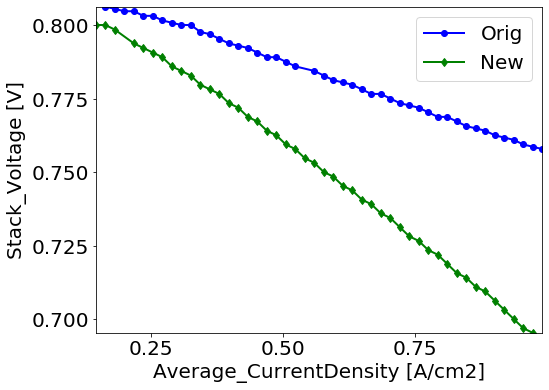

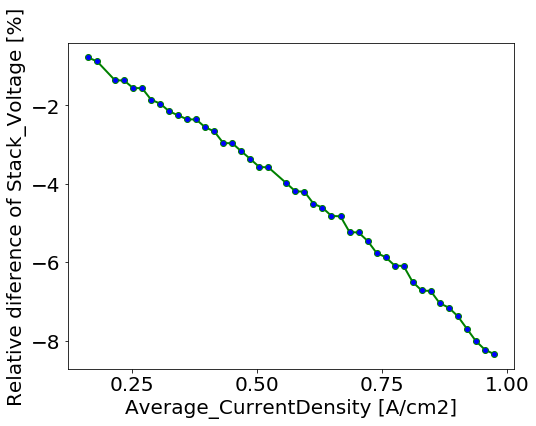

In [15]:
# work_path_up = './Test_LUA'
# numvar = 9; numsample =50
# listvar = [2, 19, 21, 31, 23, 25, 36, 37, 52]
# listmin = [1000, 900, 0.5, 900, 0.4, 2.25, 0.675, 0.45, 1]
# listmax = [10000, 900, 0.5, 900, 0.4, 2.25, 0.675, 0.45, 1]
# LHSampling(work_path_up, numvar, numsample, listvar, listmin, listmax)

xvariable = 1; yvariable = 2
file11 = './Test_LUA/U_PT/Orig/allResults.dat'
file12 = './Test_LUA/U_PT/Orig/allResults_info.dat'
file21 = './Test_LUA/U_PT/New/allResults.dat'
file22 = './Test_LUA/U_PT/New/allResults_info.dat'
C = comparison()
C.comp_plot(xvariable, yvariable, file11, file12, file21, file22)

Study at fuel/oxidant temperature = 300 C and Systempressure = 3 atm

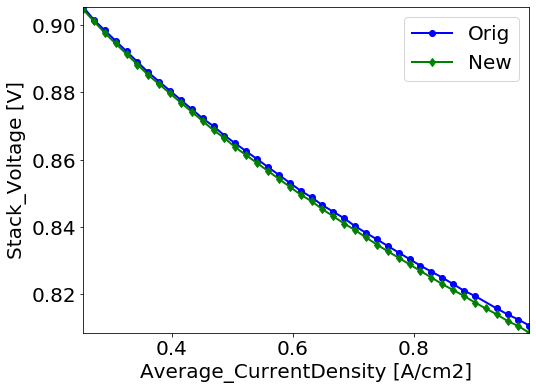

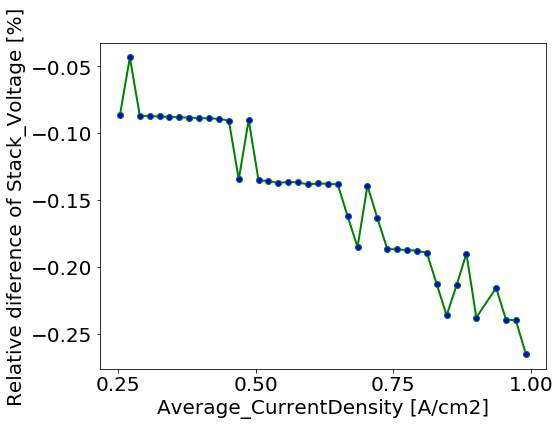

In [16]:
# work_path_up = './Test_LUA'
# numvar = 9; numsample =50
# listvar = [2, 19, 21, 31, 23, 25, 36, 37, 52]
# listmin = [1000, 300, 0.5, 675, 0.4, 2.25, 0.675, 0.45, 3]
# listmax = [10000, 300, 0.5, 675, 0.4, 2.25, 0.675, 0.45, 3]
# LHSampling(work_path_up, numvar, numsample, listvar, listmin, listmax)

xvariable = 1; yvariable = 2
file11 = './Test_LUA/N/Orig/allResults.dat'
file12 = './Test_LUA/N/Orig/allResults_info.dat'
file21 = './Test_LUA/N/New/allResults.dat'
file22 = './Test_LUA/N/New/allResults_info.dat'
C = comparison()
C.comp_plot(xvariable, yvariable, file11, file12, file21, file22)

Study at fuel/oxidant temperature = 900 C and Systempressure = 3 atm

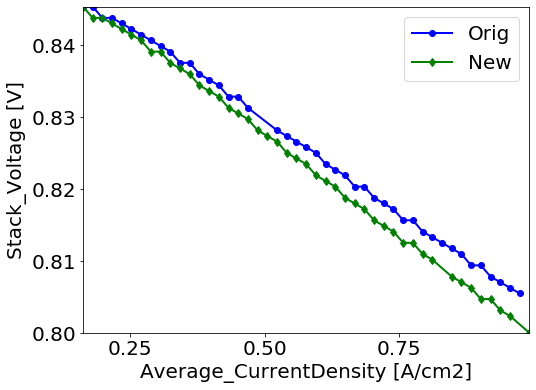

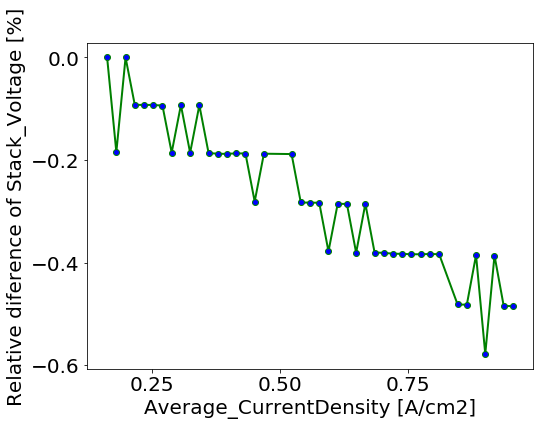

In [17]:
# work_path_up = './Test_LUA'
# numvar = 9; numsample =50
# listvar = [2, 19, 21, 31, 23, 25, 36, 37, 52]
# listmin = [1000, 900, 0.5, 900, 0.4, 2.25, 0.675, 0.45, 3]
# listmax = [10000, 900, 0.5, 900, 0.4, 2.25, 0.675, 0.45, 3]
# LHSampling(work_path_up, numvar, numsample, listvar, listmin, listmax)

xvariable = 1; yvariable = 2
file11 = './Test_LUA/U_T/Orig/allResults.dat'
file12 = './Test_LUA/U_T/Orig/allResults_info.dat'
file21 = './Test_LUA/U_T/New/allResults.dat'
file22 = './Test_LUA/U_T/New/allResults_info.dat'
C = comparison()
C.comp_plot(xvariable, yvariable, file11, file12, file21, file22)

Study at fuel/oxidant temperature = 300 C and Systempressure = 1 atm

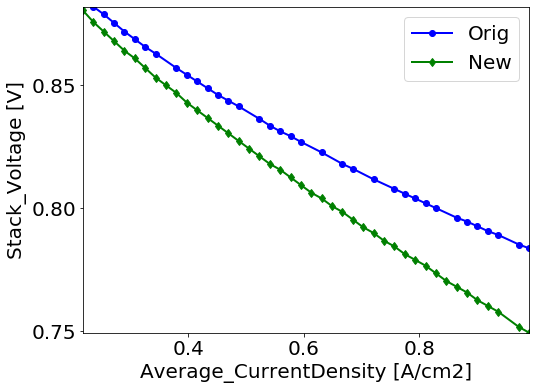

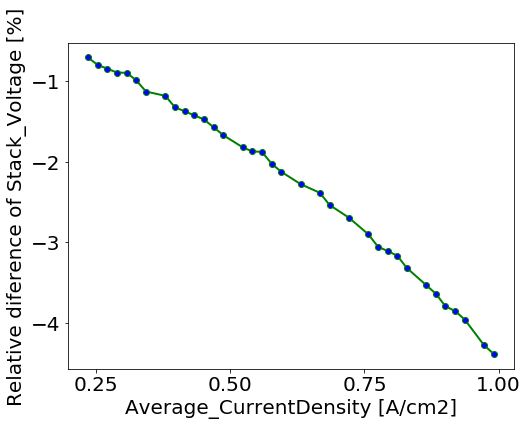

In [18]:
# work_path_up = './Test_LUA'
# numvar = 9; numsample =50
# listvar = [2, 19, 21, 31, 23, 25, 36, 37, 52]
# listmin = [1000, 300, 0.5, 675, 0.4, 2.25, 0.675, 0.45, 1]
# listmax = [10000, 300, 0.5, 675, 0.4, 2.25, 0.675, 0.45, 1]
# LHSampling(work_path_up, numvar, numsample, listvar, listmin, listmax)

xvariable = 1; yvariable = 2
file11 = './Test_LUA/Orig/allResults.dat'
file12 = './Test_LUA/Orig/allResults_info.dat'
file21 = './Test_LUA/New/allResults.dat'
file22 = './Test_LUA/New/allResults_info.dat'
C = comparison()
C.comp_plot(xvariable, yvariable, file11, file12, file21, file22)